# Using linear regression, gradient descent, targeted polynomial regression and neural networks to predict fever using a infrared thermography scanner.

In this notebook I will implement multiple methods of predicting oral temperatur, and use these results to perform a classification task on whether the subjects have a fever or not.

First, we import the necessary libraries:

In [13]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# Set up visualization parameters
plt.rcParams['figure.figsize'] = (12, 7)


Now, create a function to load the infrared thermography dataset from the UCI ML repo, and display some important information graphically.

In [14]:
def load_and_explore_data():

    infrared_thermography_temperature = fetch_ucirepo(id=925)
    print(infrared_thermography_temperature.variables)
    
    # Extract features and targets
    X = infrared_thermography_temperature.data.features
    y = infrared_thermography_temperature.data.targets
    
    # Combine for exploration
    data = pd.concat([X, y], axis=1)
    
    # Print basic information
    print(f"Dataset shape: {data.shape}")
    print("\nSample of data:")
    display(data.head())
    
    print("\nTarget variables summary:")
    display(data[['aveOralF', 'aveOralM']].describe())
    
    # Check missing values
    missing_values = data.isnull().sum()
    print("\nMissing values:")
    print(missing_values[missing_values > 0])
    
    # Visualize target distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(data['aveOralF'], label='Fast Oral Temp', kde=True, color='green')
    sns.histplot(data['aveOralM'], label='Monitor Oral Temp', kde=True, color='pink', alpha=0.6)
    plt.title('Distribution of Target Variables')
    plt.legend()
    plt.xlabel('Temperature (°F)')
    plt.show()
    
    # Check correlation between targets
    print("\nCorrelation between target variables:")
    print(data[['aveOralF', 'aveOralM']].corr())
    
    return data

Now we create a preprocessor to prepare the data for the models. We fill the 2 missing values in the Distance column with the median, drop the subjectID, and encode the Gender, Ethnicity and Age columns. We also drop the two variables to be predicted from the training data.

In [15]:
def preprocessing(data):
    
    distance_missing = data['Distance'].isnull().sum()
    if distance_missing > 0:
        print(f"Filling {distance_missing} missing values in Distance column with median")
        median_distance = data['Distance'].median()
        data['Distance'].fillna(median_distance, inplace=True)
        print(f"Median Distance value used: {median_distance:.2f}")
    

    # Columns to drop
    columns_to_drop = [
        'SubjectID'
    ]
    
    # Keep only columns that exist in the dataset
    columns_to_drop = [col for col in columns_to_drop if col in data.columns]
    
    # Identify categorical columns that need encoding
    categorical_cols = []
    
    if 'Gender' in data.columns:
        categorical_cols.append('Gender')
        
    if 'Ethnicity' in data.columns:
        categorical_cols.append('Ethnicity')
    
    # Handle Age - if it's in categories rather than numeric
    if 'Age' in data.columns and data['Age'].dtype == 'object':
        categorical_cols.append('Age')
        
    # Drop unwanted columns
    X = data.drop(columns=columns_to_drop + ['aveOralF', 'aveOralM'])
    y = data[['aveOralF', 'aveOralM']]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Get numerical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in categorical_cols]
    
    # Create transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
        
    # Create column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Fit the preprocessor to the training data
    preprocessor.fit(X_train)
    
    if categorical_cols:
        print(f"Categorical features encoded: {categorical_cols}")
    
    return X_train, X_test, y_train, y_test, preprocessor, data

Now, we create a function for performing the most basic prediction, a linear regression. We will implement 5 fold cross validation in order to evaluate the performance.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np


def train_and_evaluate_regression(X_train, X_test, y_train, y_test, preprocessor, target_name):
    print(f"Training Linear Regression model for {target_name}")
    
    # Apply preprocessing to get transformed features
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Create and train linear regression model
    model = LinearRegression()
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    # Calculate metrics on training data
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics on test data
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Display metrics
    print(f"\nTraining Set Metrics:")
    print(f"RMSE: {train_rmse:.4f}")
    print(f"MAE: {train_mae:.4f}")
    print(f"R²: {train_r2:.4f}")
    
    print(f"\nTest Set Metrics:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")
    
    # Cross-validation
    print("\nPerforming 5-fold cross-validation...")
    cv_scores = cross_val_score(
        LinearRegression(),
        preprocessor.transform(X_train),
        y_train,
        cv=5,
        scoring="neg_mean_squared_error"
    )
    cv_rmse_scores = np.sqrt(-cv_scores)
    print(f"CV RMSE scores: {cv_rmse_scores.round(4)}")
    print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f}")
    print(f"Standard deviation of CV RMSE: {cv_rmse_scores.std():.4f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'Linear Regression: Actual vs Predicted {target_name}')
    
    # Add metrics annotation to the plot
    metrics_text = f"Test RMSE: {test_rmse:.4f}\nTest R²: {test_r2:.4f}"
    plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                 va='top')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return model and metrics for further use 
    metrics = {
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse_scores.mean()
    }
    
    return model, metrics

def perform_regression(y_train, y_test, preprocessor, X_train, X_test):
    
    y_train_F = y_train['aveOralF']
    y_test_F = y_test['aveOralF']

    y_train_M = y_train['aveOralM'] 
    y_test_M = y_test['aveOralM']

    model_F, metrics_F = train_and_evaluate_regression(
        X_train, X_test, y_train_F, y_test_F, preprocessor, "Fast Oral Temperature (aveOralF)"
    )

    model_M, metrics_M = train_and_evaluate_regression(
        X_train, X_test, y_train_M, y_test_M, preprocessor, "Monitor Oral Temperature (aveOralM)"
    )

    # Compare the performance between the two models
    print("Comparison of model performance")
    print(f"Fast Oral Temperature (aveOralF) - Test RMSE: {metrics_F['test_rmse']:.4f}, R²: {metrics_F['test_r2']:.4f}")
    print(f"Monitor Oral Temperature (aveOralM) - Test RMSE: {metrics_M['test_rmse']:.4f}, R²: {metrics_M['test_r2']:.4f}")
    
 
    return [metrics_F], [metrics_M]
   

Now we create a workflow to train and evaluate polynomial regression across multiple degrees.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def train_and_evaluate_polynomial_regression(X_train, X_test, y_train, y_test, preprocessor, target_name, degree=2):
    # Train polynomial regression model
    print(f"Training Polynomial Regression (degree={degree}) model for {target_name}")

    # First preprocess the data
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Then create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_processed)
    X_test_poly = poly_features.transform(X_test_processed)
    
    # Train the linar regression model
    regressor = LinearRegression()
    regressor.fit(X_train_poly, y_train)
    
    # Make predictions
    y_train_pred = regressor.predict(X_train_poly)
    y_test_pred = regressor.predict(X_test_poly)
    
    # Calculate metrics on training data
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics on test data
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Create a pipeline for cross-validation (this won't be used for predictions, just CV)
    cv_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('poly_features', poly_features),
        ('regressor', LinearRegression())
    ])
    
    cv_scores = cross_val_score(
        cv_pipeline,
        X_train,
        y_train,
        cv=5,
        scoring="neg_mean_squared_error"
    )
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'Polynomial Regression (degree={degree}): Actual vs Predicted {target_name}')
    
    # Add metrics annotaton to the plot
    metrics_text = f"Test RMSE: {test_rmse:.4f}\nTest R²: {test_r2:.4f}"
    plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                 va='top')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # Uncomment this to show graphs (It is a loooot of graphs)
    plt.show()
    
    # Store model and transformation steps for later use if needed
    model = {"regressor": regressor, "poly_features": poly_features, "preprocessor": preprocessor}
    
    # Return metrics dictionary
    metrics = {
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse_scores.mean(),
        'degree': degree
    }
    
    return model, metrics

First, a function to do polynomial regression across all the variables in the dataset, finding the best degree out of 3 options.

In [ ]:

def perform_polynomial_regression(y_train, y_test, preprocessor, X_train, X_test, degrees=[1, 2, 3]):

    results_F = []
    results_M = []
    
    # Split target variables
    y_train_F = y_train['aveOralF']
    y_test_F = y_test['aveOralF']
    
    y_train_M = y_train['aveOralM'] 
    y_test_M = y_test['aveOralM']
    
    # Train models with different polynomial degrees for Fast Oral Temperature
    for degree in degrees:
        
        # Fast Oral Temperature
        model_F, metrics_F = train_and_evaluate_polynomial_regression(
            X_train, X_test, y_train_F, y_test_F, 
            preprocessor, f"Fast Oral Temperature (aveOralF)", 
            degree=degree
        )
        results_F.append(metrics_F)
        
        # Monitor Oral Temperature
        model_M, metrics_M = train_and_evaluate_polynomial_regression(
            X_train, X_test, y_train_M, y_test_M, 
            preprocessor, f"Monitor Oral Temperature (aveOralM)", 
            degree=degree
        )
        results_M.append(metrics_M)
    
    # Compare results across different degrees

    print("SUMMARY OF POLYNOMIAL REGRESSION MODELS")
    
    # Create comparison table for Fast Oral Temperature
    print("\nFast Oral Temperature (aveOralF)")
    print(f"{'Degree':<8} {'Train RMSE':<12} {'Test RMSE':<12} {'Test R²':<12} {'CV RMSE':<12}")
    for result in results_F:
        print(f"{result['degree']:<8} {result['train_rmse']:<12.4f} {result['test_rmse']:<12.4f} {result['test_r2']:<12.4f} {result['cv_rmse']:<12.4f}")
    
    # Create comparison table for Monitor Oral Temperature
    print("\nMonitor Oral Temperature (aveOralM)")
    print(f"{'Degree':<8} {'Train RMSE':<12} {'Test RMSE':<12} {'Test R²':<12} {'CV RMSE':<12}")
    for result in results_M:
        print(f"{result['degree']:<8} {result['train_rmse']:<12.4f} {result['test_rmse']:<12.4f} {result['test_r2']:<12.4f} {result['cv_rmse']:<12.4f}")
    
    # Plot comparison of test RMSE across degrees
    plt.figure(figsize=(10, 6))
    degrees_list = [r['degree'] for r in results_F]
    test_rmse_F = [r['test_rmse'] for r in results_F]
    test_rmse_M = [r['test_rmse'] for r in results_M]
    
    plt.plot(degrees_list, test_rmse_F, 'go-', linewidth=2, label='Fast Oral Temp')
    plt.plot(degrees_list, test_rmse_M, color='pink', linewidth=2, label='Monitor Oral Temp')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Test RMSE')
    plt.title('Test RMSE vs. Polynomial Degree')
    plt.xticks(degrees_list)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # Uncomment this to show graphs (It is a loooot of graphs)
    plt.show()
    
    # Return best models based on test RMSE
    best_degree_F = results_F[np.argmin([r['test_rmse'] for r in results_F])]['degree']
    best_degree_M = results_M[np.argmin([r['test_rmse'] for r in results_M])]['degree']
    
    print(f"\nBest polynomial degree for Fast Oral Temperature: {best_degree_F}")
    print(f"Best polynomial degree for Monitor Oral Temperature: {best_degree_M}")
    
    return results_F, results_M

To use polynomial regression more effectively, we create specific feature sets from parts of the dataset. This will help us find the most important parts of the data for prediction. Using less data for our prediction (as long as it is important data) will help our prediction accuracy.

In [ ]:
def perform_targeted_polynomial_regression(y_train, y_test, preprocessor, X_train, X_test, 
                                          target_features, degrees=[1, 2, 3]):
    
    # Extract only the specified features
    X_train_subset = X_train[target_features].copy()
    X_test_subset = X_test[target_features].copy()
    
    # Create transformers for each type
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Create column transformer
    target_preprocessor = numeric_transformer
    
    target_preprocessor.fit(X_train_subset)
    
    results_F = []
    results_M = []
    
    # Split target variables
    y_train_F = y_train['aveOralF']
    y_test_F = y_test['aveOralF']
    
    y_train_M = y_train['aveOralM'] 
    y_test_M = y_test['aveOralM']
    
    # Temporarily suppress showing plots by storing the old show function
    old_show = plt.show
    plt.show = lambda: None 
    
    # Train models with different polynomial degrees
    for degree in degrees:   
        # Fast Oral Temperature
        model_F, metrics_F = train_and_evaluate_polynomial_regression(
            X_train_subset, X_test_subset, y_train_F, y_test_F, 
            target_preprocessor, f"Fast Oral Temperature (aveOralF)", 
            degree=degree
        )
        metrics_F['feature_set'] = target_features
        metrics_F['model'] = model_F
        results_F.append(metrics_F)
        
        # Monitor Oral Temperature
        model_M, metrics_M = train_and_evaluate_polynomial_regression(
            X_train_subset, X_test_subset, y_train_M, y_test_M, 
            target_preprocessor, f"Monitor Oral Temperature (aveOralM)", 
            degree=degree
        )
        metrics_M['feature_set'] = target_features
        metrics_M['model'] = model_M
        results_M.append(metrics_M)
    
    # Restore the original show function
    plt.show = old_show
    
    # Find best models
    best_F = min(results_F, key=lambda x: x['test_rmse'])
    best_M = min(results_M, key=lambda x: x['test_rmse'])
    
    # Now show actual vs predicted plots only for the best models
    plt.figure(figsize=(12, 5))
    
    # Fast Oral Temperature best model
    plt.subplot(1, 2, 1)
    y_test_pred_F = best_F['model']['regressor'].predict(
        best_F['model']['poly_features'].transform(
            best_F['model']['preprocessor'].transform(X_test_subset)
        )
    )
    plt.scatter(y_test_F, y_test_pred_F, alpha=0.5, color='green')
    plt.plot([y_test_F.min(), y_test_F.max()], [y_test_F.min(), y_test_F.max()], 'r--')
    plt.xlabel(f'Actual Fast Oral Temperature')
    plt.ylabel('Predicted Temperature')
    plt.title(f'Best Poly (degree={best_F["degree"]}): Actual vs Predicted')
    metrics_text = f"Test RMSE: {best_F['test_rmse']:.4f}\nTest R²: {best_F['test_r2']:.4f}"
    plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8), va='top')
    plt.grid(True, alpha=0.3)
    
    # Monitor Oral Temperature best model
    plt.subplot(1, 2, 2)
    y_test_pred_M = best_M['model']['regressor'].predict(
        best_M['model']['poly_features'].transform(
            best_M['model']['preprocessor'].transform(X_test_subset)
        )
    )
    plt.scatter(y_test_M, y_test_pred_M, alpha=0.5, color='pink')
    plt.plot([y_test_M.min(), y_test_M.max()], [y_test_M.min(), y_test_M.max()], 'r--')
    plt.xlabel(f'Actual Monitor Oral Temperature')
    plt.ylabel('Predicted Temperature')
    plt.title(f'Best Poly (degree={best_M["degree"]}): Actual vs Predicted')
    metrics_text = f"Test RMSE: {best_M['test_rmse']:.4f}\nTest R²: {best_M['test_r2']:.4f}"
    plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8), va='top')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot comparison of test RMSE across degrees
    plt.figure(figsize=(10, 6))
    degrees_list = [r['degree'] for r in results_F]
    test_rmse_F = [r['test_rmse'] for r in results_F]
    test_rmse_M = [r['test_rmse'] for r in results_M]
    
    plt.plot(degrees_list, test_rmse_F, 'go-', linewidth=2, label='Fast Oral Temp')
    plt.plot(degrees_list, test_rmse_M, color='pink', linewidth=2, label='Monitor Oral Temp')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Test RMSE')
    plt.title(f'Targeted Polynomial Regression: Test RMSE vs. Degree')
    plt.xticks(degrees_list)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results_F, results_M

Here we define 9 different feature sets, varying combinations of important data spots from around the face and environment.

In [ ]:
def try_different_feature_sets(X_train, X_test, y_train, y_test, preprocessor, degrees=[1, 2, 3]):
    """Compare different feature sets for temperature prediction with consolidated visualization"""
    
    # Define different feature sets to try
    feature_sets = {
        "Max Temperatures": ['T_Max1', 'canthiMax1', 'T_OR_Max1'],
        
        "Eye Region": ['RCC1', 'LCC1', 'canthi4Max1'],

        "Mouth Region": ['T_OR1', 'T_OR_Max1'],
        
        "Forehead Region": ['T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHLC1', 'T_FHTC1', 'T_FH_Max1'],

        "Max, Mouth, Eye & Atmosphere": ['T_OR_Max1', 'canthi4Max1', 'canthiMax1', 'T_Max1', 'T_atm'],
                  
        "Max, Mouth, Eye & Environment": ['T_Max1', 'canthi4Max1', 'T_OR_Max1','T_atm', 'Humidity', 'env_factor', 'heat_index'],

        "Max, Mouth, Eye": ['T_Max1', 'canthi4Max1', 'T_OR_Max1'],

        "Max, Mouth, Eye & Forehead": ['T_Max1', 'canthi4Max1', 'T_OR_Max1', 'T_FHCC1', 'T_FH_Max1'],
        
        "Max, Mouth, Eye, Forehead & Environment": ['T_Max1', 'canthi4Max1', 'T_OR_Max1', 'T_FHCC1', 'T_FH_Max1', 'T_atm', 'Humidity'],
    }
    
    # Storage for results and plotting data
    all_results = []
    plotting_data = {}
    
    # Test each feature set
    for set_name, features in feature_sets.items():
        print(f"TESTING FEATURE SET: {set_name}")
        
        # Hacky method to reduce showing plots
        old_show = plt.show
        plt.show = lambda: None 
        
        # Run the polynomial regression
        results_F, results_M = perform_targeted_polynomial_regression(
            y_train, y_test, preprocessor, 
            X_train, X_test, 
            features, degrees
        )
        
        plt.show = old_show
        
        # Store best results for this feature set
        best_F = min(results_F, key=lambda x: x['test_rmse'])
        best_M = min(results_M, key=lambda x: x['test_rmse'])
        
        # Store results for later plotting
        plotting_data[set_name] = {
            'degrees': [r['degree'] for r in results_F],
            'F_rmse': [r['test_rmse'] for r in results_F],
            'M_rmse': [r['test_rmse'] for r in results_M],
            'F_r2': [r['test_r2'] for r in results_F],
            'M_r2': [r['test_r2'] for r in results_M],
            'best_degree_F': best_F['degree'],
            'best_degree_M': best_M['degree']
        }
        
        all_results.append({
            'Set Name': set_name,
            'Features': features,
            'Fast Oral Best Degree': best_F['degree'],
            'Fast Oral Test RMSE': best_F['test_rmse'],
            'Fast Oral Test R²': best_F['test_r2'],
            'Monitor Oral Best Degree': best_M['degree'],
            'Monitor Oral Test RMSE': best_M['test_rmse'],
            'Monitor Oral Test R²': best_M['test_r2']
        })
    
    # Create summary table
    results_df = pd.DataFrame(all_results)
    
    # Create consolidated visualization
    plt.figure(figsize=(16, 12))
    
    # 1. Feature Set Comparison Bar Chart
    plt.subplot(2, 2, 1)
    sorted_results = results_df.sort_values('Fast Oral Test RMSE')
    y_pos = np.arange(len(sorted_results))
    
    plt.barh(y_pos - 0.2, sorted_results['Fast Oral Test RMSE'], 0.4, color='green', alpha=0.7, label='Fast Oral')
    plt.barh(y_pos + 0.2, sorted_results['Monitor Oral Test RMSE'], 0.4, color='pink', alpha=0.7, label='Monitor Oral')
    
    # Add value labels
    for i, v in enumerate(sorted_results['Fast Oral Test RMSE']):
        plt.text(v + 0.01, i - 0.2, f"{v:.3f}", va='center', color='green', fontweight='bold', fontsize=9)
    for i, v in enumerate(sorted_results['Monitor Oral Test RMSE']):
        plt.text(v + 0.01, i + 0.2, f"{v:.3f}", va='center', color='pink', fontweight='bold', fontsize=9)
        
    plt.yticks(y_pos, sorted_results['Set Name'])
    plt.xlabel('Test RMSE (lower is better)')
    plt.title('Feature Set Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Degree Comparison for Best Feature Set
    best_set = sorted_results.iloc[0]['Set Name']
    plt.subplot(2, 2, 2)
    
    degrees = plotting_data[best_set]['degrees']
    plt.plot(degrees, plotting_data[best_set]['F_rmse'], 'go-', linewidth=2, label='Fast Oral Temp')
    plt.plot(degrees, plotting_data[best_set]['M_rmse'], color='pink', linewidth=2, label='Monitor Oral Temp')
    
    # Add markers for best degrees
    best_f_idx = degrees.index(plotting_data[best_set]['best_degree_F'])
    best_m_idx = degrees.index(plotting_data[best_set]['best_degree_M'])
    plt.plot(plotting_data[best_set]['best_degree_F'], 
             plotting_data[best_set]['F_rmse'][best_f_idx], 
             'b*', markersize=15)
    plt.plot(plotting_data[best_set]['best_degree_M'], 
             plotting_data[best_set]['M_rmse'][best_m_idx], 
             'r*', markersize=15)
    
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Test RMSE')
    plt.title(f'Polynomial Degrees for Best Feature Set: {best_set}')
    plt.xticks(degrees)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. R2 Comparison
    plt.subplot(2, 2, 3)
    
    plt.barh(y_pos - 0.2, sorted_results['Fast Oral Test R²'], 0.4, color='green', alpha=0.7, label='Fast Oral')
    plt.barh(y_pos + 0.2, sorted_results['Monitor Oral Test R²'], 0.4, color='pink', alpha=0.7, label='Monitor Oral')
    
    # Add value labels
    for i, v in enumerate(sorted_results['Fast Oral Test R²']):
        plt.text(v - 0.08, i - 0.2, f"{v:.3f}", va='center', color='green', fontweight='bold', fontsize=9)
    for i, v in enumerate(sorted_results['Monitor Oral Test R²']):
        plt.text(v - 0.08, i + 0.2, f"{v:.3f}", va='center', color='pink', fontweight='bold', fontsize=9)
        
    plt.yticks(y_pos, sorted_results['Set Name'])
    plt.xlabel('R² Score')
    plt.title('R² Comparison by Feature Set')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 4. Best Degree Distribution
    plt.subplot(2, 2, 4)
    
    # Count best degrees for each set
    best_degrees_F = results_df['Fast Oral Best Degree'].value_counts().sort_index()
    best_degrees_M = results_df['Monitor Oral Best Degree'].value_counts().sort_index()
    
    all_degrees = sorted(list(set(best_degrees_F.index) | set(best_degrees_M.index)))
    x = np.arange(len(all_degrees))
    
    width = 0.35
    plt.bar(x - width/2, [best_degrees_F.get(d, 0) for d in all_degrees], width, label='Fast Oral')
    plt.bar(x + width/2, [best_degrees_M.get(d, 0) for d in all_degrees], width, label='Monitor Oral')
    
    plt.xlabel('Best Polynomial Degree')
    plt.ylabel('Count')
    plt.title('Distribution of Best Polynomial Degrees')
    plt.xticks(x, all_degrees)
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display the comparison table
    display(results_df[['Set Name', 'Fast Oral Best Degree', 'Fast Oral Test RMSE', 
                        'Fast Oral Test R²', 'Monitor Oral Best Degree', 
                        'Monitor Oral Test RMSE', 'Monitor Oral Test R²']])
    
    return results_df

Now we create a function for Gradient Descent. We will perform 3 kinds, Batch Gradient Descent, Stochastic Gradient Descent and Mini-Batch Gradient Descent. We use a functional approach in this code to be as efficient as possible while searching for the best hyperparameters, as well as early stoping as to not waste computation time.

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def optimize_gradient_descent(X_train, X_test, y_train, y_test, preprocessor):
    
    # Process the data
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Get dimensions
    m, n = X_train_processed.shape
    
    # Add bias term to X
    X_b_train = np.c_[np.ones((m, 1)), X_train_processed]
    X_b_test = np.c_[np.ones((X_test_processed.shape[0], 1)), X_test_processed]
    
    # Results dict
    results = {
        'Fast Oral Temp': {'bgd': {}, 'sgd': {}, 'mbgd': {}},
        'Monitor Oral Temp': {'bgd': {}, 'sgd': {}, 'mbgd': {}}
    }
    
    # Define hyperparameter grids
    hyperparams = {
        'bgd': {'learning_rates': [0.05, 0.01, 0.005], 'iterations': [1000, 2000]},
        'sgd': {'t0_values': [5, 10, 15], 't1_values': [50, 100], 'epochs': [30, 50]},
        'mbgd': {'t0_values': [100, 200, 300], 't1_values': [1000, 2000], 'batch_sizes': [16, 32, 64]}
    }
    
    # Helper function for batch gradient descent tuning
    def tune_bgd(X_train, y_train_norm, hyperparams):
        cv_results = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for lr in hyperparams['learning_rates']:
            for iters in hyperparams['iterations']:
                cv_rmse_scores = []
                
                # Cross-validation
                for train_idx, val_idx in kf.split(X_train):
                    X_cv, X_val = X_train[train_idx], X_train[val_idx]
                    y_cv, y_val = y_train_norm[train_idx], y_train_norm[val_idx]
                    
                    # Initialize theta
                    theta = np.zeros((n+1, 1))
                    
                    # Training loop
                    for iteration in range(iters):
                        gradients = 2/len(X_cv) * X_cv.T.dot(X_cv.dot(theta) - y_cv)
                        
                        # Gradient clipping
                        max_grad_norm = np.sqrt((gradients**2).sum())
                        if max_grad_norm > 5:
                            gradients = gradients * 5 / max_grad_norm
                            
                        theta = theta - lr * gradients
                        
                        # Early stopping check
                        if iteration > 0 and iteration % 100 == 0:
                            val_pred = X_val.dot(theta)
                            val_mse = np.mean((val_pred - y_val) ** 2)
                            if val_mse > 10:  # Divergence check
                                break
                    
                    # Evaluate
                    val_rmse = np.sqrt(np.mean((X_val.dot(theta) - y_val) ** 2))
                    cv_rmse_scores.append(val_rmse)
                
                # Store results
                cv_results.append({
                    'learning_rate': lr,
                    'iterations': iters,
                    'cv_rmse': np.mean(cv_rmse_scores)
                })
                print(f"  BGD: LR={lr}, Iters={iters} → RMSE={np.mean(cv_rmse_scores):.4f}")
        
        return cv_results
    
    # Helper function for stochastic gradient descent tuning
    def tune_sgd(X_train, y_train_norm, hyperparams):
        cv_results = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for t0 in hyperparams['t0_values']:
            for t1 in hyperparams['t1_values']:
                for epochs in hyperparams['epochs']:
                    cv_rmse_scores = []
                    
                    # Cross-validation
                    for train_idx, val_idx in kf.split(X_train):
                        X_cv, X_val = X_train[train_idx], X_train[val_idx]
                        y_cv, y_val = y_train_norm[train_idx], y_train_norm[val_idx]
                        
                        # Initialize theta
                        theta = np.zeros((n+1, 1))
                        m_cv = len(X_cv)
                        
                        # Learning schedule
                        def learning_schedule(t):
                            return t0 / (t + t1)
                        
                        # Training loop
                        for epoch in range(epochs):
                            # Shuffle data
                            shuffled_indices = np.random.permutation(m_cv)
                            X_shuffled, y_shuffled = X_cv[shuffled_indices], y_cv[shuffled_indices]
                            
                            for i in range(m_cv):
                                xi, yi = X_shuffled[i:i+1], y_shuffled[i:i+1]
                                gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
                                
                                # Gradient clipping
                                max_grad_norm = np.sqrt((gradients**2).sum())
                                if max_grad_norm > 1.0:
                                    gradients = gradients * 1.0 / max_grad_norm
                                
                                # Update
                                eta = learning_schedule(epoch * m_cv + i)
                                theta = theta - eta * gradients
                        
                        # Evaluate
                        val_rmse = np.sqrt(np.mean((X_val.dot(theta) - y_val) ** 2))
                        cv_rmse_scores.append(val_rmse)
                    
                    # Store results
                    cv_results.append({
                        't0': t0, 't1': t1, 'epochs': epochs,
                        'cv_rmse': np.mean(cv_rmse_scores)
                    })
                    print(f"  SGD: t0={t0}, t1={t1}, epochs={epochs} → RMSE={np.mean(cv_rmse_scores):.4f}")
        
        return cv_results
    
    # Helper function for mini-batch gradient descent tuning
    def tune_mbgd(X_train, y_train_norm, hyperparams):
        cv_results = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for t0 in hyperparams['t0_values']:
            for t1 in hyperparams['t1_values']:
                for batch_size in hyperparams['batch_sizes']:
                    cv_rmse_scores = []
  
                    for train_idx, val_idx in kf.split(X_train):
                        X_cv, X_val = X_train[train_idx], X_train[val_idx]
                        y_cv, y_val = y_train_norm[train_idx], y_train_norm[val_idx]
                        
                        theta = np.zeros((n+1, 1))
                        m_cv = len(X_cv)
                        
                        def learning_schedule(t):
                            return t0 / (t + t1)
                        
                        # Training loop (fixed epochs for CV)
                        t = 0
                        for epoch in range(30):
                            # Shuffle data
                            shuffled_indices = np.random.permutation(m_cv)
                            X_shuffled, y_shuffled = X_cv[shuffled_indices], y_cv[shuffled_indices]
                            
                            for i in range(0, m_cv, batch_size):
                                t += 1
                                xi = X_shuffled[i:i+batch_size]
                                yi = y_shuffled[i:i+batch_size]
                                
                                # Skip if batch too small
                                if len(xi) < 2: continue
                                
                                gradients = 2/len(xi) * xi.T.dot(xi.dot(theta) - yi)
                                
                                # Gradient clipping
                                max_grad_norm = np.sqrt((gradients**2).sum())
                                if max_grad_norm > 5.0:
                                    gradients = gradients * 5.0 / max_grad_norm
                                
                                # Update
                                eta = learning_schedule(t)
                                theta = theta - eta * gradients
                        
                        # Evaluate
                        val_rmse = np.sqrt(np.mean((X_val.dot(theta) - y_val) ** 2))
                        cv_rmse_scores.append(val_rmse)
                    
                    # Store results
                    cv_results.append({
                        't0': t0, 't1': t1, 'batch_size': batch_size,
                        'cv_rmse': np.mean(cv_rmse_scores)
                    })
                    print(f"  MBGD: t0={t0}, t1={t1}, batch={batch_size} → RMSE={np.mean(cv_rmse_scores):.4f}")
        
        return cv_results
    
    # Helper function to train final model with best params
    def train_final_model(method, X_train, y_train_norm, best_params):
        theta = np.zeros((n+1, 1))
        
        if method == 'bgd':
            # Train BGD
            eta = best_params['learning_rate']
            iters = best_params['iterations']
            
            for iteration in range(iters):
                gradients = 2/m * X_train.T.dot(X_train.dot(theta) - y_train_norm)
                max_grad_norm = np.sqrt((gradients**2).sum())
                if max_grad_norm > 5:
                    gradients = gradients * 5 / max_grad_norm
                theta = theta - eta * gradients
                
        elif method == 'sgd':
            # Train SGD
            t0, t1 = best_params['t0'], best_params['t1']
            epochs = best_params['epochs']
            
            def learning_schedule(t):
                return t0 / (t + t1)
            
            for epoch in range(epochs):
                shuffled_indices = np.random.permutation(m)
                X_shuffled = X_train[shuffled_indices]
                y_shuffled = y_train_norm[shuffled_indices]
                
                for i in range(m):
                    xi, yi = X_shuffled[i:i+1], y_shuffled[i:i+1]
                    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
                    
                    max_grad_norm = np.sqrt((gradients**2).sum())
                    if max_grad_norm > 1.0:
                        gradients = gradients * 1.0 / max_grad_norm
                    
                    eta = learning_schedule(epoch * m + i)
                    theta = theta - eta * gradients
                    
        elif method == 'mbgd':
            # Train MBGD
            t0, t1 = best_params['t0'], best_params['t1']
            batch_size = best_params['batch_size']
            
            def learning_schedule(t):
                return t0 / (t + t1)
            
            t = 0
            for epoch in range(50):  # More epochs for final model
                shuffled_indices = np.random.permutation(m)
                X_shuffled = X_train[shuffled_indices]
                y_shuffled = y_train_norm[shuffled_indices]
                
                for i in range(0, m, batch_size):
                    t += 1
                    xi = X_shuffled[i:i+batch_size]
                    yi = y_shuffled[i:i+batch_size]
                    
                    if len(xi) < 2: continue
                    
                    gradients = 2/len(xi) * xi.T.dot(xi.dot(theta) - yi)
                    
                    max_grad_norm = np.sqrt((gradients**2).sum())
                    if max_grad_norm > 5.0:
                        gradients = gradients * 5.0 / max_grad_norm
                    
                    eta = learning_schedule(t)
                    theta = theta - eta * gradients
        
        return theta
    
    # Process each target variable
    for target_name, y_train_target, y_test_target in [
        ('Fast Oral Temp', y_train['aveOralF'], y_test['aveOralF']),
        ('Monitor Oral Temp', y_train['aveOralM'], y_test['aveOralM'])
    ]:
        print(f"\n{'-'*60}")
        print(f"Optimizing models for {target_name}")
        print(f"{'-'*60}")
        
        # Convert to numpy arrays
        y_train_np = y_train_target.to_numpy().reshape(-1, 1)
        y_test_np = y_test_target.to_numpy().reshape(-1, 1)
        
        # Normalize targets
        y_train_mean = np.mean(y_train_np)
        y_train_std = np.std(y_train_np)
        y_train_norm = (y_train_np - y_train_mean) / y_train_std
        y_test_norm = (y_test_np - y_train_mean) / y_train_std
        
        # Dictionary to store predictions
        predictions = {}
        
        # Run hyperparameter tuning for each method
        print("\n1. Batch Gradient Descent Tuning:")
        bgd_results = tune_bgd(X_b_train, y_train_norm, hyperparams['bgd'])
        best_bgd = min(bgd_results, key=lambda x: x['cv_rmse'])
        print(f"   Best BGD params: LR={best_bgd['learning_rate']}, Iterations={best_bgd['iterations']}")
        print(f"   Best CV RMSE: {best_bgd['cv_rmse']:.4f}")
        
        print("\n2. Stochastic Gradient Descent Tuning:")
        sgd_results = tune_sgd(X_b_train, y_train_norm, hyperparams['sgd'])
        best_sgd = min(sgd_results, key=lambda x: x['cv_rmse'])
        print(f"   Best SGD params: t0={best_sgd['t0']}, t1={best_sgd['t1']}, epochs={best_sgd['epochs']}")
        print(f"   Best CV RMSE: {best_sgd['cv_rmse']:.4f}")
        
        print("\n3. Mini-batch Gradient Descent Tuning:")
        mbgd_results = tune_mbgd(X_b_train, y_train_norm, hyperparams['mbgd'])
        best_mbgd = min(mbgd_results, key=lambda x: x['cv_rmse'])
        print(f"   Best MBGD params: t0={best_mbgd['t0']}, t1={best_mbgd['t1']}, batch_size={best_mbgd['batch_size']}")
        print(f"   Best CV RMSE: {best_mbgd['cv_rmse']:.4f}")
        
        # Train final models with best parameters
        print("\nTraining final models with best parameters...")
        theta_bgd = train_final_model('bgd', X_b_train, y_train_norm, best_bgd)
        theta_sgd = train_final_model('sgd', X_b_train, y_train_norm, best_sgd)
        theta_mbgd = train_final_model('mbgd', X_b_train, y_train_norm, best_mbgd)
        
        # Generate predictions
        y_pred_test_bgd = X_b_test.dot(theta_bgd) * y_train_std + y_train_mean
        y_pred_test_sgd = X_b_test.dot(theta_sgd) * y_train_std + y_train_mean
        y_pred_test_mbgd = X_b_test.dot(theta_mbgd) * y_train_std + y_train_mean
        
        # Calculate metrics
        metrics_bgd = {
            'test_rmse': np.sqrt(mean_squared_error(y_test_np, y_pred_test_bgd)),
            'test_r2': r2_score(y_test_np, y_pred_test_bgd),
            'best_params': best_bgd,
            'theta': theta_bgd
        }
        
        metrics_sgd = {
            'test_rmse': np.sqrt(mean_squared_error(y_test_np, y_pred_test_sgd)),
            'test_r2': r2_score(y_test_np, y_pred_test_sgd),
            'best_params': best_sgd,
            'theta': theta_sgd
        }
        
        metrics_mbgd = {
            'test_rmse': np.sqrt(mean_squared_error(y_test_np, y_pred_test_mbgd)),
            'test_r2': r2_score(y_test_np, y_pred_test_mbgd),
            'best_params': best_mbgd,
            'theta': theta_mbgd
        }
        
        # Store results
        results[target_name]['bgd'] = metrics_bgd
        results[target_name]['sgd'] = metrics_sgd
        results[target_name]['mbgd'] = metrics_mbgd
        
        # Print final metrics
        print("\nFinal Test Metrics:")
        print(f"BGD - RMSE: {metrics_bgd['test_rmse']:.4f}, R²: {metrics_bgd['test_r2']:.4f}")
        print(f"SGD - RMSE: {metrics_sgd['test_rmse']:.4f}, R²: {metrics_sgd['test_r2']:.4f}")
        print(f"MBGD - RMSE: {metrics_mbgd['test_rmse']:.4f}, R²: {metrics_mbgd['test_r2']:.4f}")
        
        # Visualize results in a single figure
        plt.figure(figsize=(15, 6))
        
        # Plot actual vs predicted
        plt.subplot(1, 2, 1)
        color = 'green' if 'Fast' in target_name else 'pink'
        plt.scatter(y_test_np, y_pred_test_bgd, alpha=0.4, label=f'BGD', color=color)
        plt.scatter(y_test_np, y_pred_test_sgd, alpha=0.4, label=f'SGD', color=color, marker='x')
        plt.scatter(y_test_np, y_pred_test_mbgd, alpha=0.4, label=f'MBGD', color=color, marker='+')
        plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'k--')
        plt.xlabel('Actual Temperature')
        plt.ylabel('Predicted Temperature')
        plt.title(f'GD Methods: Predictions for {target_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot method comparison
        plt.subplot(1, 2, 2)
        methods = ['BGD', 'SGD', 'MBGD']
        rmse_values = [metrics_bgd['test_rmse'], metrics_sgd['test_rmse'], metrics_mbgd['test_rmse']]
        r2_values = [metrics_bgd['test_r2'], metrics_sgd['test_r2'], metrics_mbgd['test_r2']]
        
        x = np.arange(len(methods))
        width = 0.35
        
        plt.bar(x - width/2, rmse_values, width, label='RMSE', color='blue', alpha=0.6)
        plt.bar(x + width/2, r2_values, width, label='R²', color='green', alpha=0.6)
        plt.xlabel('Method')
        plt.ylabel('Metric Value')
        plt.title(f'GD Method Comparison for {target_name}')
        plt.xticks(x, methods)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Final comparison across all methods and targets
    print("GRADIENT DESCENT METHODS COMPARISON")
    
    # Prepare summary data
    comparison = []
    for target_name in results:
        for method_name, method_results in results[target_name].items():
            comparison.append({
                'Target': target_name,
                'Method': method_name.upper(),
                'Test RMSE': method_results['test_rmse'],
                'Test R²': method_results['test_r2']
            })
    
    # Create DataFrame and display
    comparison_df = pd.DataFrame(comparison)
    display(comparison_df[['Target', 'Method', 'Test RMSE', 'Test R²']])
    
    # Single consolidated visualization
    plt.figure(figsize=(12, 6))
    
    # Group by target and method
    targets = list(results.keys())
    methods = ['bgd', 'sgd', 'mbgd']
    
    # Set width of bars
    barWidth = 0.25
    r1 = np.arange(len(targets))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    # Create bars
    colors = ['green', 'pink']
    rmse_bgd = [results[target]['bgd']['test_rmse'] for target in targets]
    rmse_sgd = [results[target]['sgd']['test_rmse'] for target in targets]
    rmse_mbgd = [results[target]['mbgd']['test_rmse'] for target in targets]
    
    # Plot with target-specific colors
    for i, (r_pos, rmse, method) in enumerate(zip([r1, r2, r3], [rmse_bgd, rmse_sgd, rmse_mbgd], methods)):
        for j, (target, val) in enumerate(zip(targets, rmse)):
            color = 'green' if 'Fast' in target else 'pink'
            plt.bar(r_pos[j], val, width=barWidth, label=f'{method.upper()}' if j == 0 else "", 
                   color=color, alpha=0.7)
    
    # Add labels and legend
    plt.xlabel('Target Variable')
    plt.ylabel('Test RMSE (lower is better)')
    plt.title('Comparison of Optimized Gradient Descent Methods')
    plt.xticks([r + barWidth for r in range(len(targets))], targets)
    plt.legend(loc='upper right')
    
    # Add value labels on bars
    for i, v in enumerate(rmse_bgd):
        plt.text(r1[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(rmse_sgd):
        plt.text(r2[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(rmse_mbgd):
        plt.text(r3[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results, comparison_df

Our final approach, the traditional neural network. First we train  basic networks, and then we will use Hyperband tuning to find the best hyperparameters, and use early stopping for maximum efficiency and not to waste computation time. However, this will still take quite a long time. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path

def build_neural_network_model(X_train, X_test, y_train, y_test, preprocessor, target_name):
    print(f"Training Neural Network model for {target_name}")
    
    # Process the data
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Set seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Define basic model
    model = keras.Sequential([
        keras.layers.Dense(30, activation='relu', input_shape=[X_train_processed.shape[1]]),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001))
    
    # Create early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        patience=20, 
        restore_best_weights=True,
        monitor='val_loss'
    )
    
    # Train model with validation split
    history = model.fit(
        X_train_processed, y_train, 
        epochs=100,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print metrics
    print(f"\nTraining RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    # Plot learning curves
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curves for {target_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot actual vs predicted
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='green' if 'Fast' in target_name else 'pink')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual Temperature')
    plt.ylabel('Predicted Temperature')
    plt.title(f'Neural Network: Actual vs Predicted {target_name}')
    
    # Add metrics text
    metrics_text = f"Test RMSE: {test_rmse:.4f}\nTest R²: {test_r2:.4f}"
    plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                va='top')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return model, history, {'train_rmse': train_rmse, 'test_rmse': test_rmse, 
                           'train_r2': train_r2, 'test_r2': test_r2}

def build_tunable_model(hp, input_shape):
    # Hyperparameters to tune
    n_hidden = hp.Int('n_hidden', 1, 4, default=2)
    n_neurons = hp.Int('n_neurons', 16, 128, step=16)
    dropout_rate = hp.Float('dropout_rate', 0, 0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    activation = hp.Choice('activation', ['relu', 'elu', 'selu'])
    
    # Build model
    model = keras.Sequential()
    
    # First layer
    model.add(keras.layers.Dense(
        n_neurons, 
        activation=activation,
        input_shape=[input_shape]
    ))
    
    if dropout_rate > 0:
        model.add(keras.layers.Dropout(dropout_rate))
    
    # Hidden layers
    for i in range(n_hidden - 1):
        model.add(keras.layers.Dense(
            hp.Int(f'neurons_layer_{i}', n_neurons // 2, n_neurons, step=16),
            activation=activation
        ))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(keras.layers.Dense(1))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    
    return model

def perform_hyperparameter_tuning(X_train, X_test, y_train, y_test, preprocessor):
    print("NEURAL NETWORK HYPERPARAMETER TUNING")
    
    # Process features
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    results = {}
    
    # Train separate models for each target variable
    for target_name, y_train_target, y_test_target in [
        ('Fast Oral Temp', y_train['aveOralF'], y_test['aveOralF']),
        ('Monitor Oral Temp', y_train['aveOralM'], y_test['aveOralM'])
    ]:
        print(f"\n{'-'*80}")
        print(f"Tuning model for {target_name}")
        print(f"{'-'*80}")
        
        # Set up tensorboard directory
        root_logdir = Path("nn_logs") / target_name.replace(" ", "_")
        root_logdir.mkdir(parents=True, exist_ok=True)
        
        # Define the tunable model builder
        def build_model(hp):
            return build_tunable_model(hp, X_train_processed.shape[1])
        
        # Use Hyperband for tuning (best balance of speed and thoroughness)
        tuner = kt.Hyperband(
            build_model,
            objective='val_loss',
            max_epochs=50,
            factor=3,
            hyperband_iterations=2,
            directory='nn_tuning',
            project_name=target_name.replace(" ", "_"),
            overwrite=True
        )
        
        # Create early stopping callback
        early_stopping = keras.callbacks.EarlyStopping(
            patience=10, 
            restore_best_weights=True
        )
        
        # Create tensorboard callback
        run_id = time.strftime("run_%Y%m%d_%H%M%S")
        tensorboard_cb = keras.callbacks.TensorBoard(
            log_dir=root_logdir / run_id,
            histogram_freq=1
        )
        
        # Search for best hyperparameters
        print("\nSearching for optimal hyperparameters...")
        tuner.search(
            X_train_processed, y_train_target,
            validation_split=0.2,
            epochs=50,
            callbacks=[early_stopping, tensorboard_cb],
            verbose=1
        )
        
        # Get best hyperparameters and model
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model = tuner.hypermodel.build(best_hps)
        
        # Report best hyperparameters
        print("\nBest Hyperparameters:")
        for param, value in best_hps.values.items():
            print(f"  {param}: {value}")
        
        # Train final model with best hyperparameters
        print("\nTraining final model with best hyperparameters...")
        history = best_model.fit(
            X_train_processed, y_train_target,
            validation_split=0.2,
            epochs=100, 
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Make predictions
        y_train_pred = best_model.predict(X_train_processed)
        y_test_pred = best_model.predict(X_test_processed)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train_target, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test_target, y_test_pred))
        train_r2 = r2_score(y_train_target, y_train_pred)
        test_r2 = r2_score(y_test_target, y_test_pred)
        
        # Print metrics
        print(f"\nFinal Model Performance:")
        print(f"  Training RMSE: {train_rmse:.4f}")
        print(f"  Test RMSE: {test_rmse:.4f}")
        print(f"  Training R²: {train_r2:.4f}")
        print(f"  Test R²: {test_r2:.4f}")
        
        # Plot learning curves
        plt.figure(figsize=(14, 6))
        
        # Plot training history
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Learning Curves for {target_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot actual vs predicted
        plt.subplot(1, 2, 2)
        plt.scatter(y_test_target, y_test_pred, alpha=0.5, 
                   color='green' if 'Fast' in target_name else 'pink')
        plt.plot([y_test_target.min(), y_test_target.max()], 
                [y_test_target.min(), y_test_target.max()], 'k--')
        plt.xlabel('Actual Temperature')
        plt.ylabel('Predicted Temperature')
        plt.title(f'Tuned Neural Network: Actual vs Predicted {target_name}')
        
        # Add metrics text
        metrics_text = f"Test RMSE: {test_rmse:.4f}\nTest R²: {test_r2:.4f}"
        plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                    va='top')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Store results
        results[target_name] = {
            'model': best_model,
            'hyperparameters': best_hps.values,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2
        }
    
    return results


In [ ]:

# Function to run the entire neural network workflow
def run_nn_workflow(X_train, X_test, y_train, y_test, preprocessor):
    #  Basic neural network models
    print("\nTraining basic neural network models...")
    
    model_F, history_F, metrics_F = build_neural_network_model(
        X_train, X_test, y_train['aveOralF'], y_test['aveOralF'],
        preprocessor, "Fast Oral Temperature"
    )
    
    model_M, history_M, metrics_M = build_neural_network_model(
        X_train, X_test, y_train['aveOralM'], y_test['aveOralM'],
        preprocessor, "Monitor Oral Temperature"
    )
    
    # Hyperparameter tuning
    print("\nPerforming hyperparameter tuning...")
    nn_tuned_results = perform_hyperparameter_tuning(
        X_train, X_test, y_train, y_test, preprocessor
    )
    
    
    return nn_tuned_results
    

Now we create a function that takes in all of the results from our different apporaches and compares the outcomes. We will compare RMSE and R2 in a table and bar charts.

In [23]:

def compare_ml_approaches(nn_results, poly_results_F, poly_results_M, gd_results, linear_results_f, linear_results_m, targeted_results):
    """Compare neural networks with previous approaches"""
    print("\n" + "="*80)
    print("COMPARISON OF MACHINE LEARNING APPROACHES")
    print("="*80)
    
    # Collect results
    comparison_data = []


    # Fast Oral Temperature results
    if linear_results_f:
        comparison_data.append({
            'Target': 'Fast Oral Temp',
            'Model': 'Linear Regression',
            'Test RMSE': linear_results_f[0]['test_rmse'],
            'Test R²': linear_results_f[0]['test_r2']
        })
    
    
    best_poly_F = min(poly_results_F, key=lambda x: x['test_rmse'])
    comparison_data.append({
        'Target': 'Fast Oral Temp',
        'Model': f"Polynomial (degree={best_poly_F['degree']})",
        'Test RMSE': best_poly_F['test_rmse'],
        'Test R²': best_poly_F['test_r2']
    })

    best_targeted_F = targeted_results.iloc[targeted_results['Fast Oral Test RMSE'].idxmin()]
    comparison_data.append({
        'Target': 'Fast Oral Temp',
        'Model': f"Targeted Poly ({best_targeted_F['Set Name']}, degree={best_targeted_F['Fast Oral Best Degree']})",
        'Test RMSE': best_targeted_F['Fast Oral Test RMSE'],
        'Test R²': best_targeted_F['Fast Oral Test R²']
    })
    
    if gd_results:
        for method in ['bgd', 'sgd', 'mbgd']:
            comparison_data.append({
                'Target': 'Fast Oral Temp', 
                'Model': method.upper(),
                'Test RMSE': gd_results['Fast Oral Temp'][method]['test_rmse'],
                'Test R²': gd_results['Fast Oral Temp'][method]['test_r2']
            })
    
    comparison_data.append({
        'Target': 'Fast Oral Temp',
        'Model': 'Neural Network',
        'Test RMSE': nn_results['Fast Oral Temp']['test_rmse'],
        'Test R²': nn_results['Fast Oral Temp']['test_r2']
    })
    
    # Monitor Oral Temperature results

    if linear_results_m:
        comparison_data.append({
            'Target': 'Monitor Oral Temp',
            'Model': 'Linear Regression',
            'Test RMSE': linear_results_m[0]['test_rmse'],
            'Test R²': linear_results_m[0]['test_r2']
        })

    best_poly_M = min(poly_results_M, key=lambda x: x['test_rmse'])
    comparison_data.append({
        'Target': 'Monitor Oral Temp',
        'Model': f"Polynomial (degree={best_poly_M['degree']})",
        'Test RMSE': best_poly_M['test_rmse'],
        'Test R²': best_poly_M['test_r2']
    })

    best_targeted_M = targeted_results.iloc[targeted_results['Monitor Oral Test RMSE'].idxmin()]
    comparison_data.append({
        'Target': 'Monitor Oral Temp',
        'Model': f"Targeted Poly ({best_targeted_M['Set Name']}, degree={best_targeted_M['Monitor Oral Best Degree']})",
        'Test RMSE': best_targeted_M['Monitor Oral Test RMSE'],
        'Test R²': best_targeted_M['Monitor Oral Test R²']
    })
    
    if gd_results:
        for method in ['bgd', 'sgd', 'mbgd']:
            comparison_data.append({
                'Target': 'Monitor Oral Temp', 
                'Model': method.upper(),
                'Test RMSE': gd_results['Monitor Oral Temp'][method]['test_rmse'],
                'Test R²': gd_results['Monitor Oral Temp'][method]['test_r2']
            })
    
    comparison_data.append({
        'Target': 'Monitor Oral Temp',
        'Model': 'Neural Network',
        'Test RMSE': nn_results['Monitor Oral Temp']['test_rmse'],
        'Test R²': nn_results['Monitor Oral Temp']['test_r2']
    })
    
    # Convert to DataFrame and display
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(14, 10))
    
    # Filter for each target
    fast_results = comparison_df[comparison_df['Target'] == 'Fast Oral Temp'].sort_values('Test RMSE')
    monitor_results = comparison_df[comparison_df['Target'] == 'Monitor Oral Temp'].sort_values('Test RMSE')
    
    # Plot RMSE comparison
    plt.subplot(2, 2, 1)
    plt.barh(fast_results['Model'], fast_results['Test RMSE'], color='green', alpha=0.7)
    plt.xlabel('Test RMSE')
    plt.title('Fast Oral Temperature: Model Comparison')
    plt.grid(alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.barh(monitor_results['Model'], monitor_results['Test RMSE'], color='pink', alpha=0.7)
    plt.xlabel('Test RMSE')
    plt.title('Monitor Oral Temperature: Model Comparison')
    plt.grid(alpha=0.3)
    
    # Plot R² comparison
    plt.subplot(2, 2, 3)
    plt.barh(fast_results['Model'], fast_results['Test R²'], color='green', alpha=0.7)
    plt.xlabel('Test R²')
    plt.title('Fast Oral Temperature: Model Comparison')
    plt.grid(alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.barh(monitor_results['Model'], monitor_results['Test R²'], color='pink', alpha=0.7)
    plt.xlabel('Test R²')
    plt.title('Monitor Oral Temperature: Model Comparison')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df


Finally, it is time to run our entire workflow.

Trial 180 Complete [00h 00m 25s]
val_loss: 3.5303144454956055

Best val_loss So Far: 0.06979271024465561
Total elapsed time: 00h 28m 26s

Best Hyperparameters:
  n_hidden: 4
  n_neurons: 80
  dropout_rate: 0.0
  learning_rate: 0.003620357570558653
  activation: elu
  neurons_layer_0: 8
  neurons_layer_1: 80
  neurons_layer_2: 128
  tuner/epochs: 50
  tuner/initial_epoch: 17
  tuner/bracket: 3
  tuner/round: 3
  tuner/trial_id: 0048

Training final model with best hyperparameters...
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 968.4226 - val_loss: 28.4567
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.1251 - val_loss: 6.9720
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0724 - val_loss: 1.3955
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1362 - val_loss: 0.9174
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6655 - val_loss: 0.6832
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4433 - val_loss: 0.530

Target                                              Model  \
0      Fast Oral Temp                                  Linear Regression   
1      Fast Oral Temp                              Polynomial (degree=1)   
2      Fast Oral Temp  Targeted Poly (Max, Mouth, Eye & Atmosphere, d...   
3      Fast Oral Temp                                                BGD   
4      Fast Oral Temp                                                SGD   
5      Fast Oral Temp                                               MBGD   
6      Fast Oral Temp                                     Neural Network   
7   Monitor Oral Temp                                  Linear Regression   
8   Monitor Oral Temp                              Polynomial (degree=1)   
9   Monitor Oral Temp  Targeted Poly (Max, Mouth, Eye & Atmosphere, d...   
10  Monitor Oral Temp                                                BGD   
11  Monitor Oral Temp                                                SGD   
12  Monitor Oral Temp                                               MBGD   
13  Monitor Oral Temp                                     Neural Network   

    Test RMSE   Test R²  
0    0.239264  0.524320  
1    0.239264  0.524320  
2    0.218869  0.601959  
3    0.234880  0.541593  
4    0.239725  0.522487  
5    0.236249  0.536230  
6    0.258905  0.443018  
7    0.232482  0.743328  
8    0.232482  0.743328  
9    0.218636  0.772991  
10   0.228855  0.751275  
11   0.235674  0.736231  
12   0.230852  0.746914  
13   0.320037  0.513593

Analysis Complete


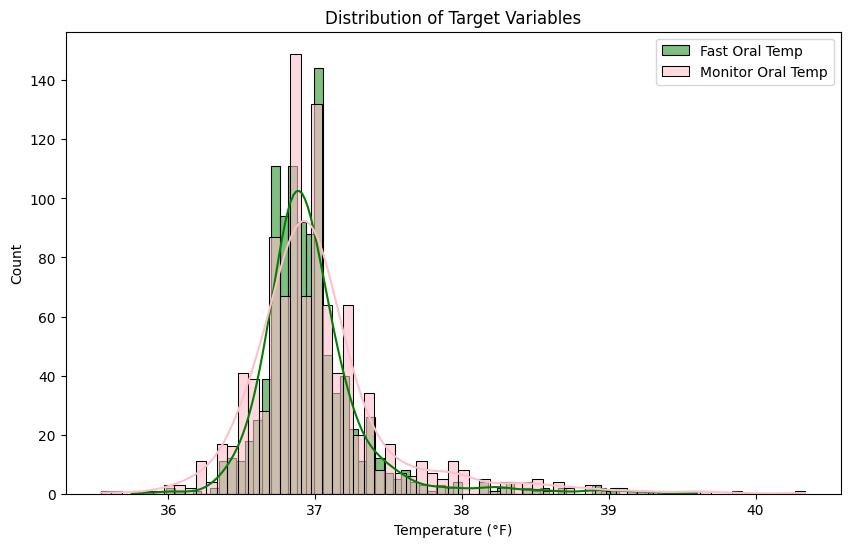

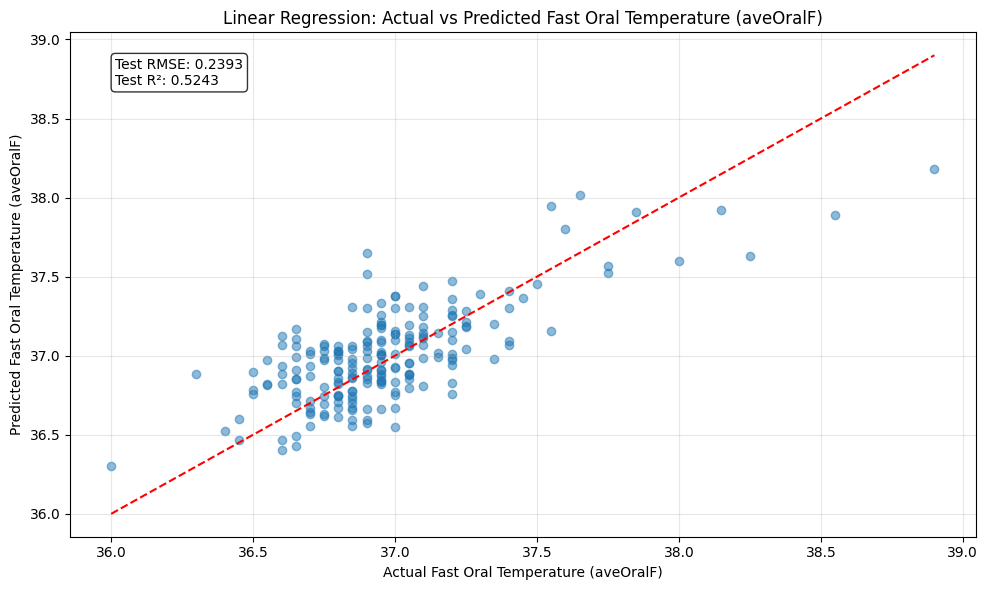

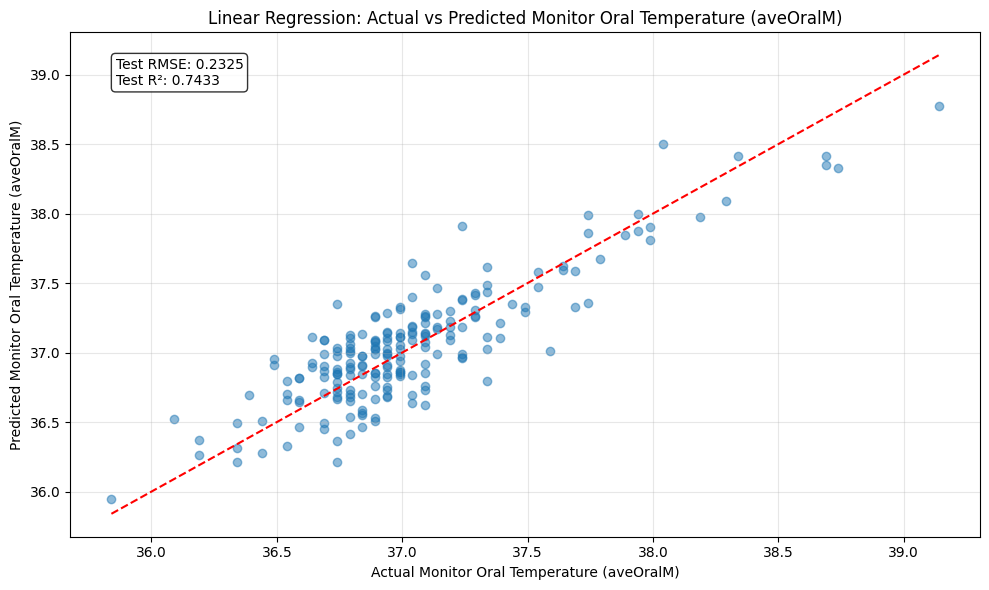

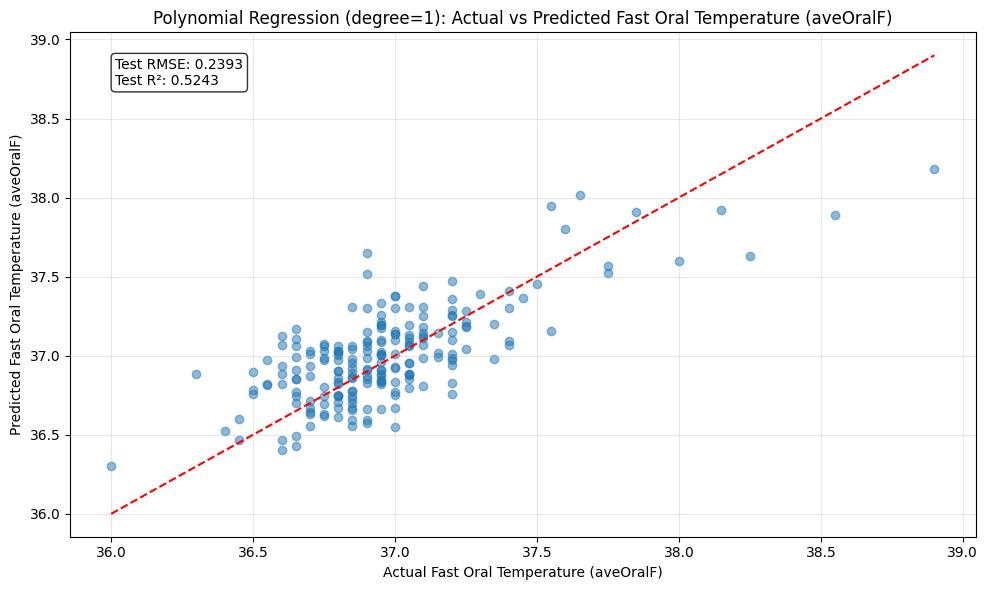

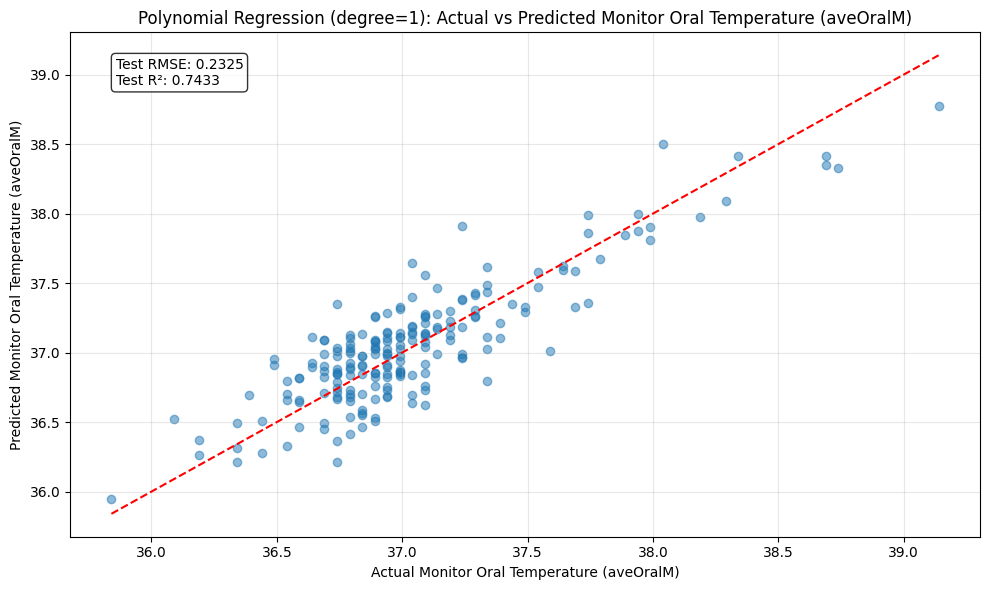

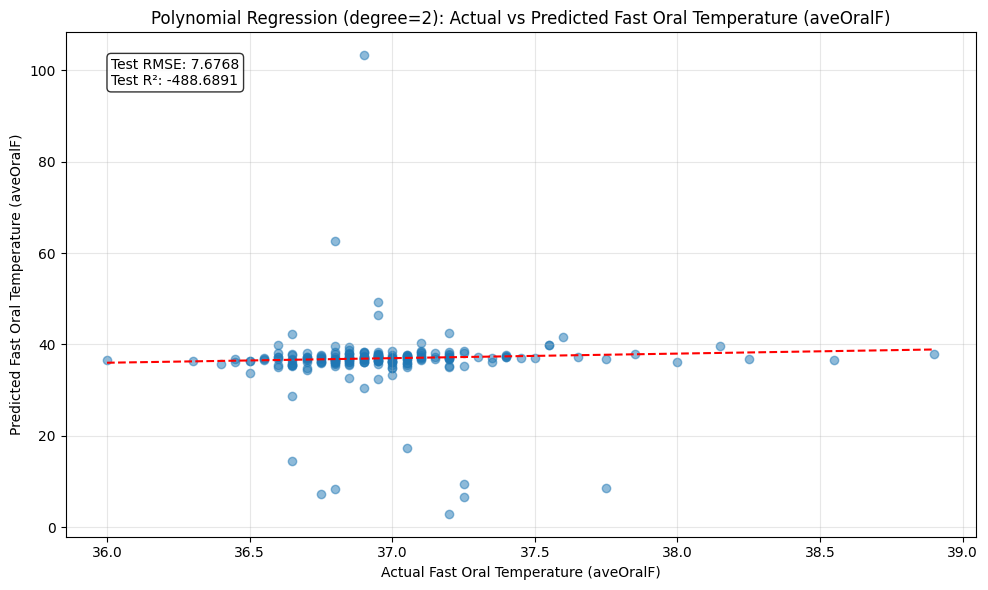

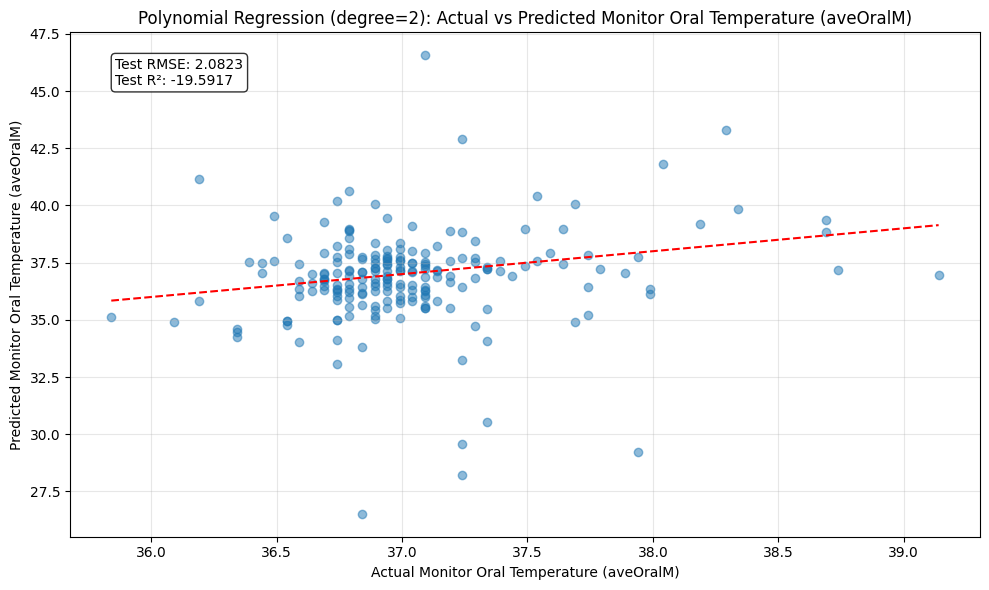

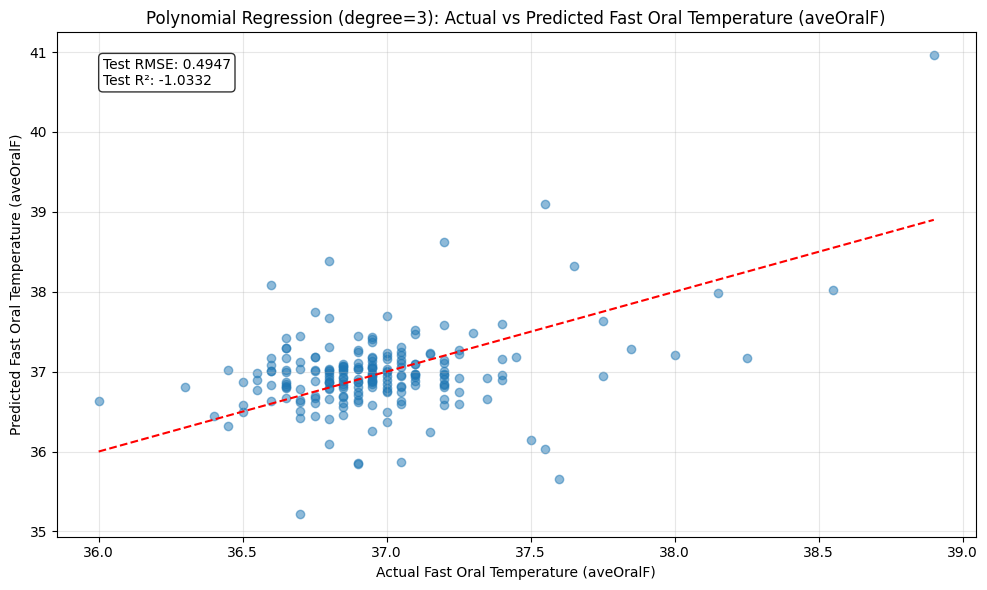

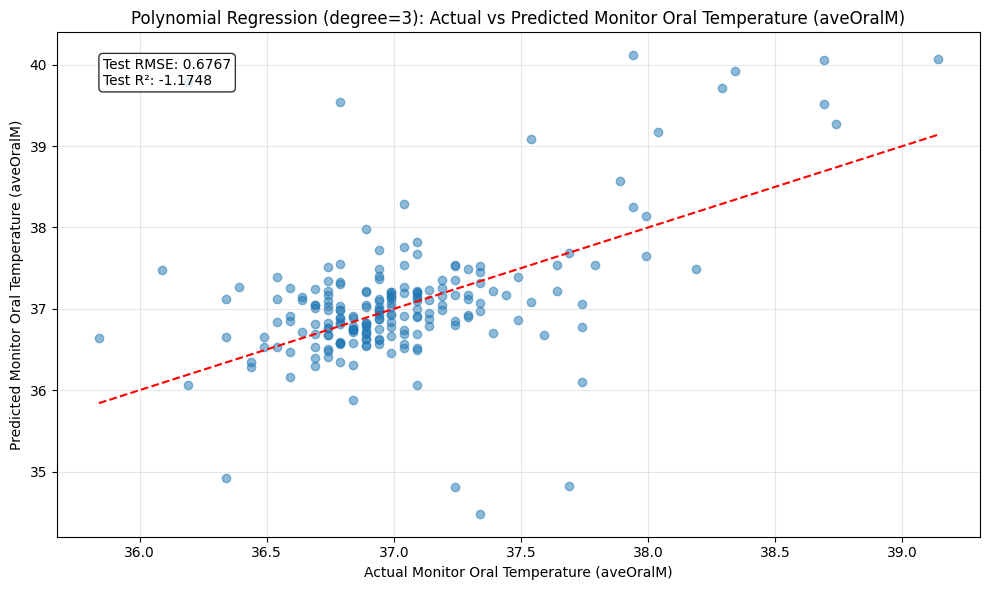

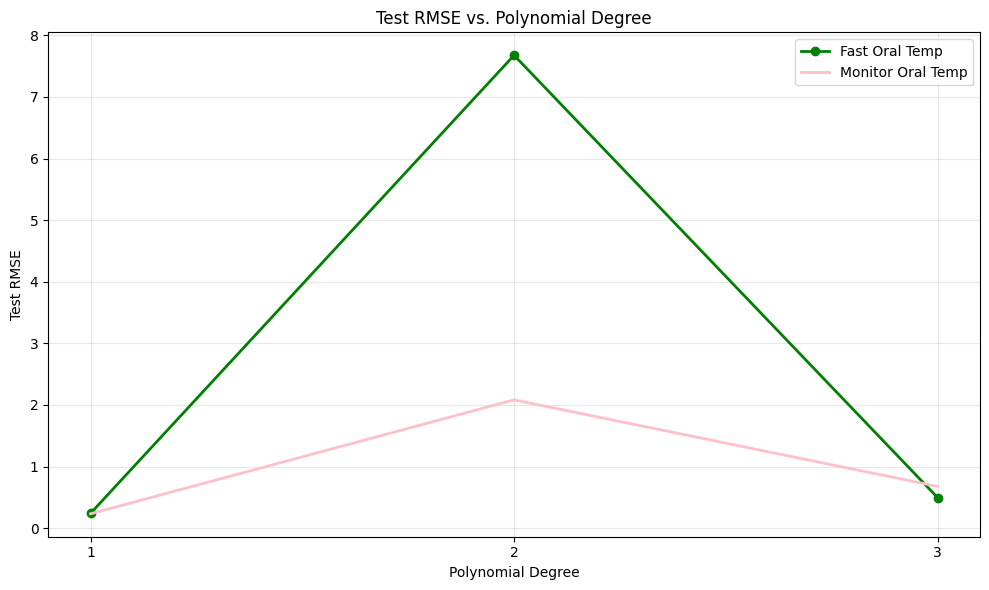

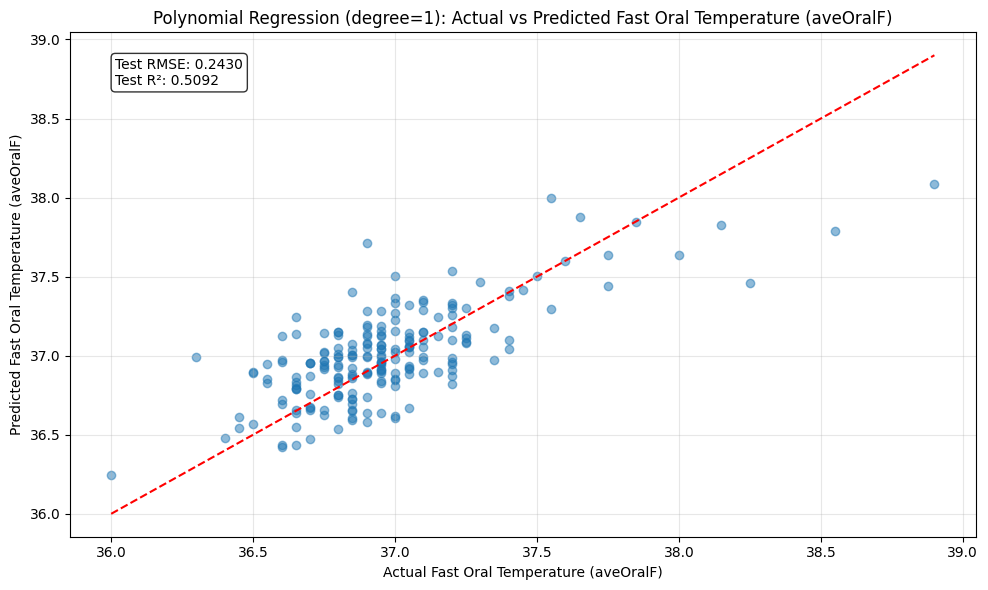

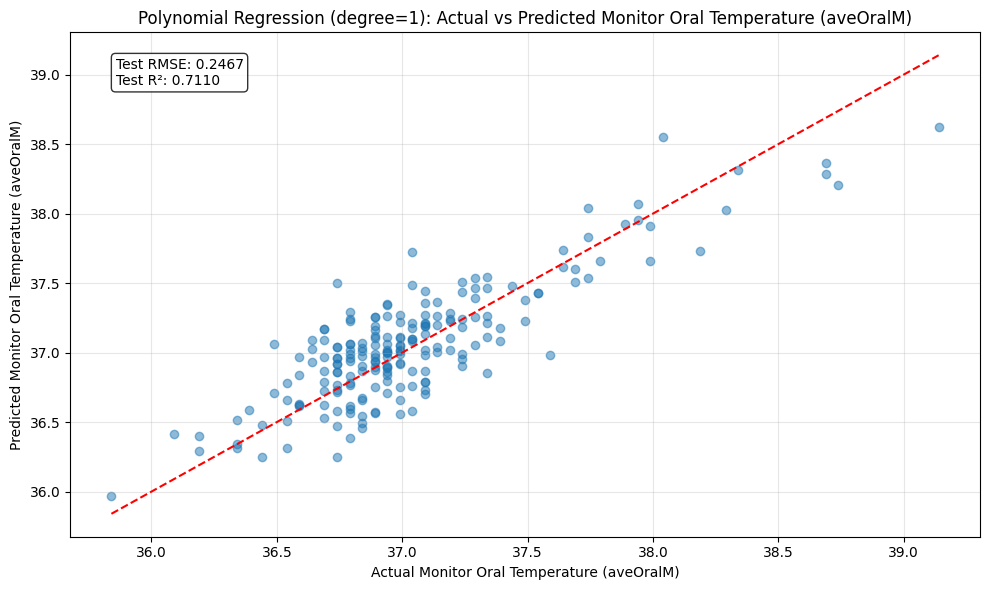

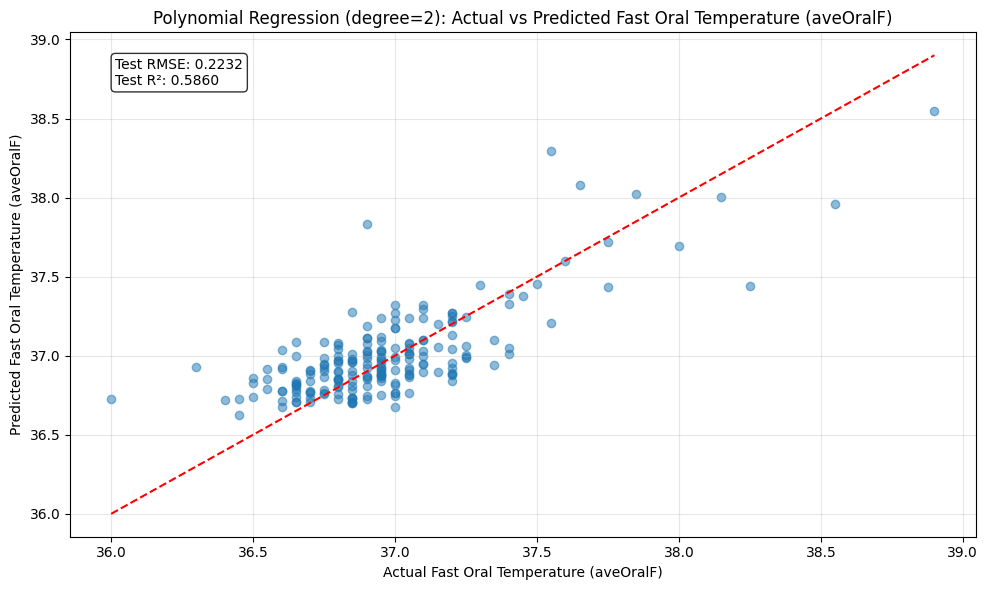

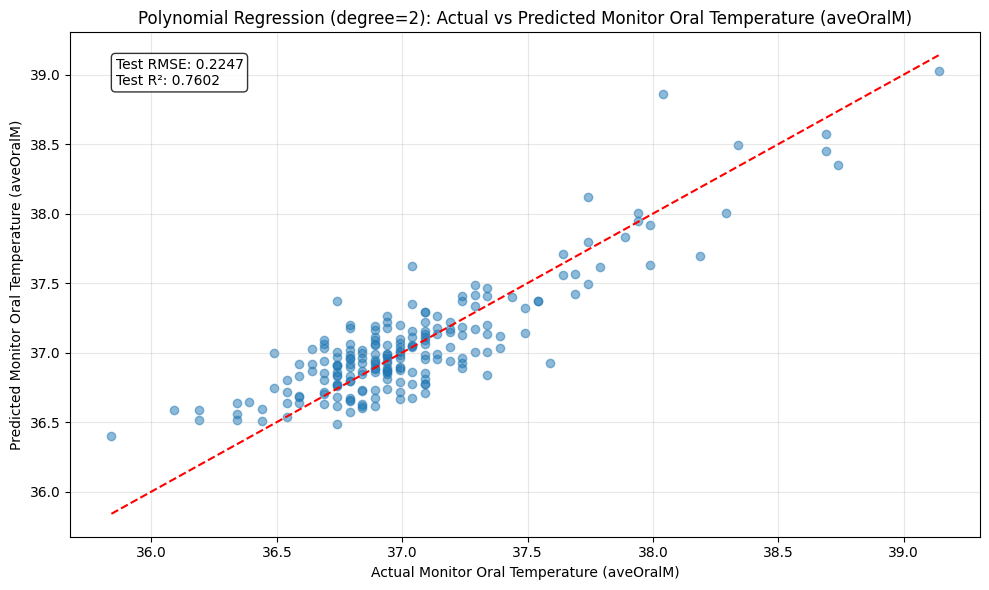

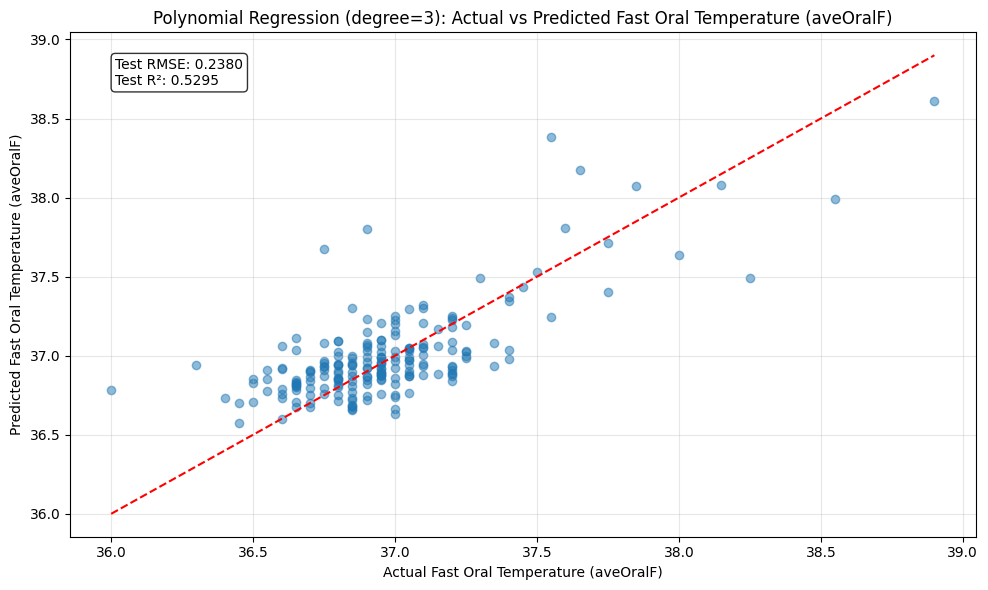

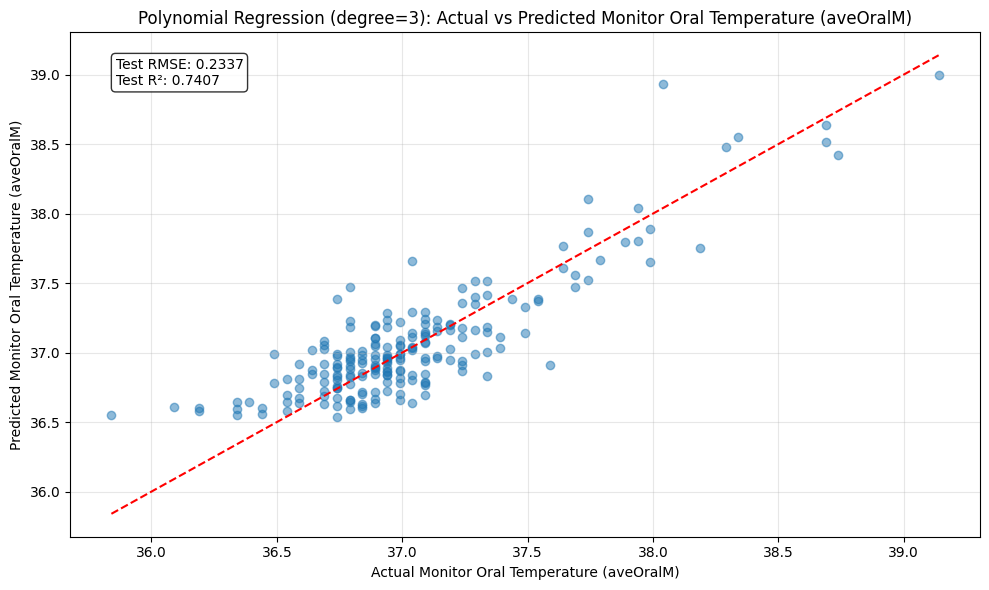

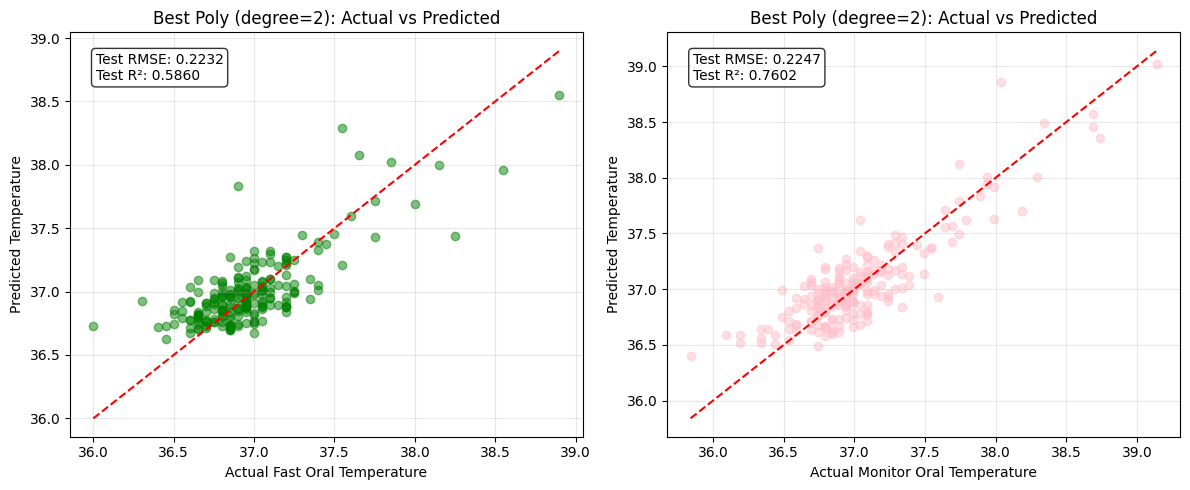

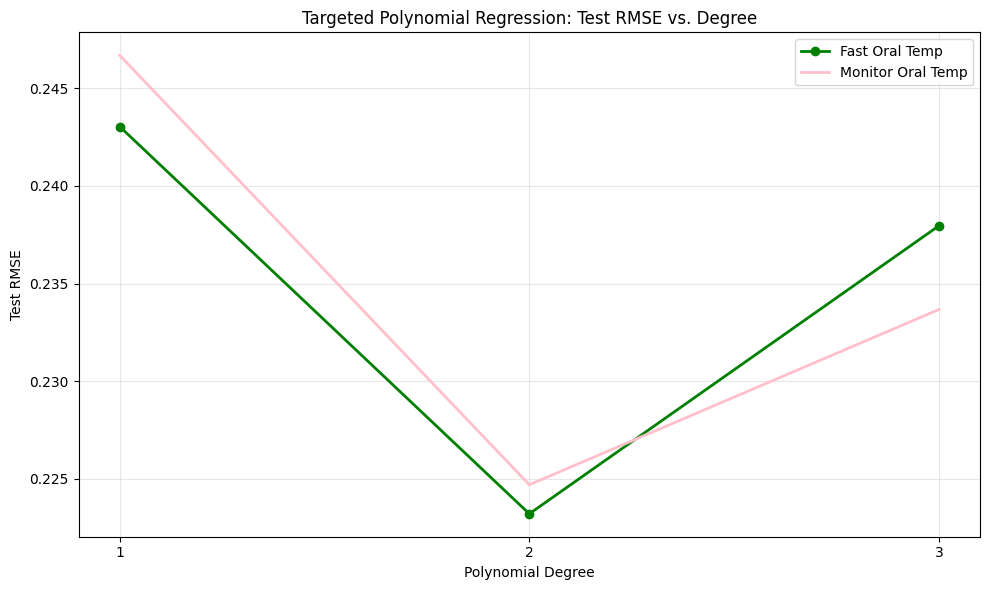

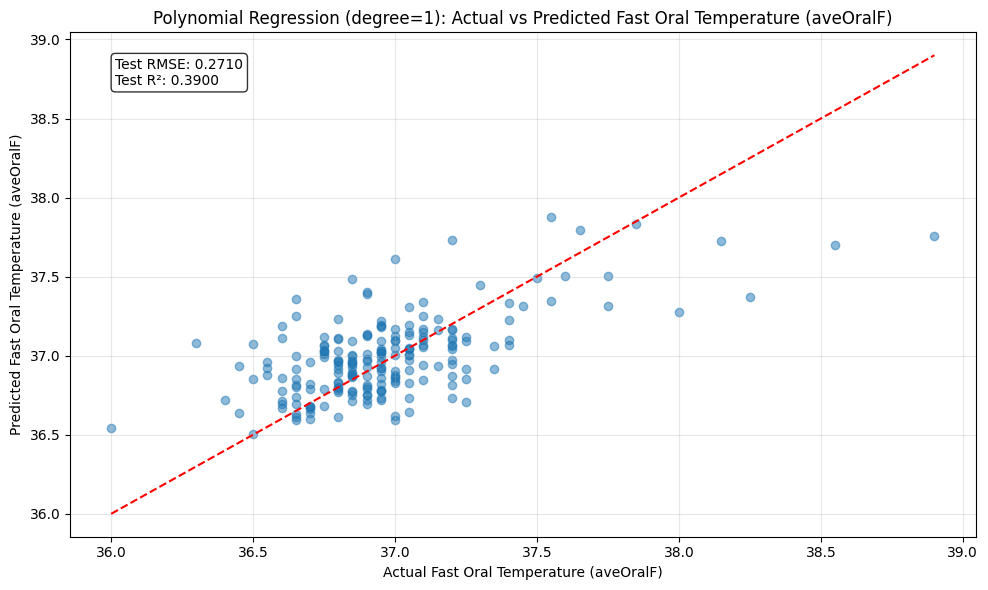

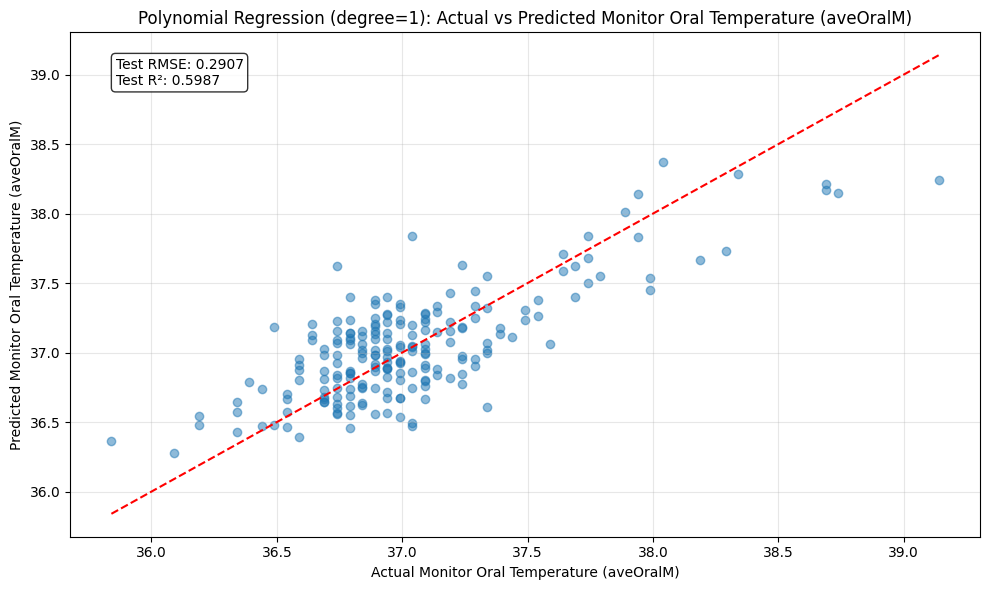

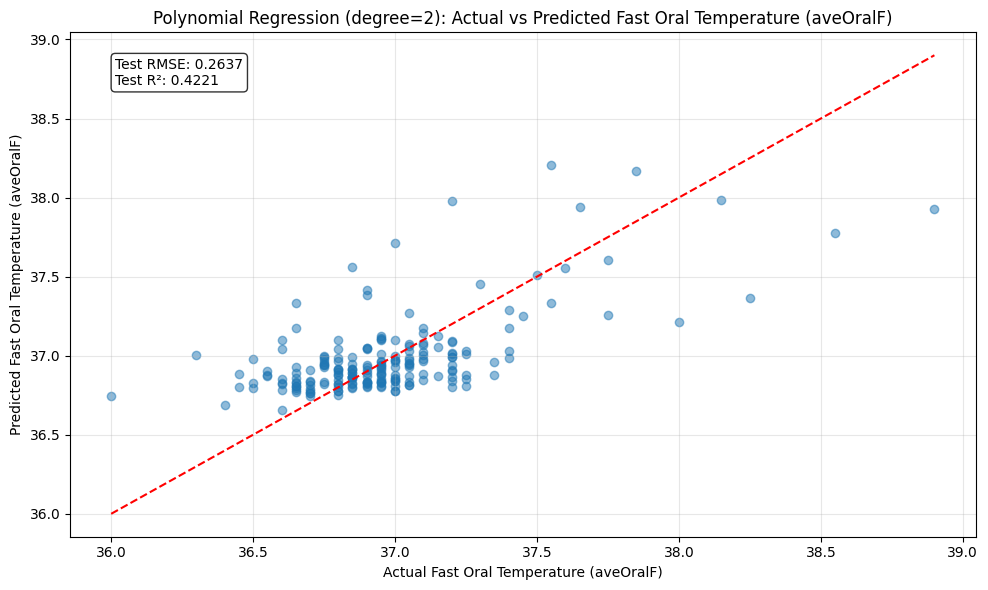

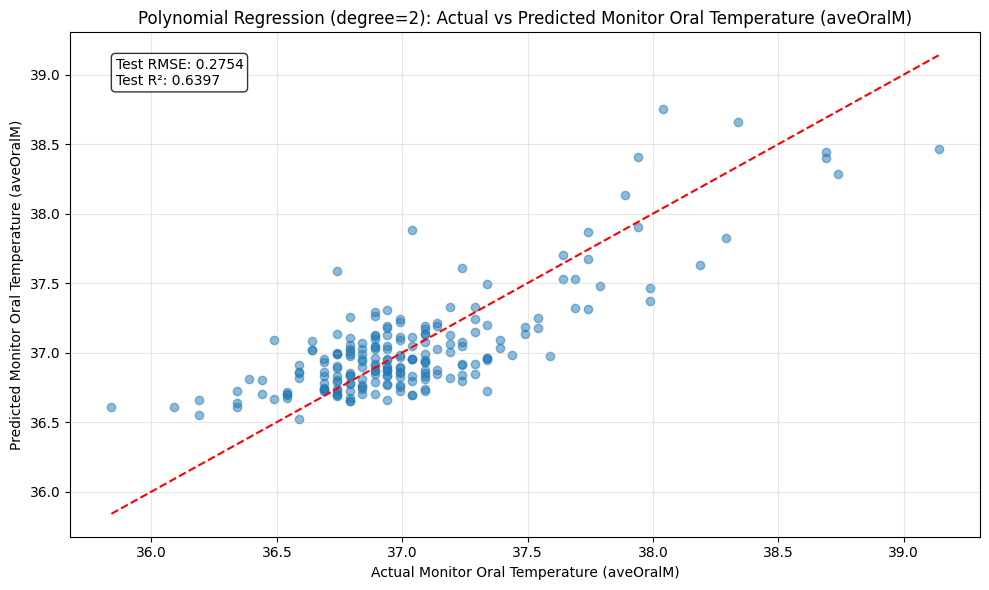

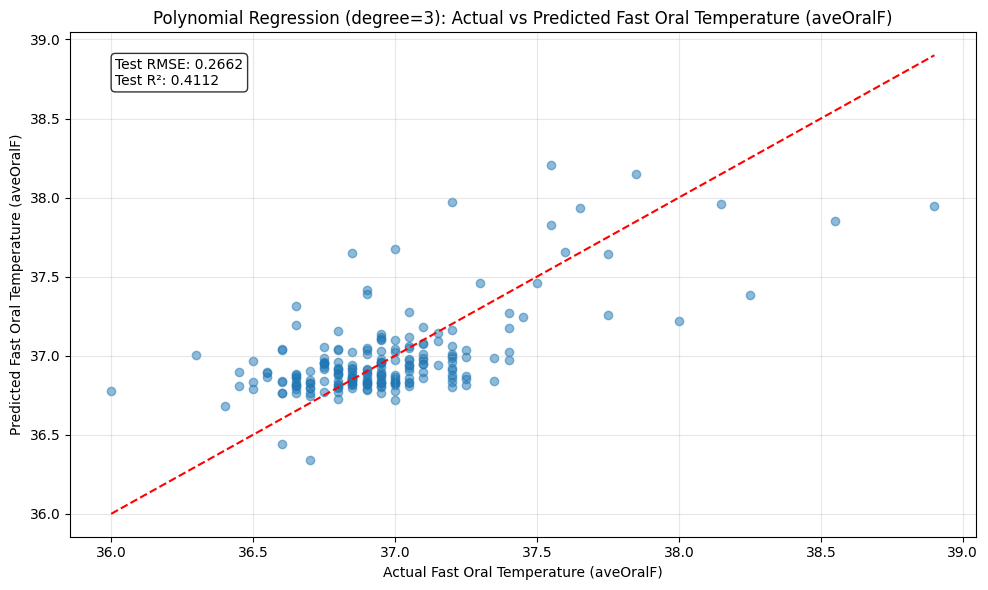

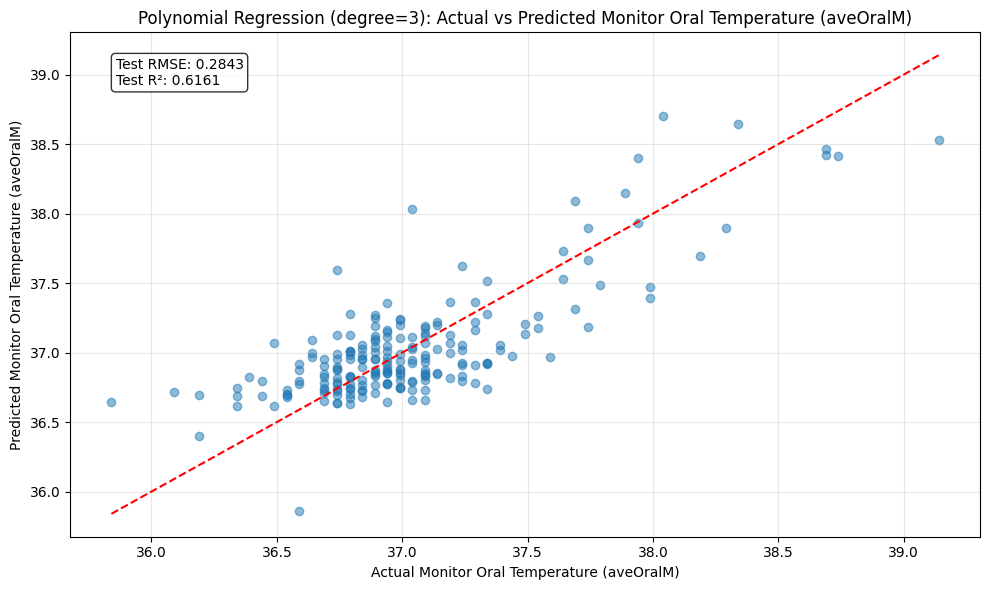

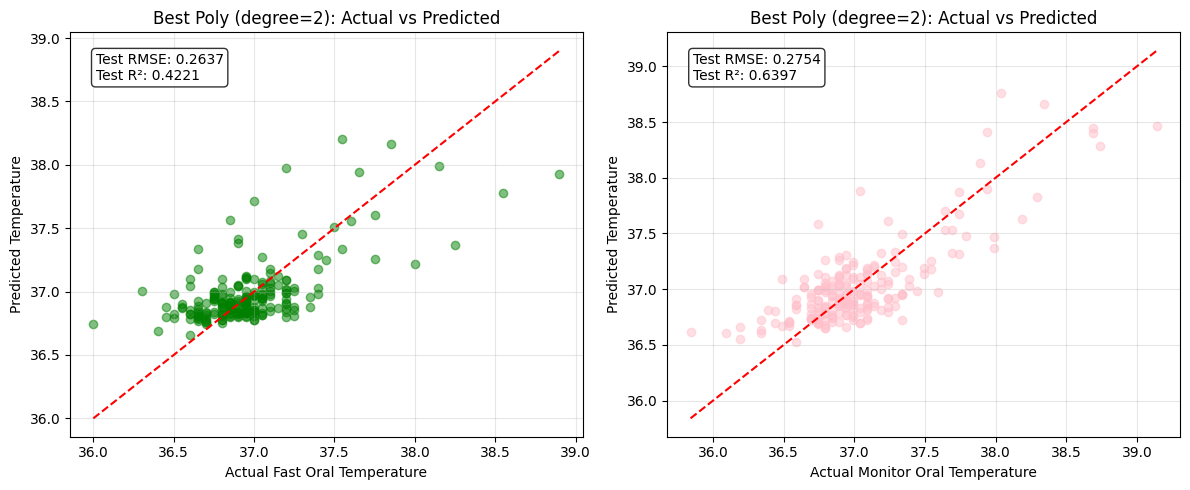

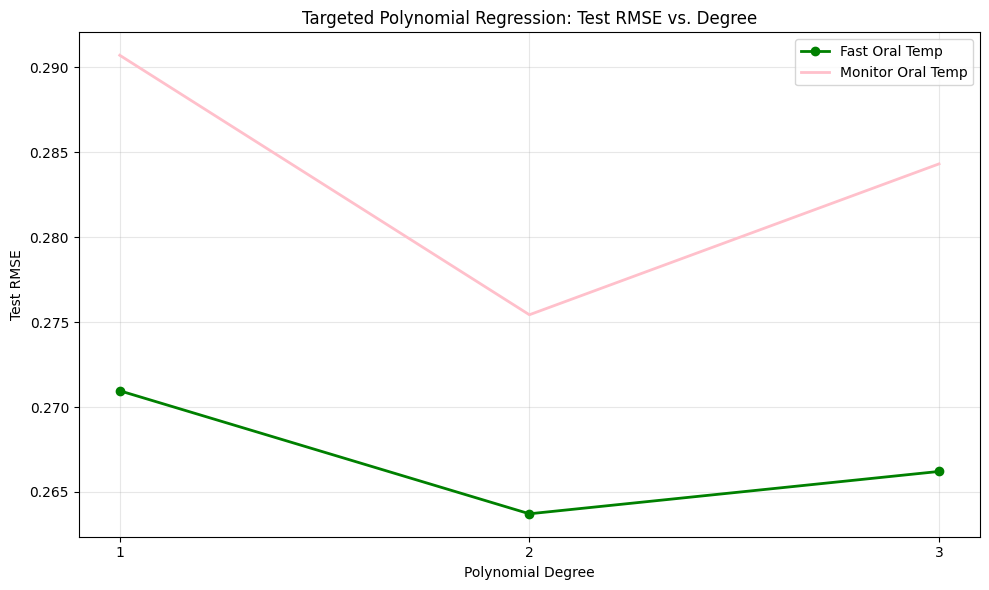

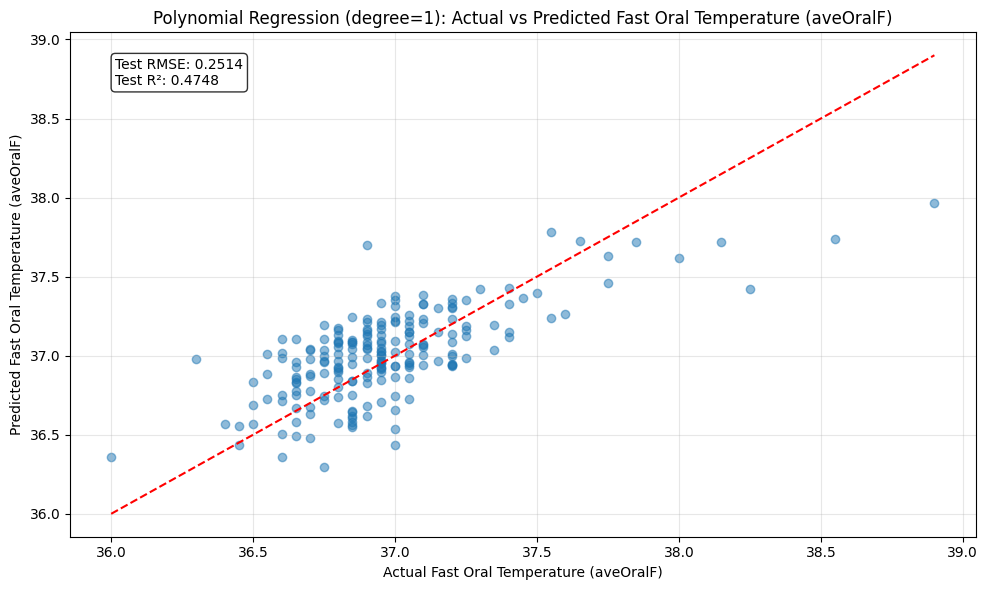

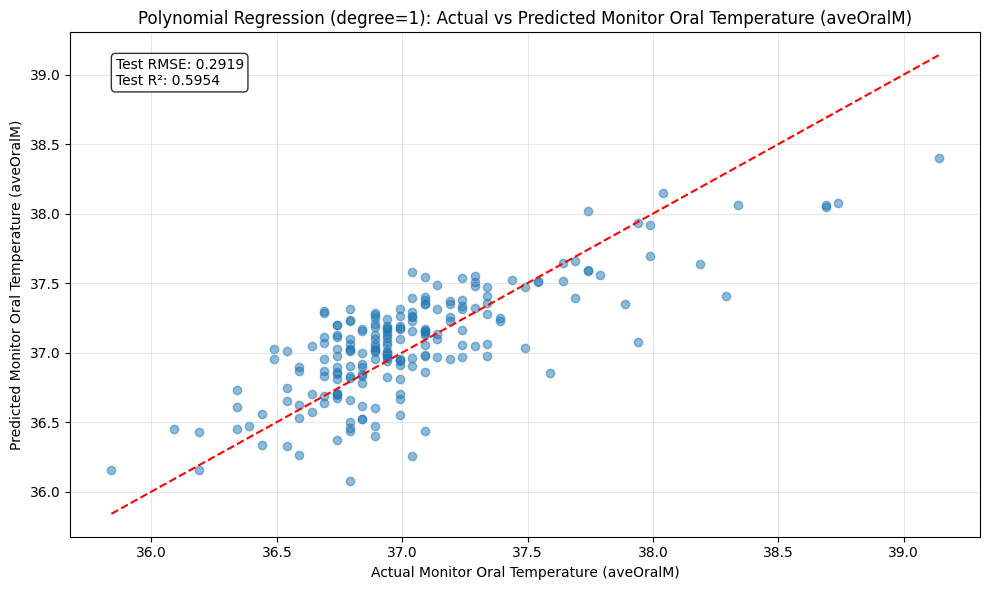

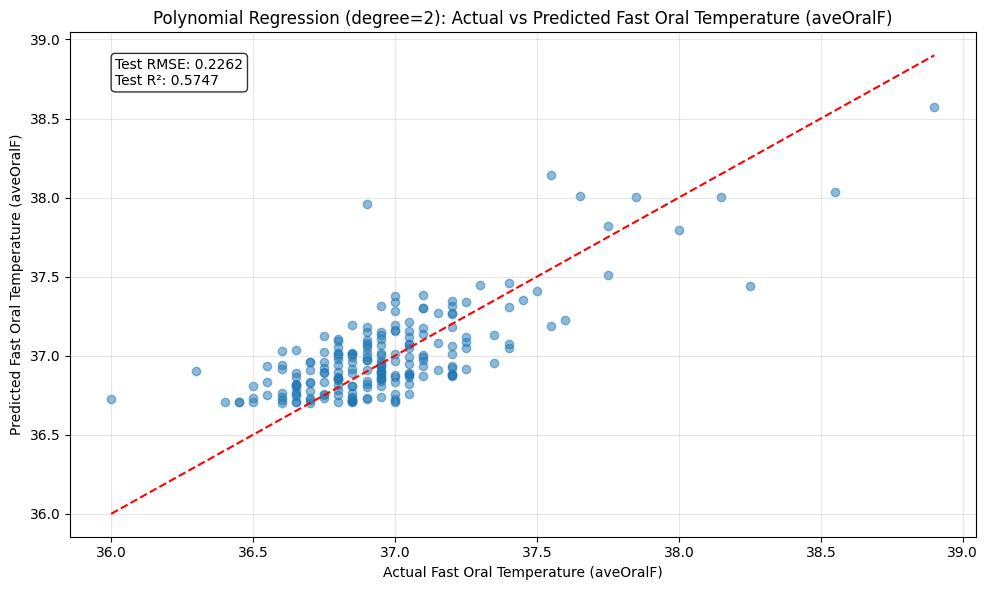

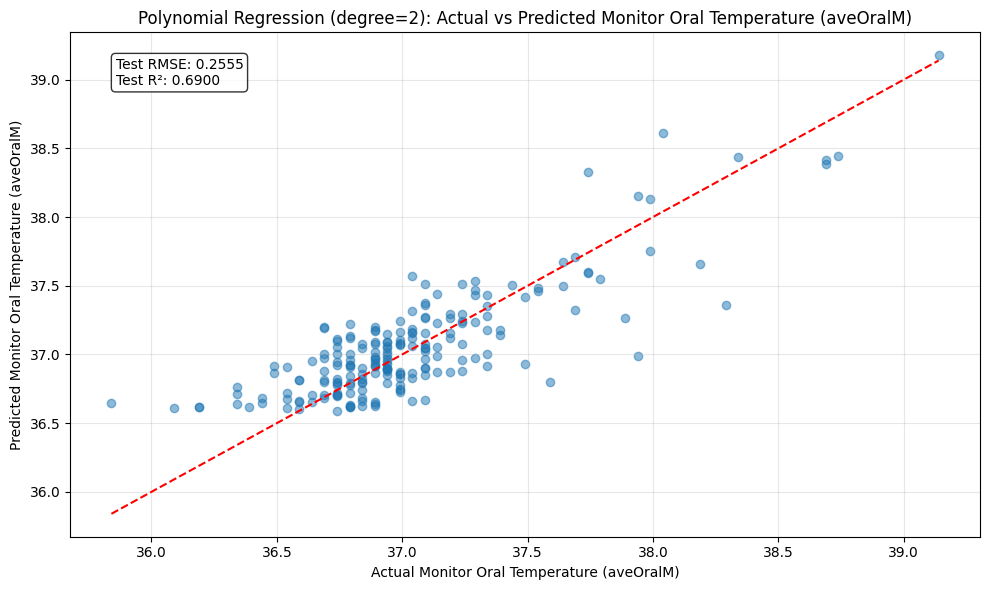

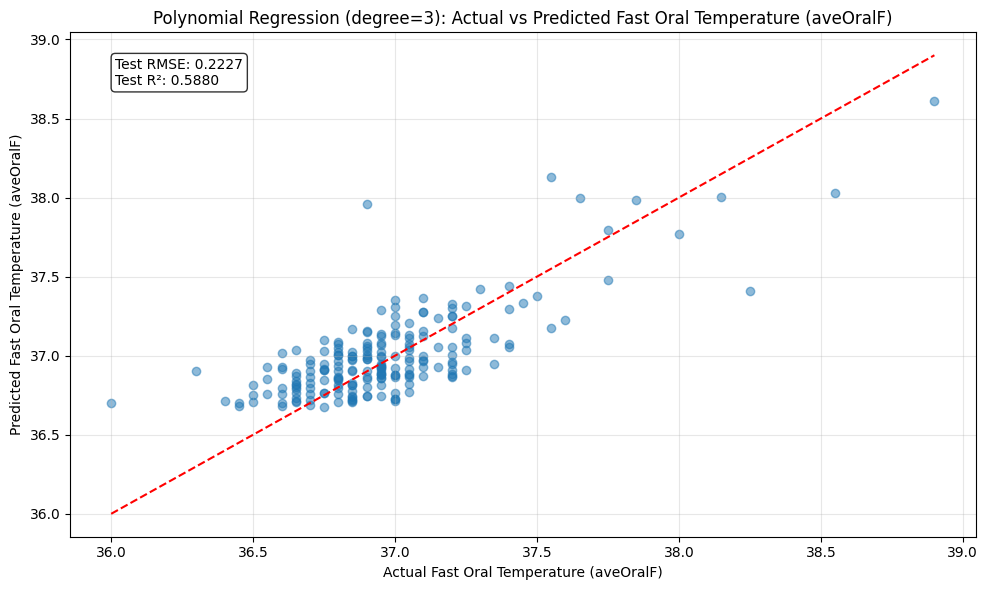

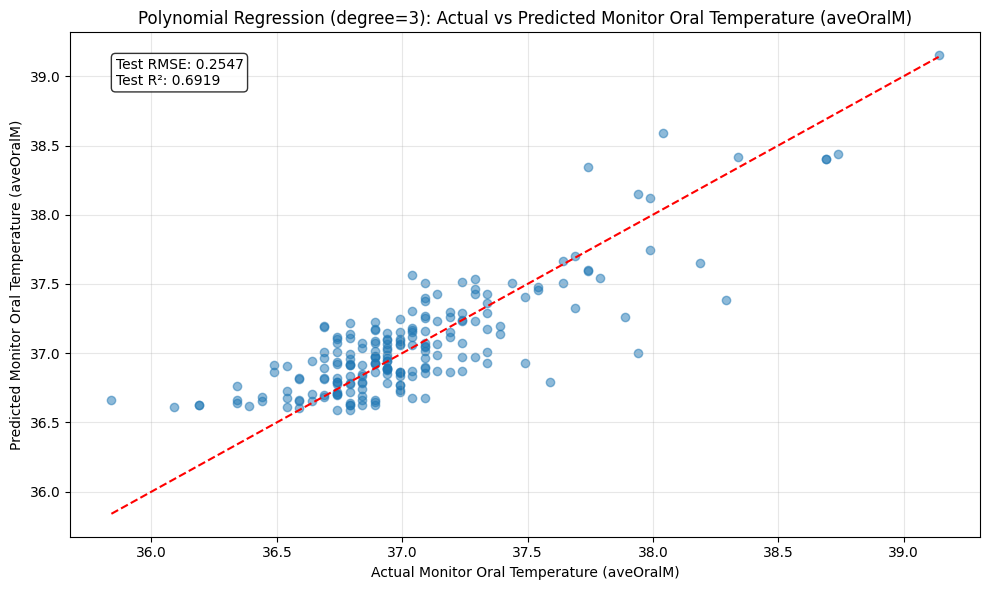

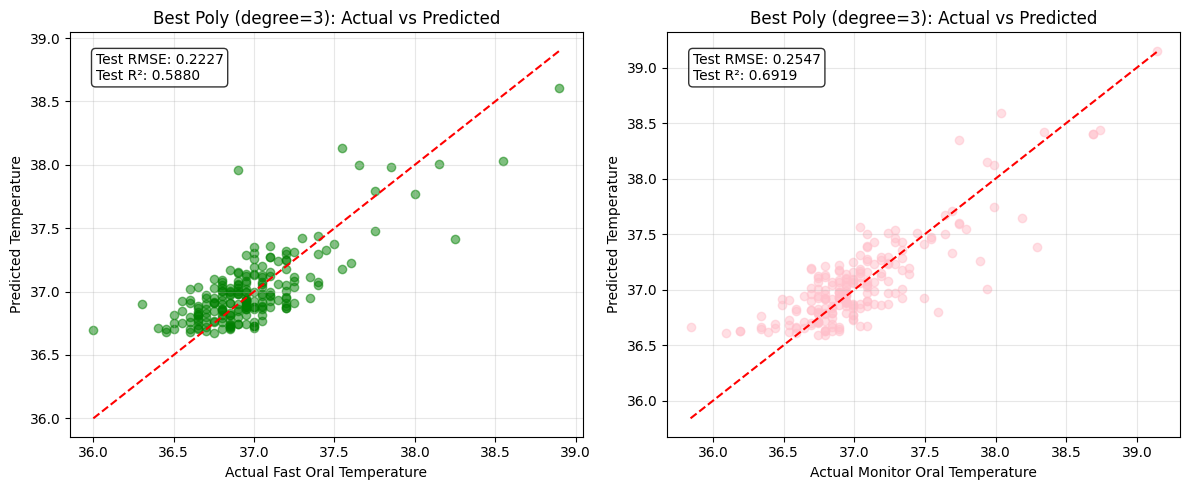

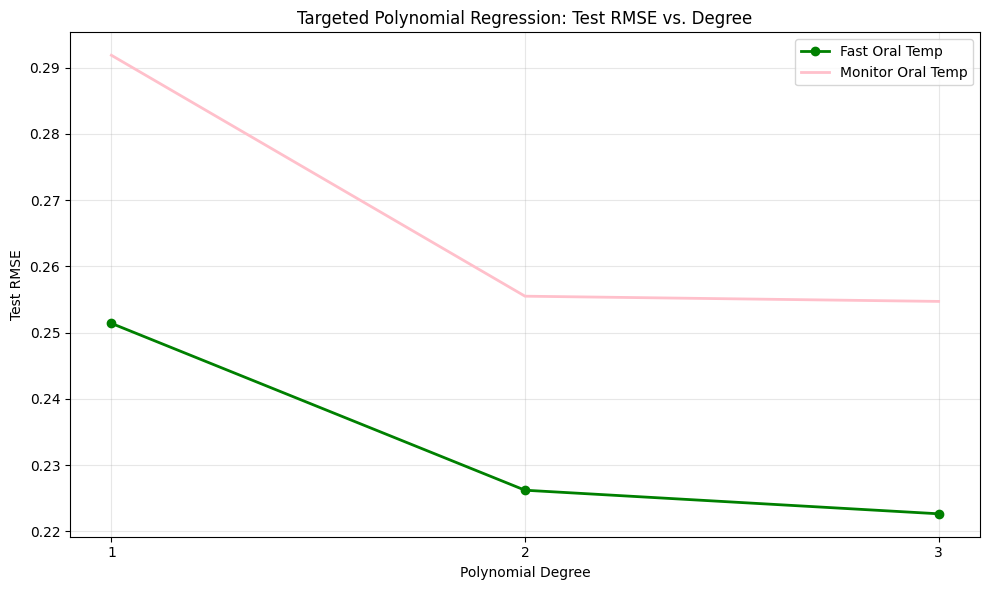

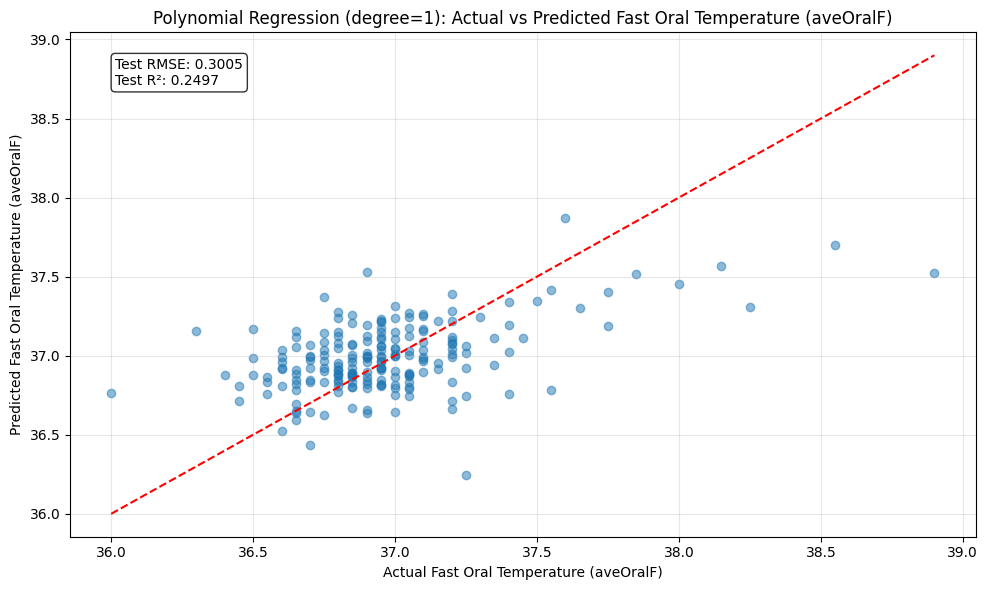

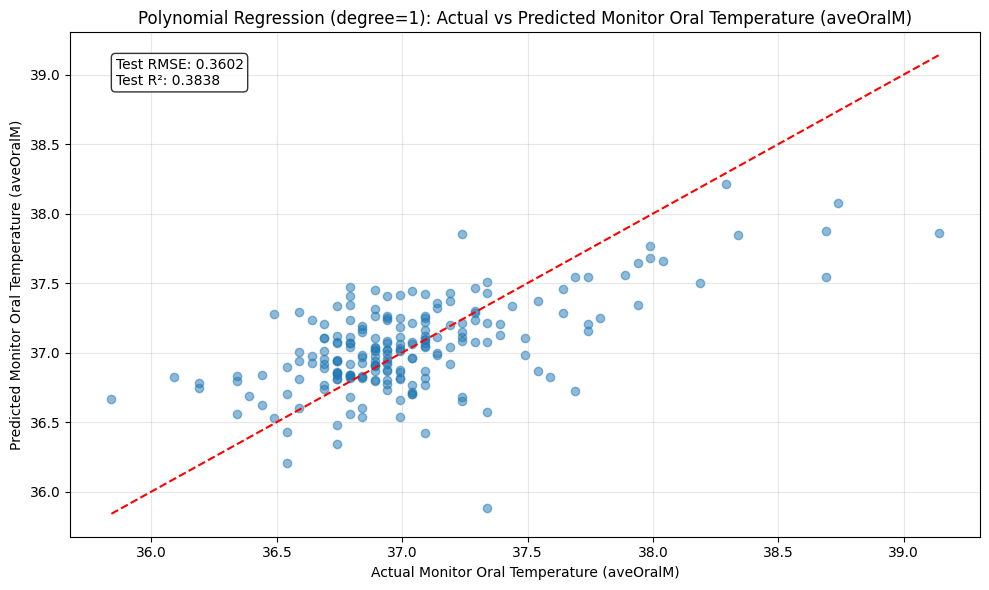

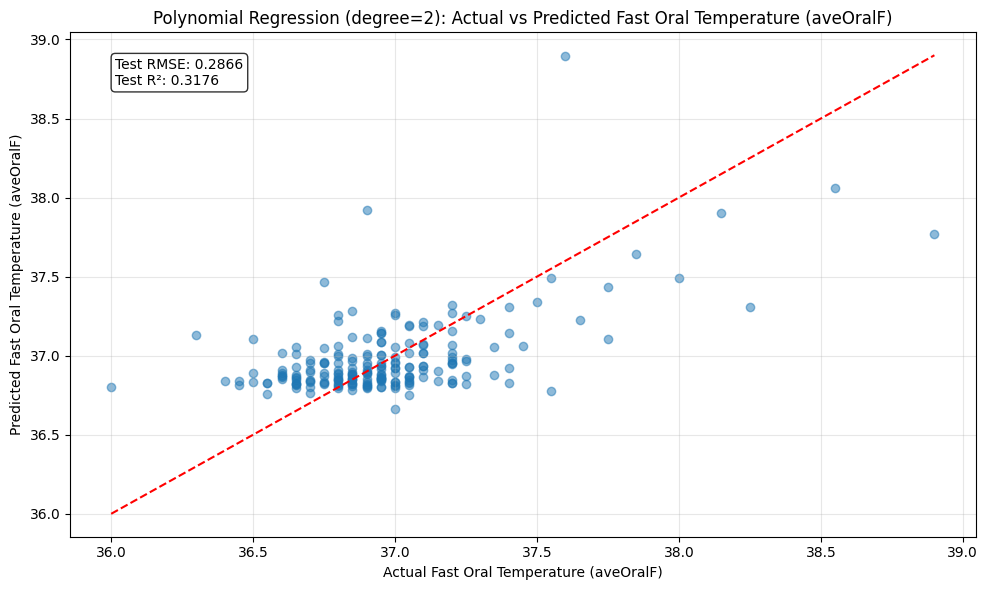

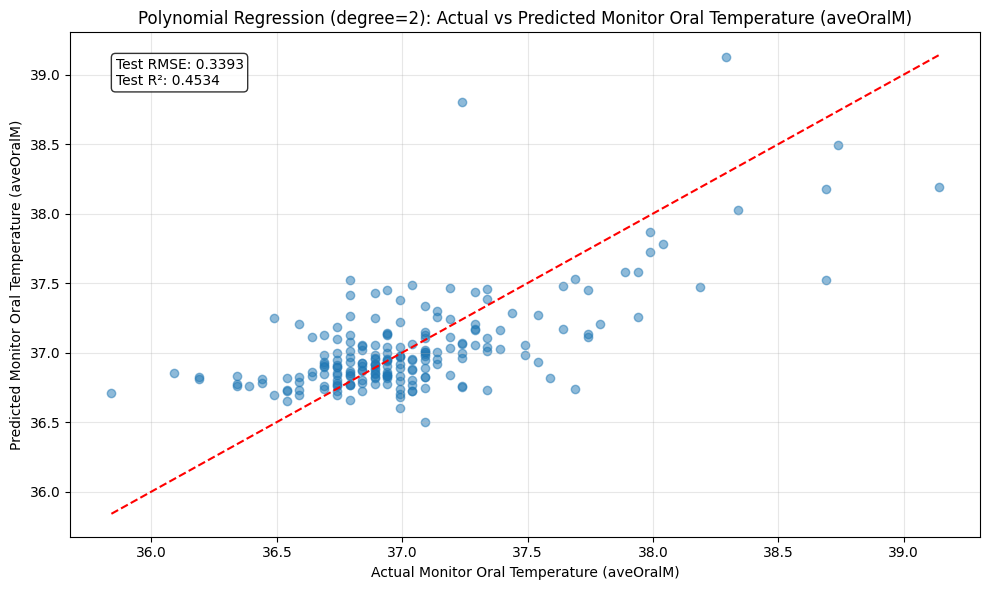

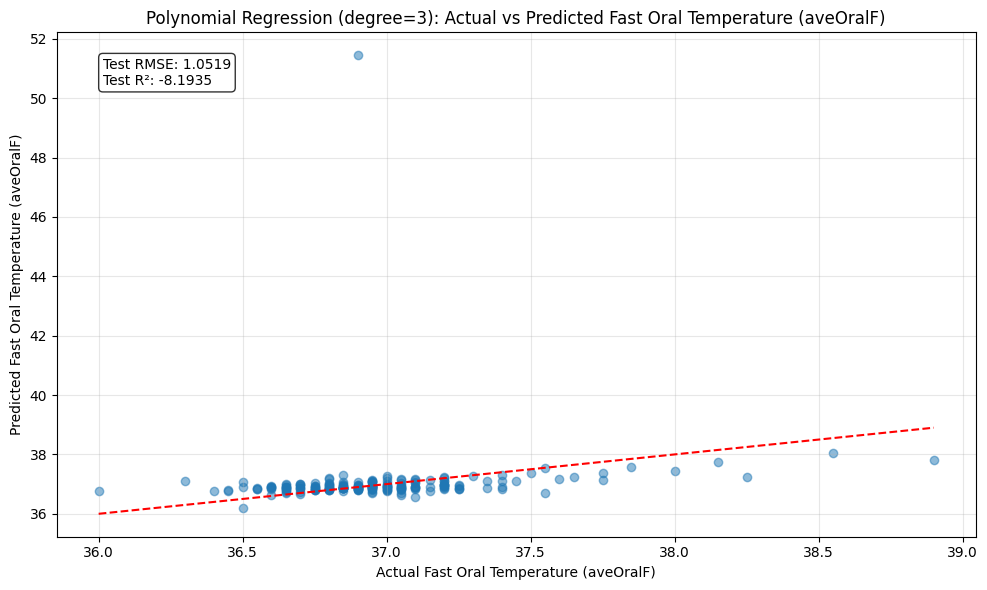

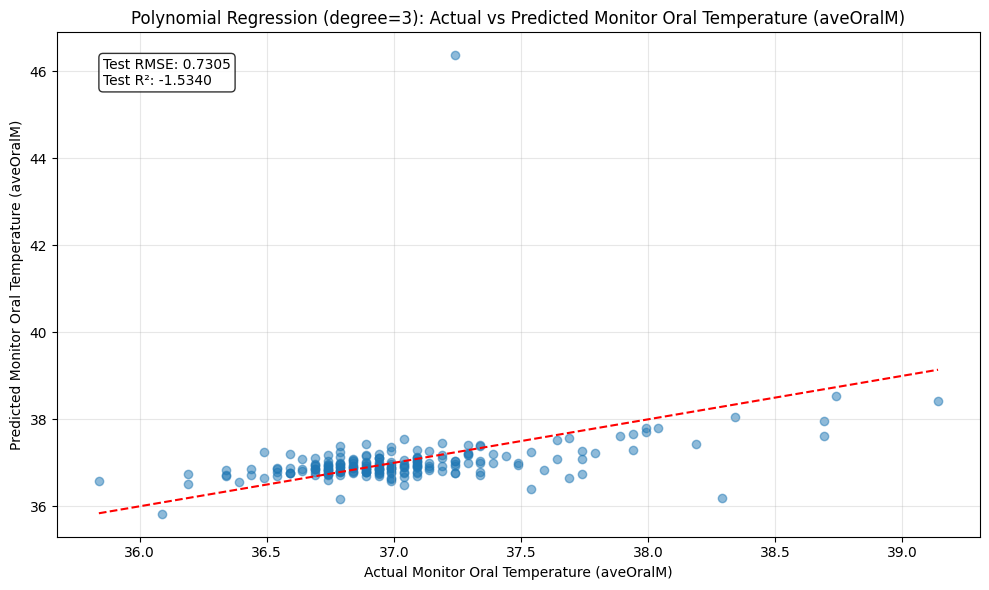

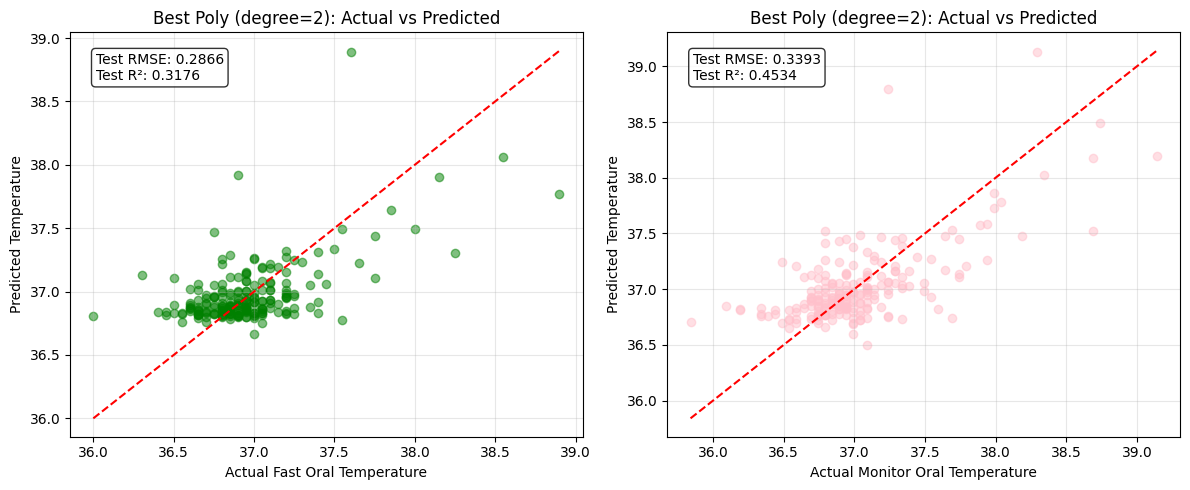

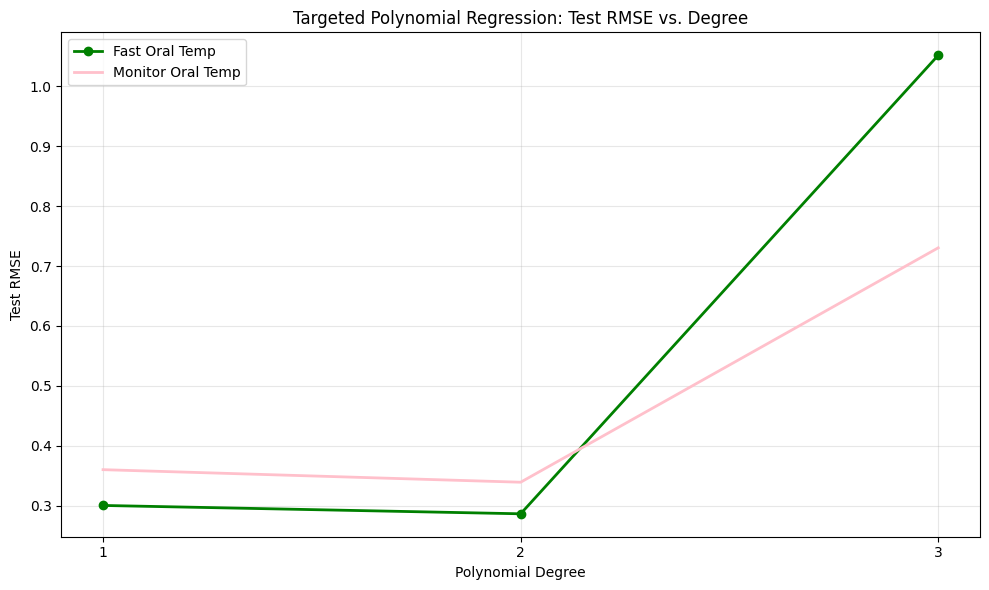

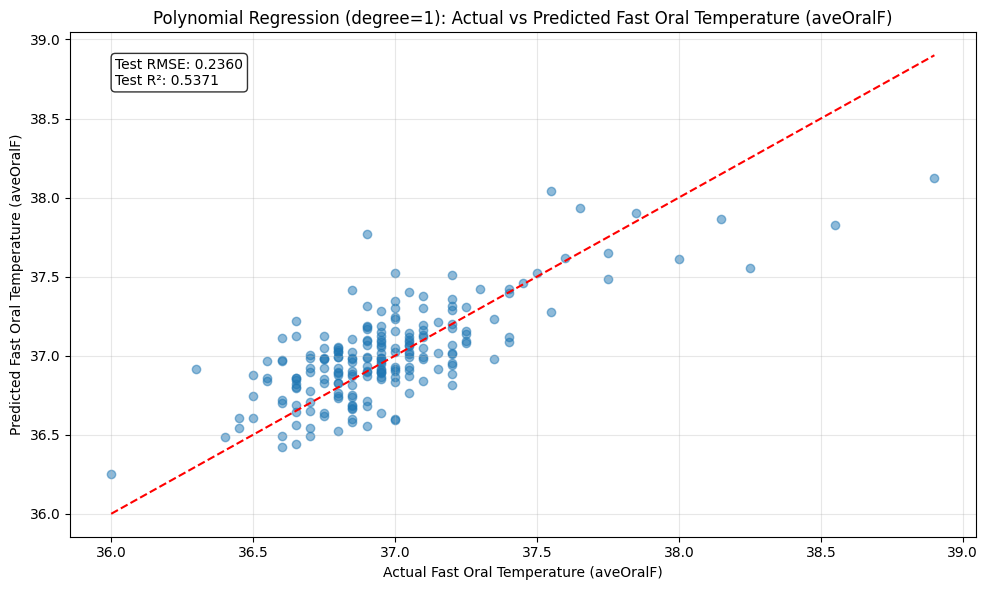

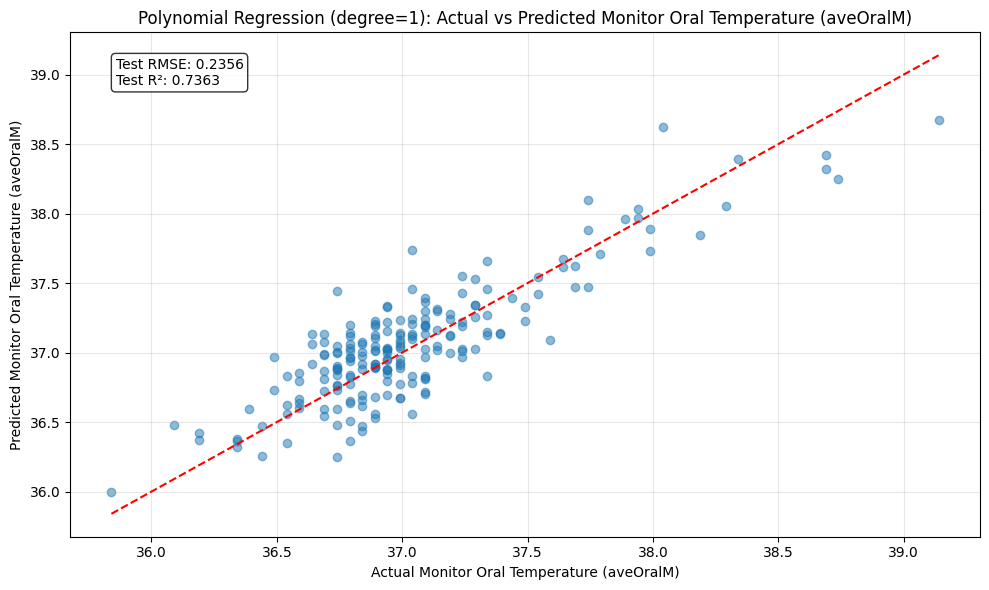

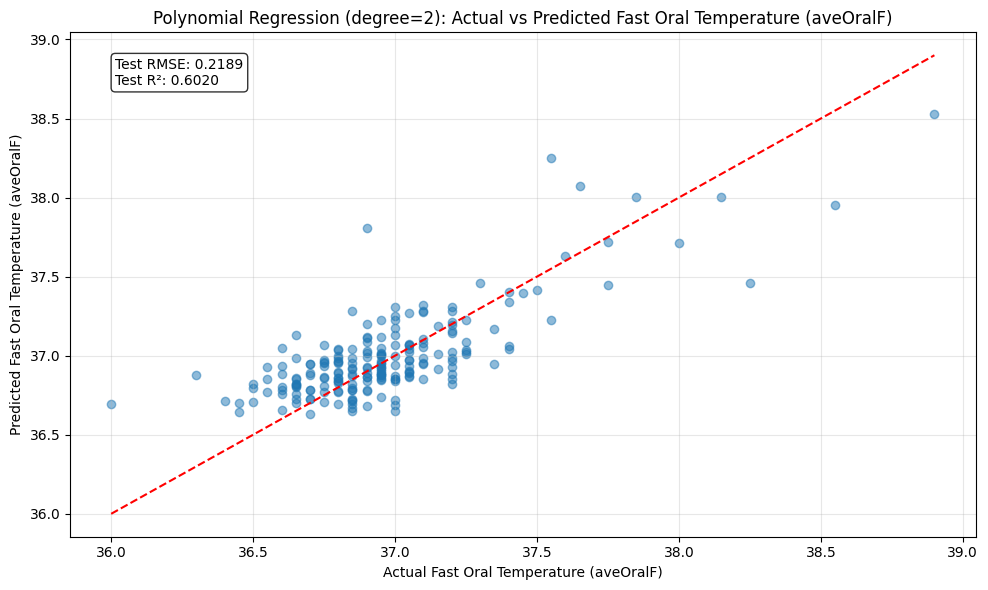

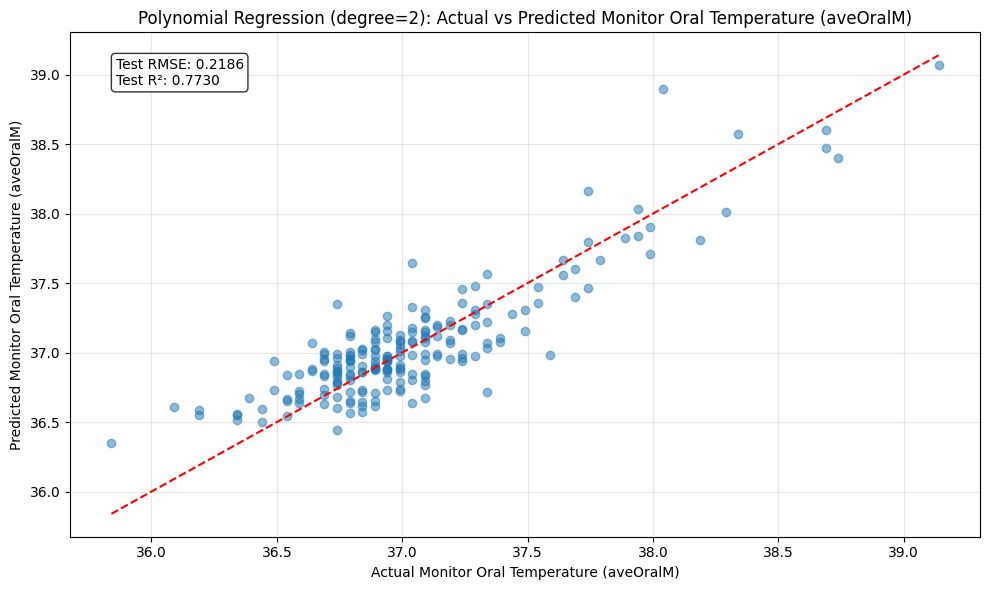

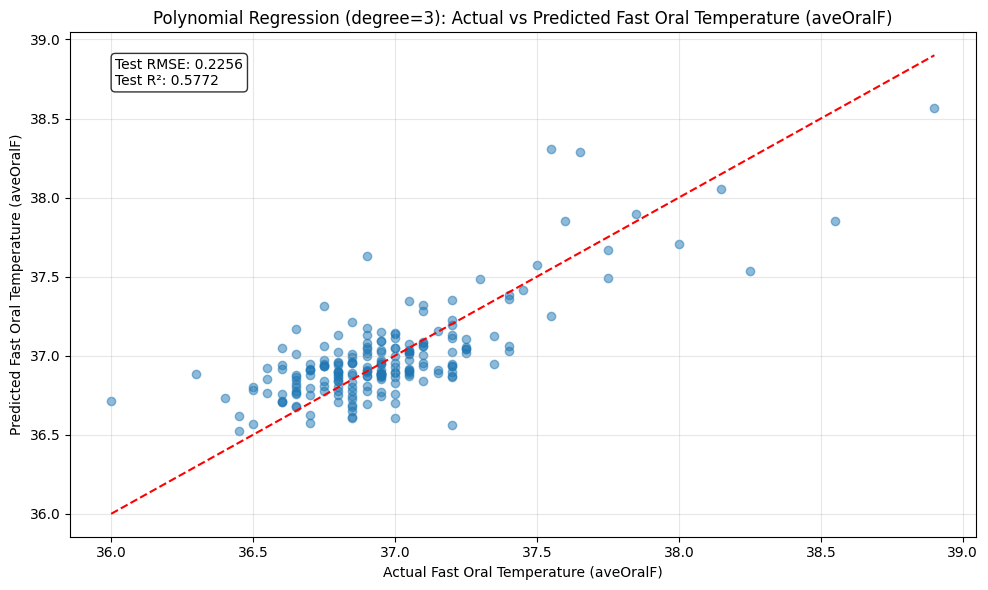

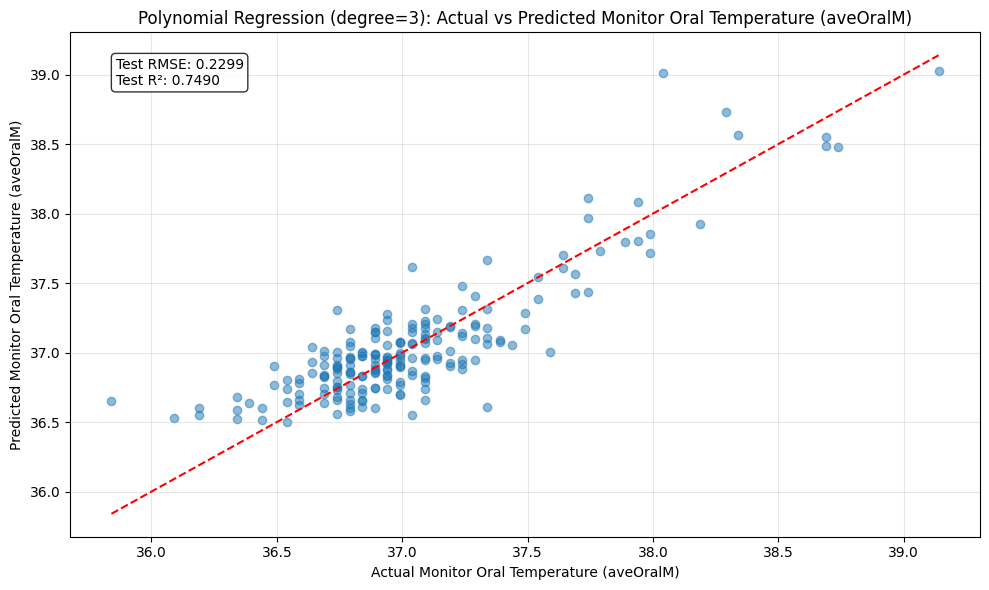

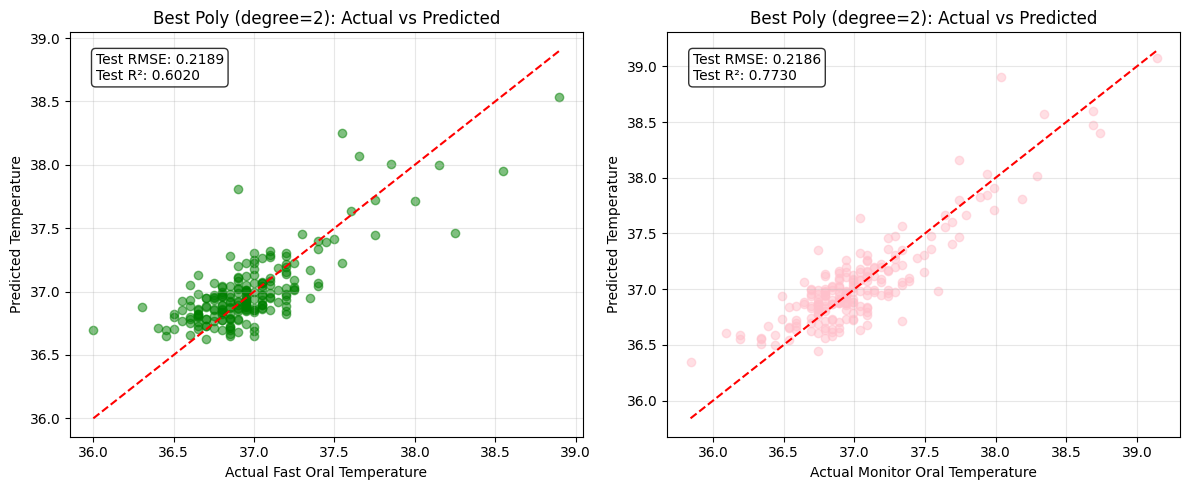

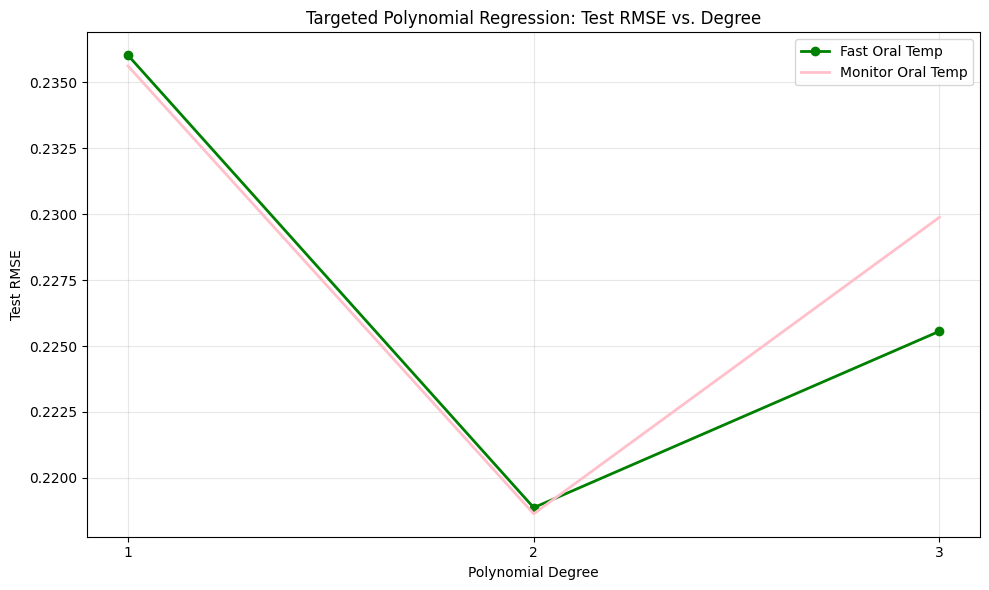

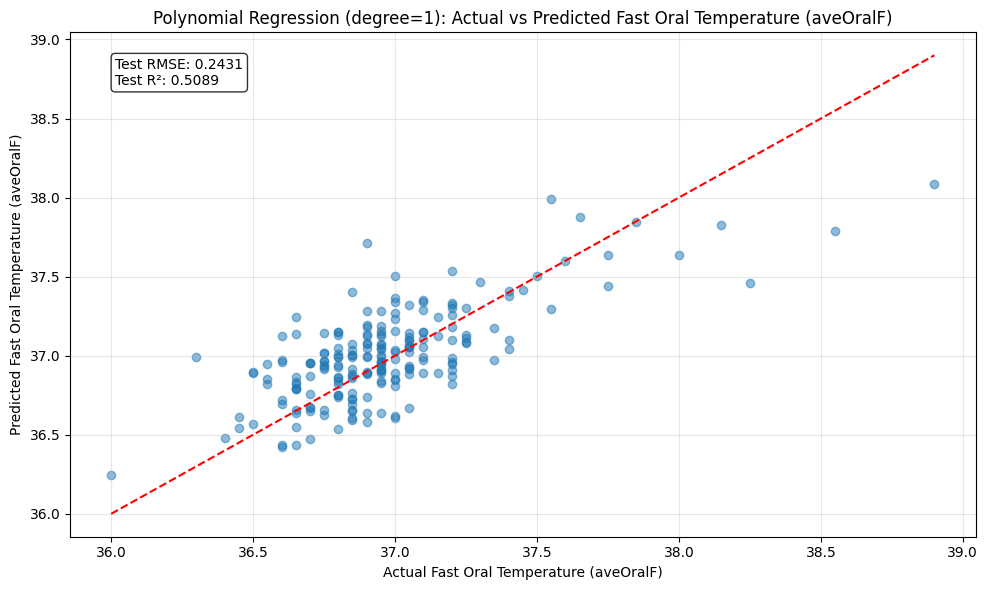

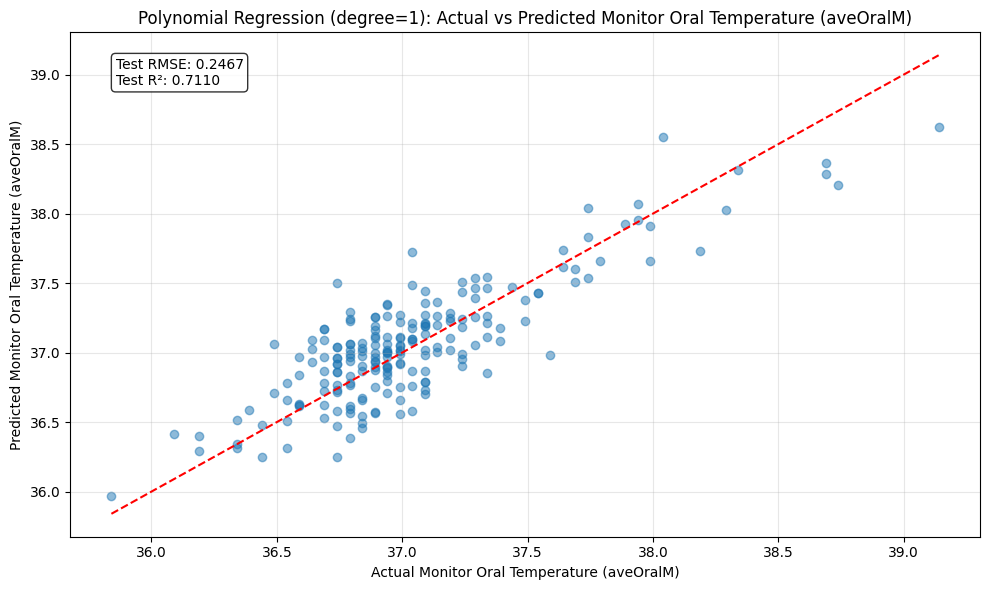

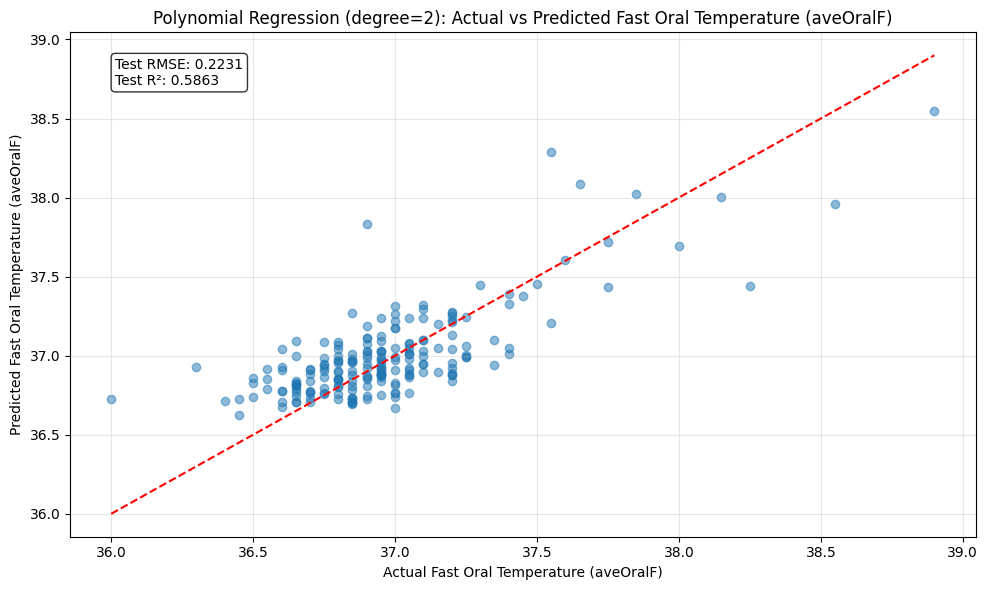

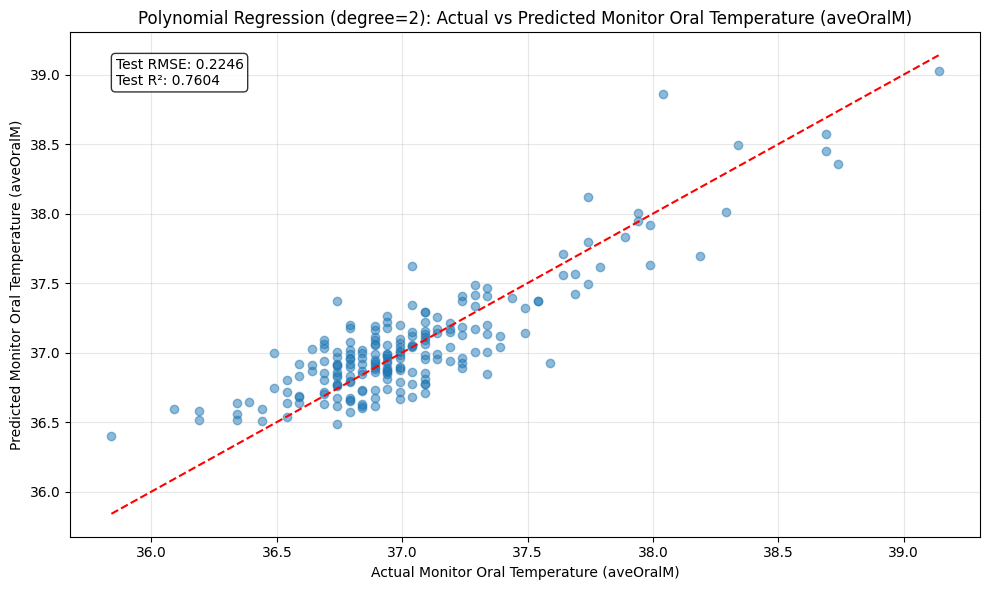

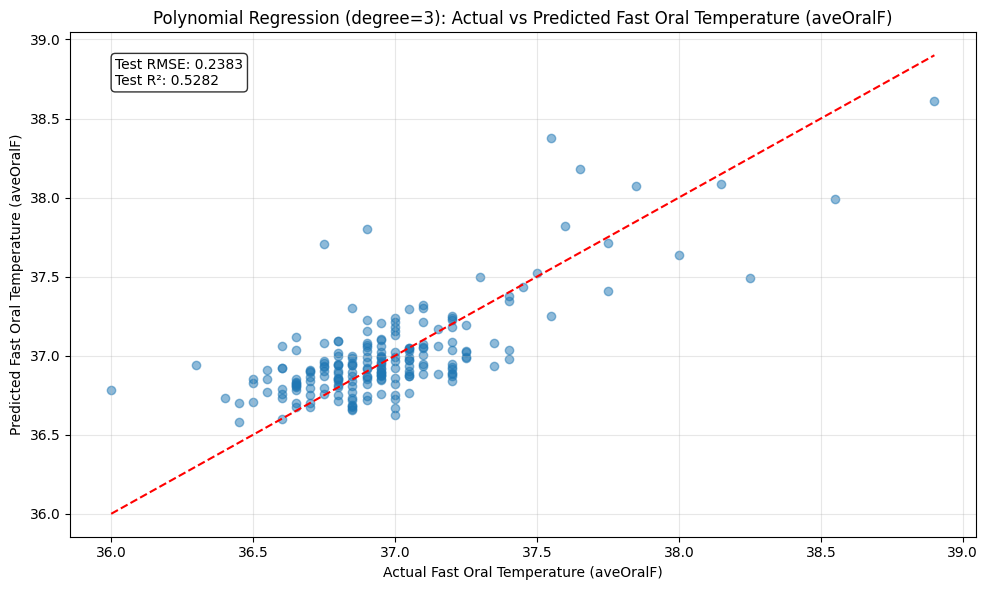

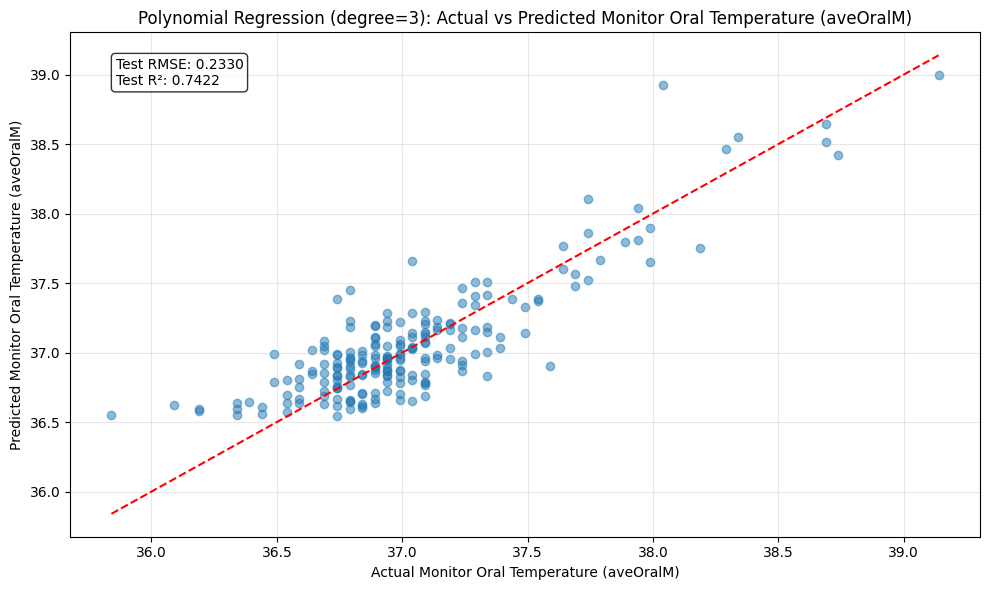

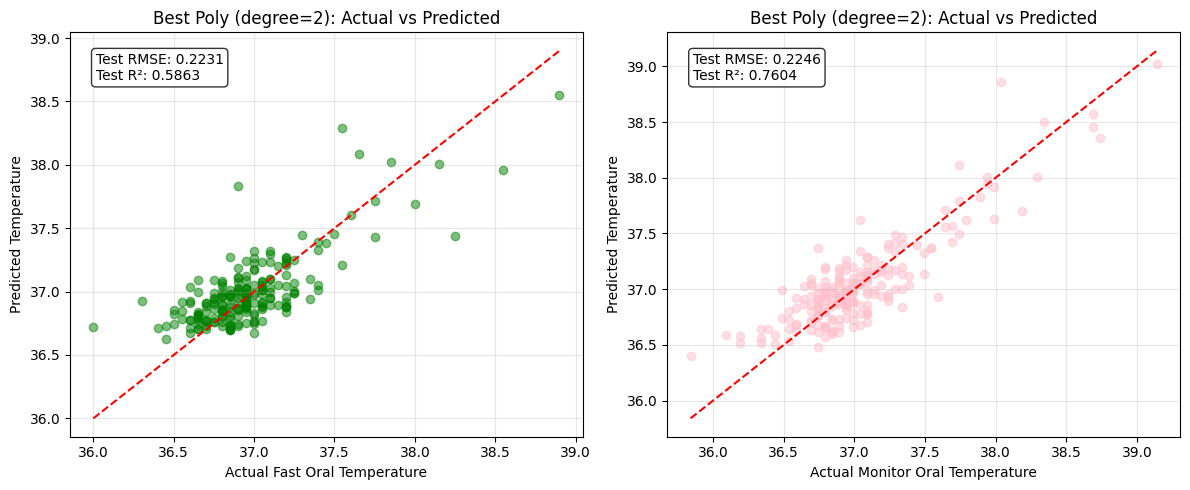

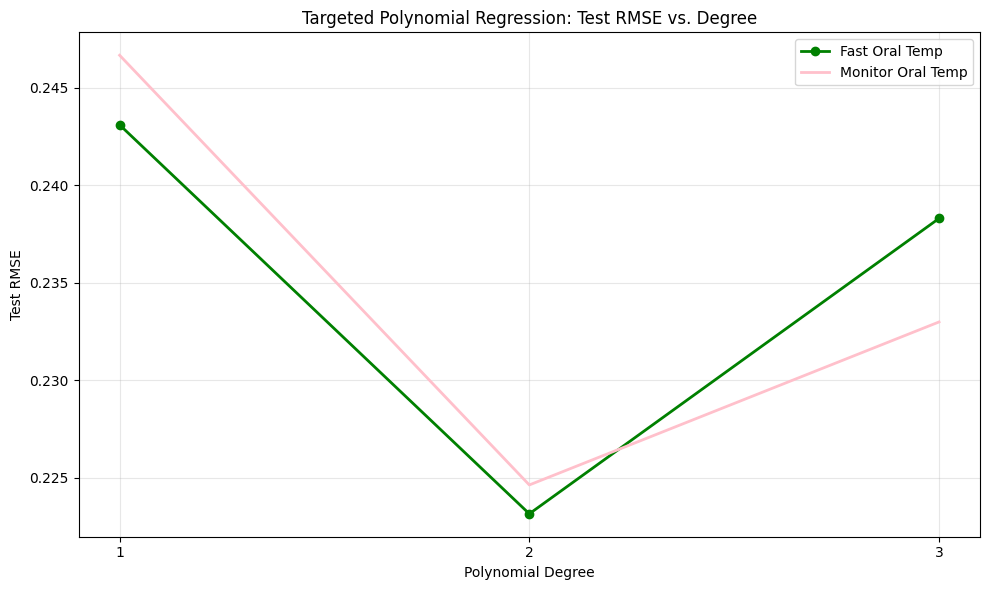

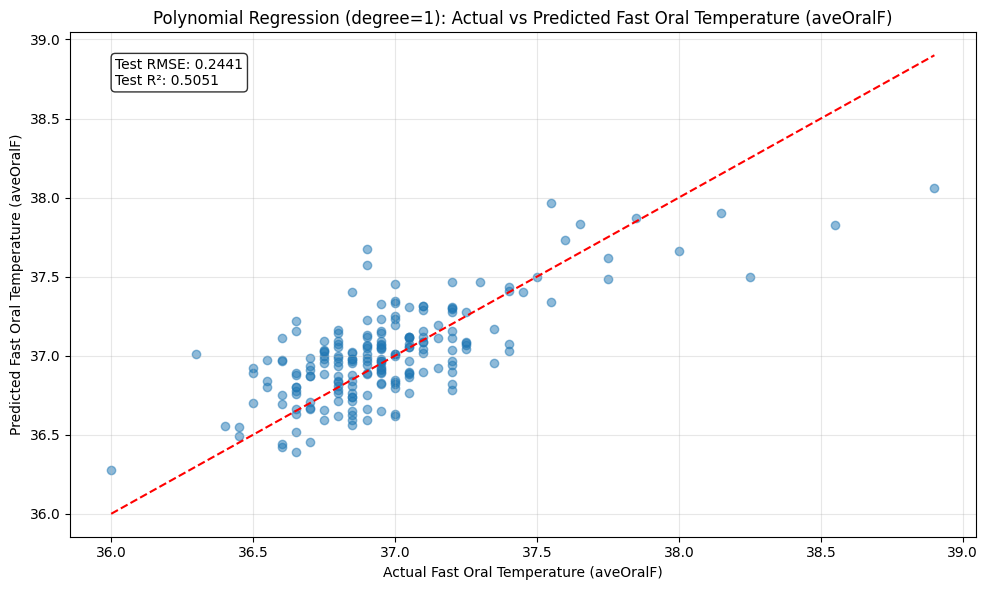

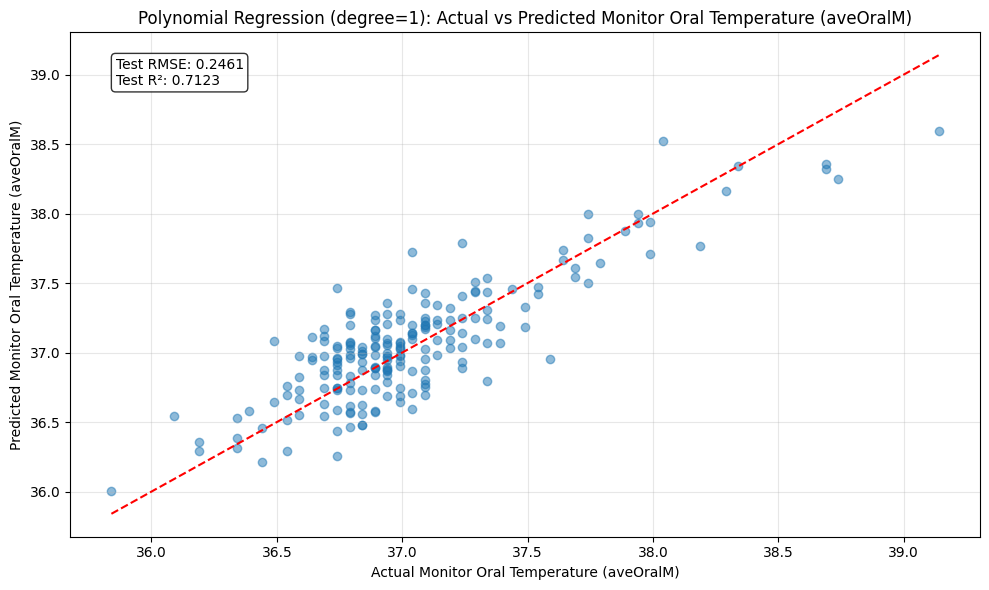

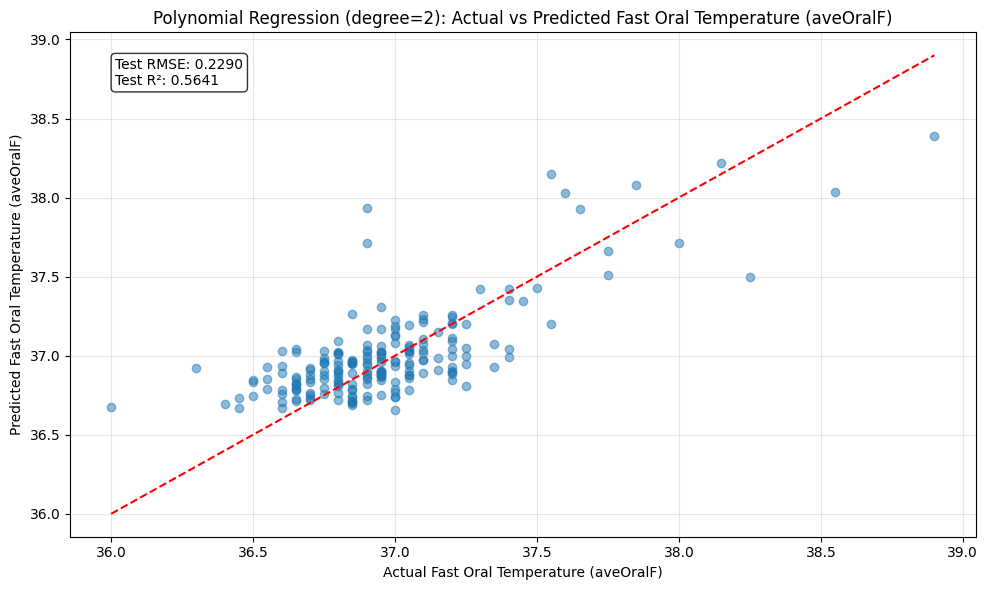

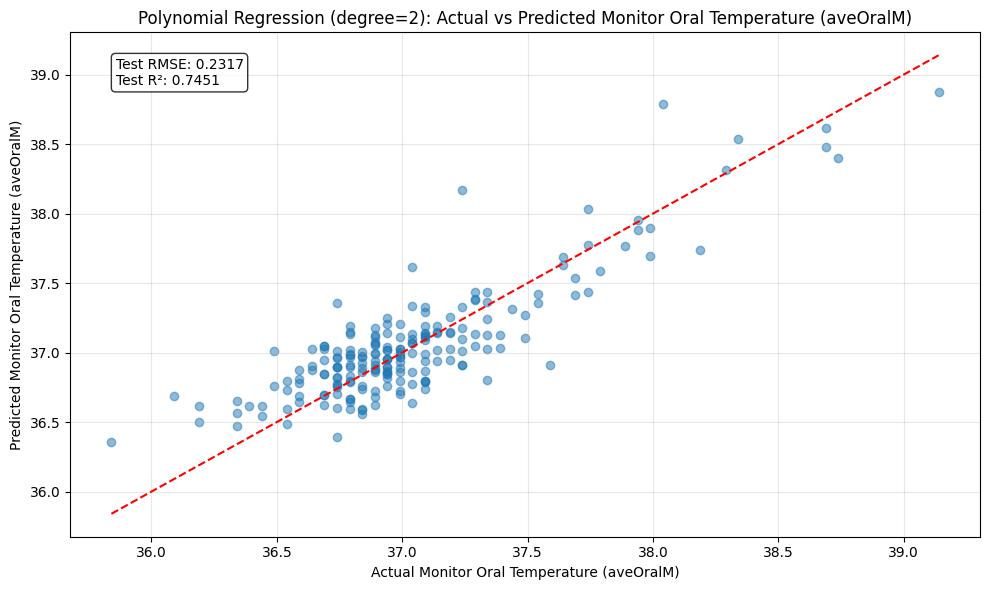

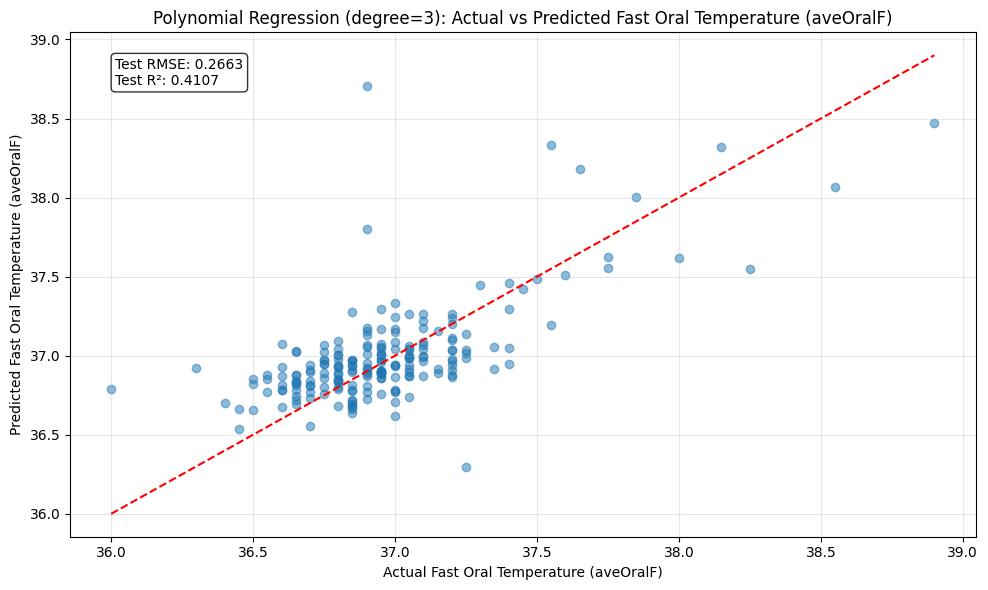

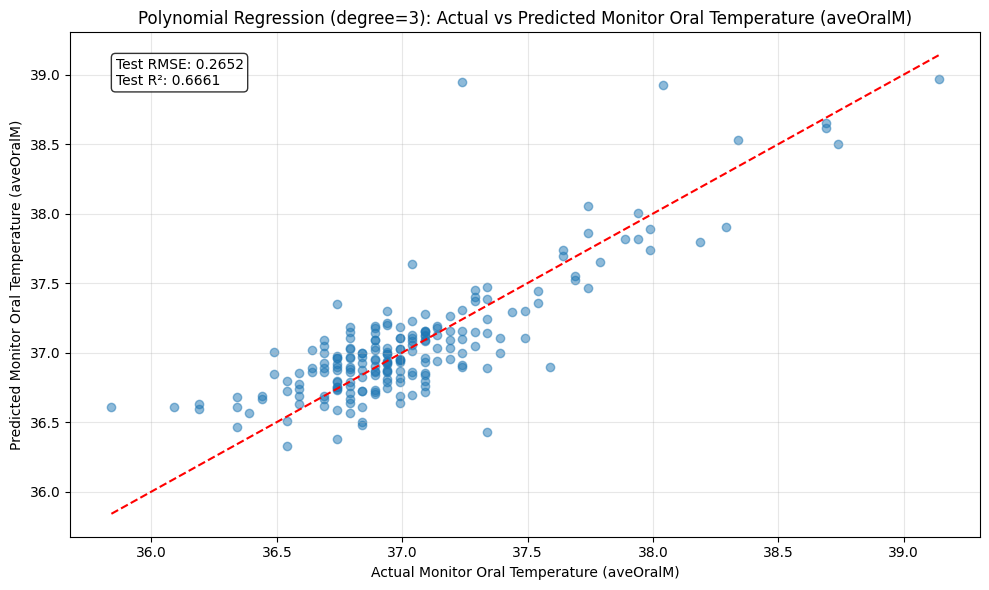

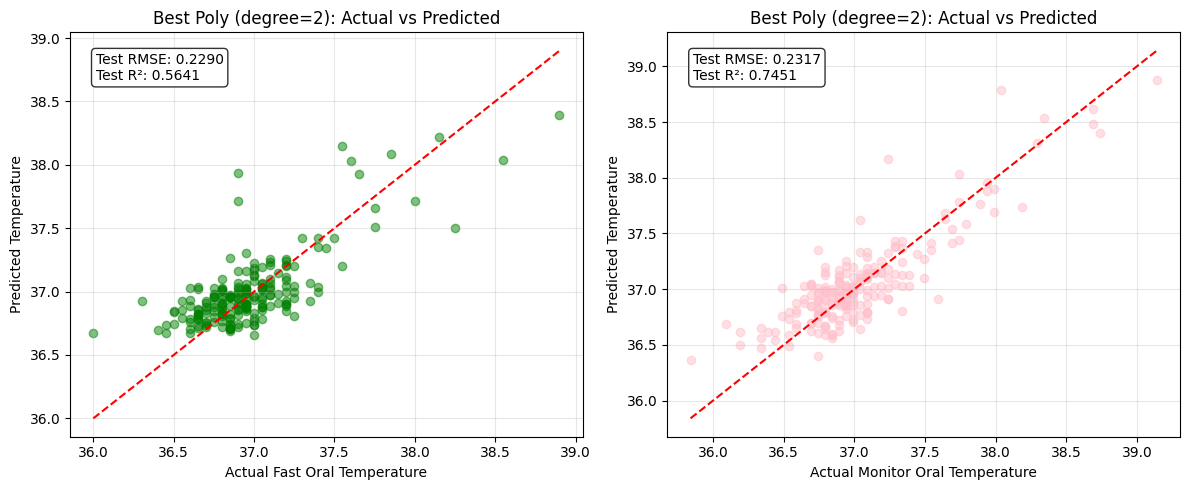

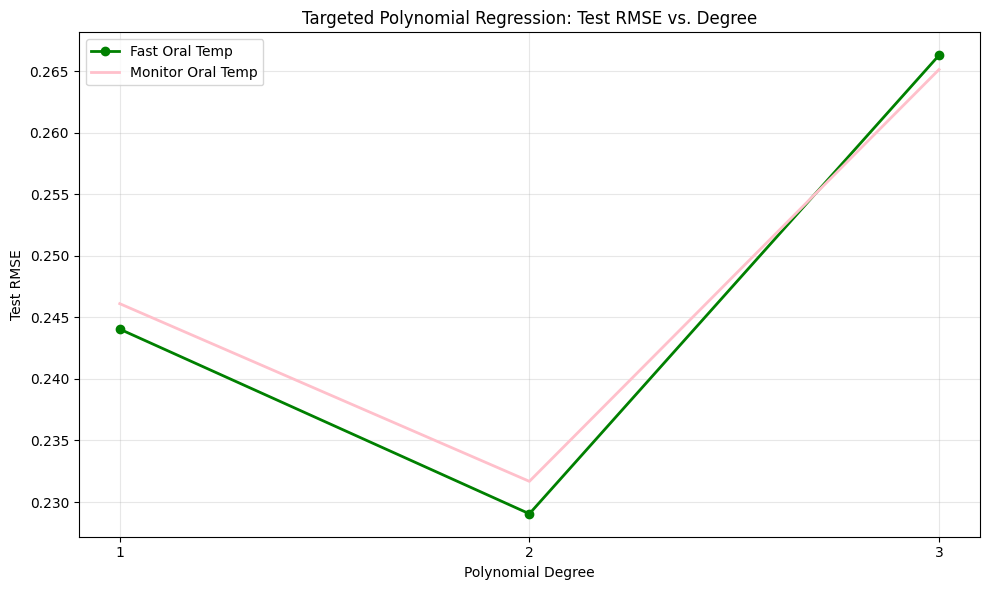

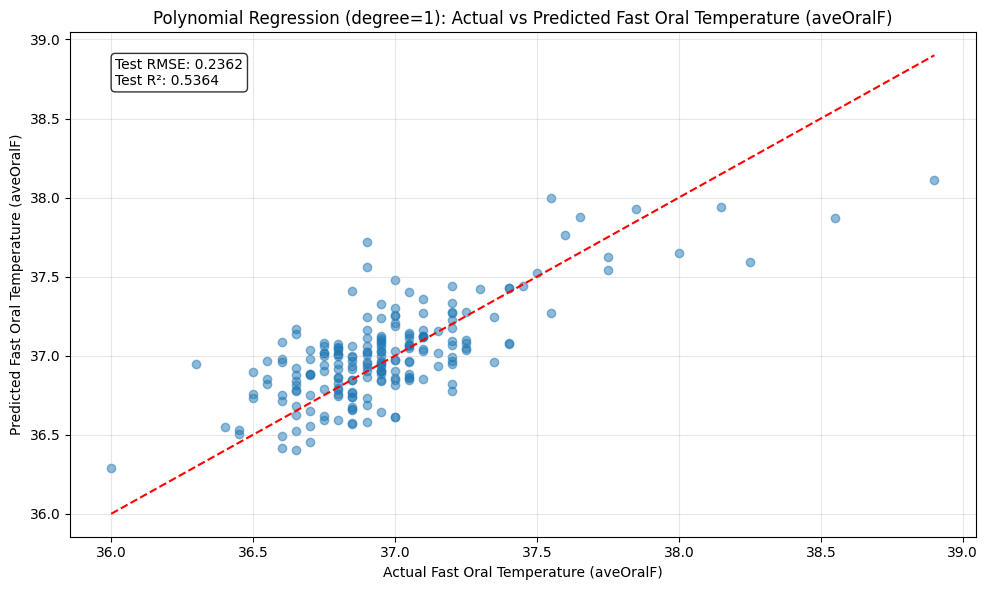

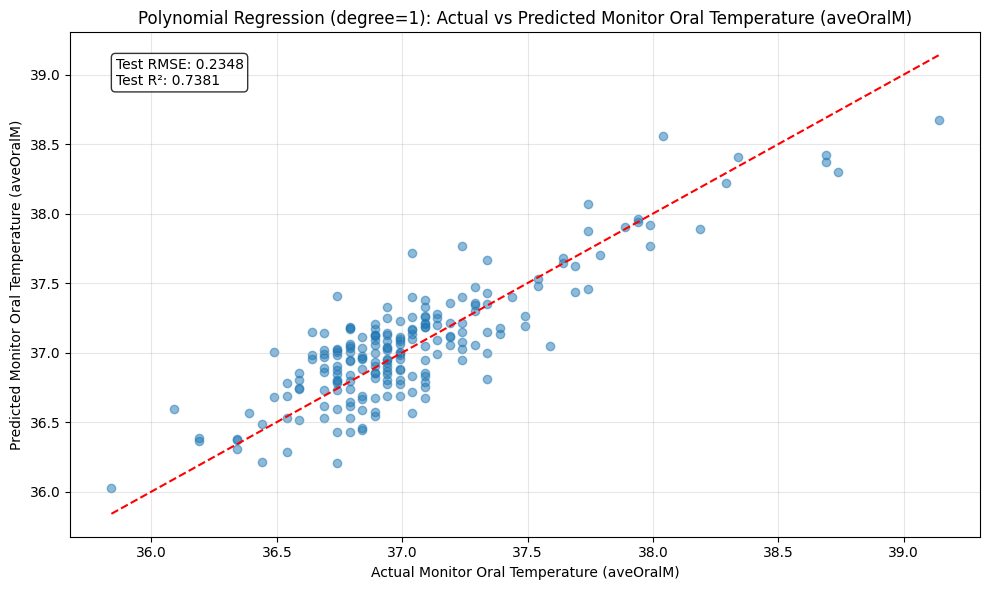

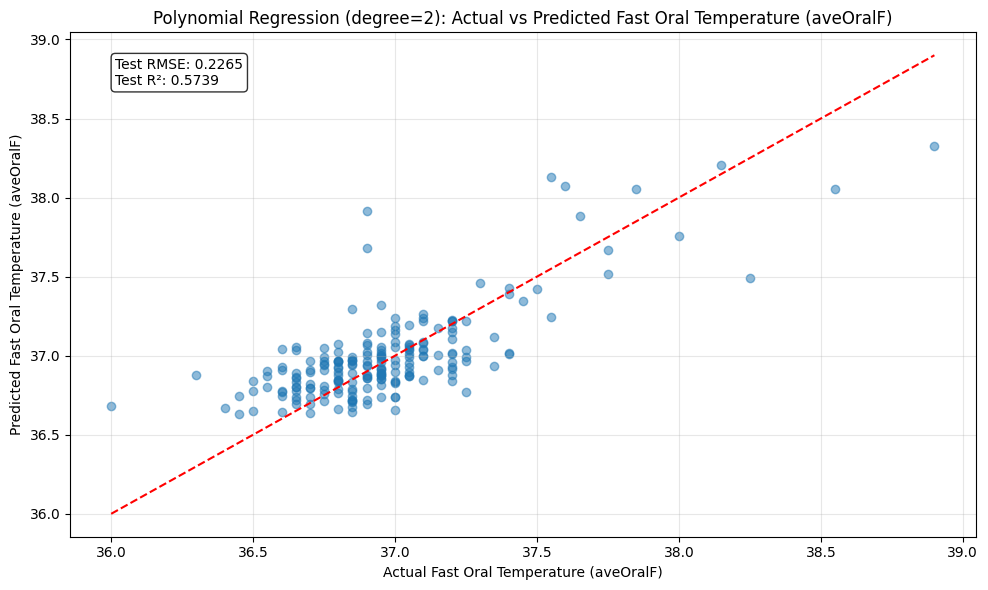

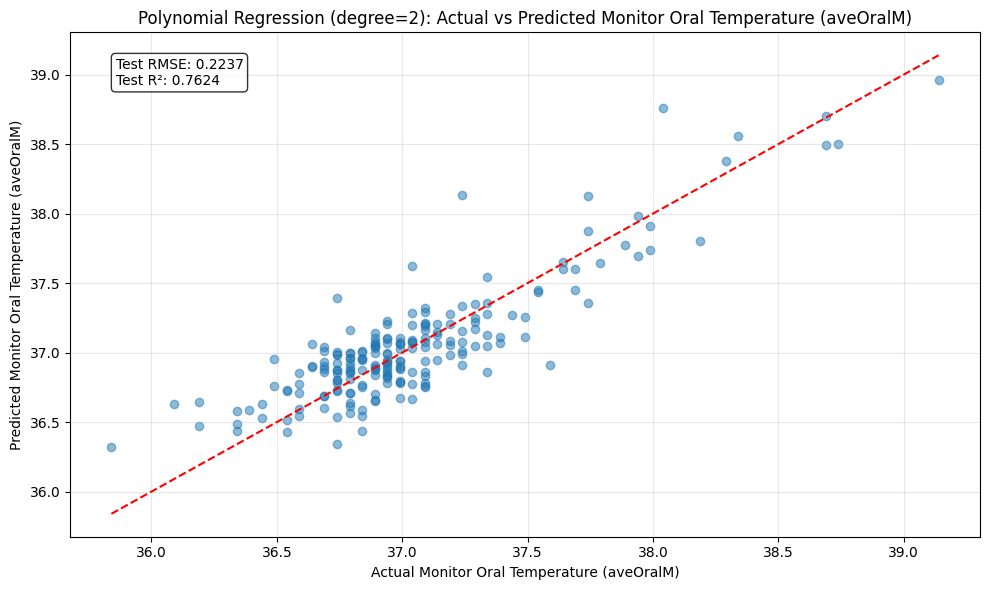

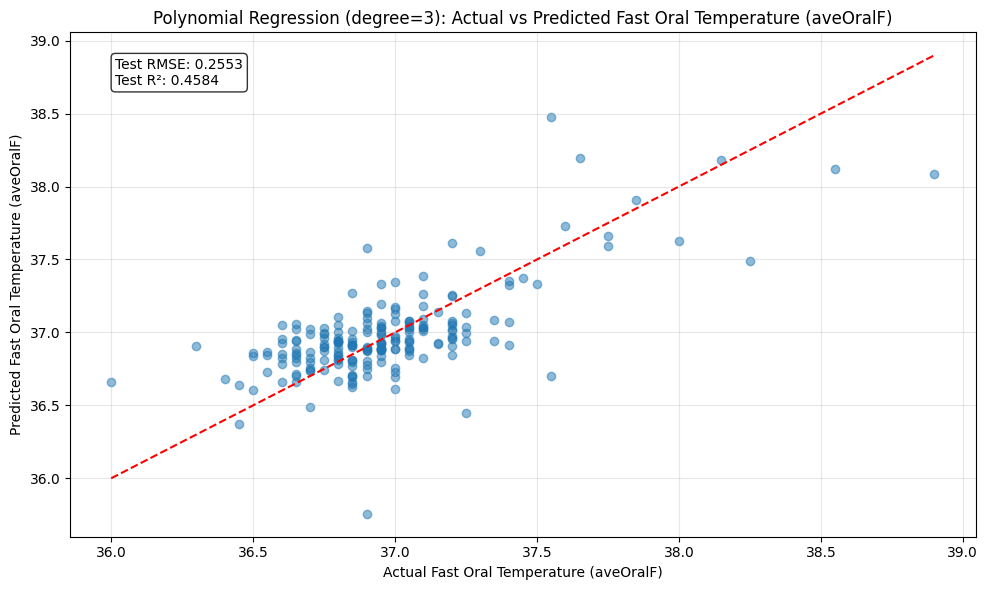

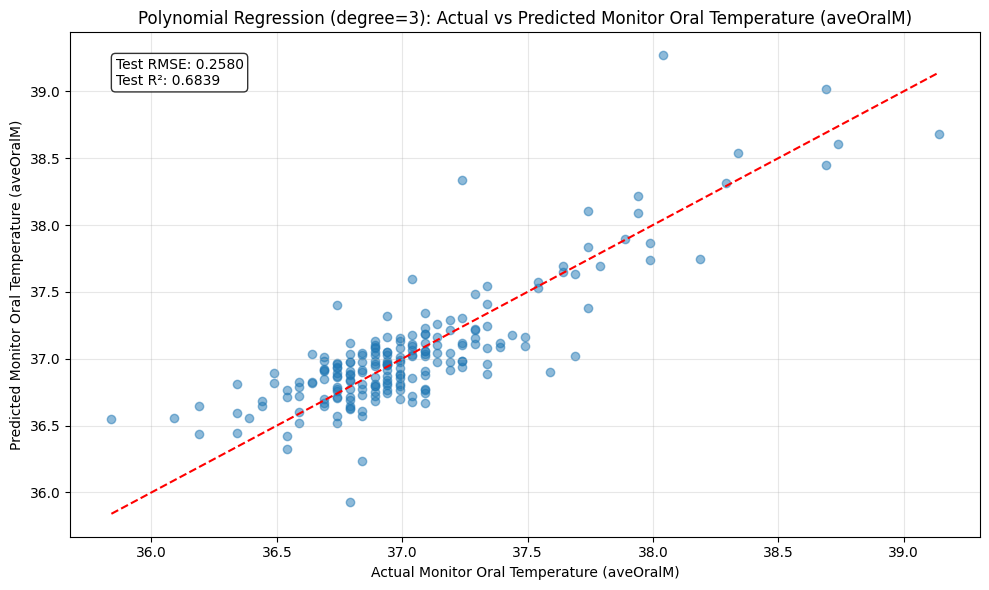

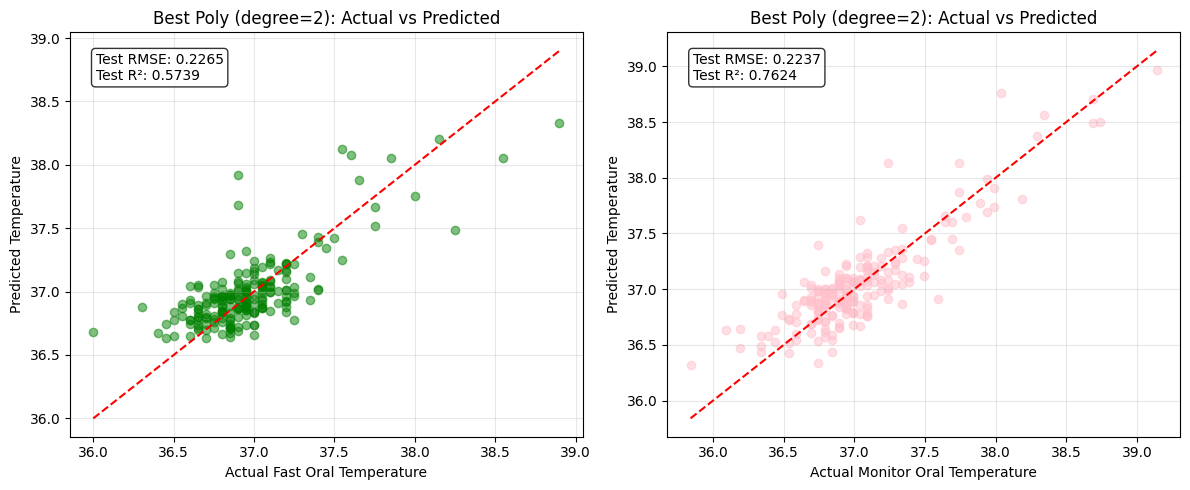

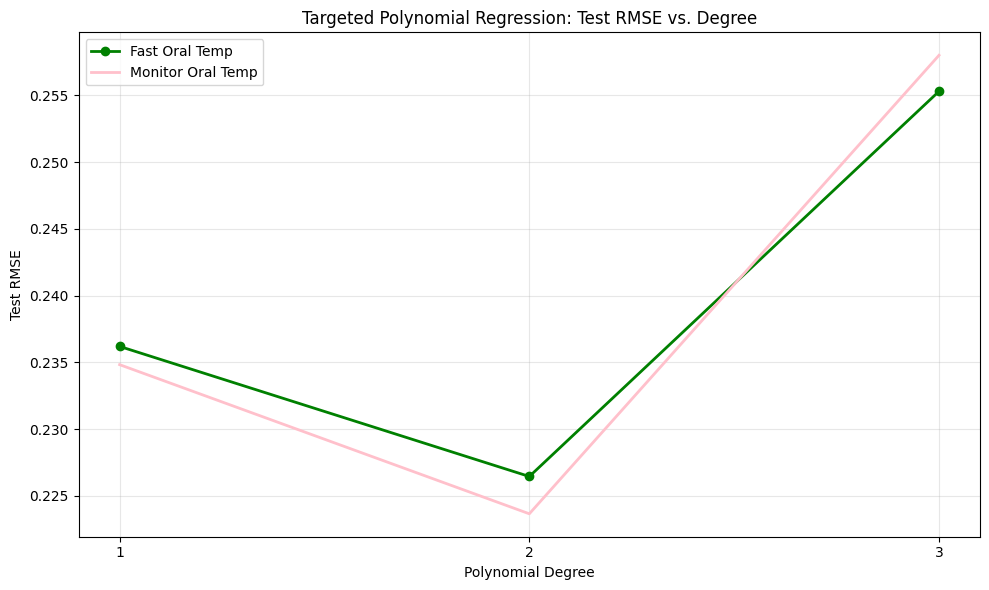

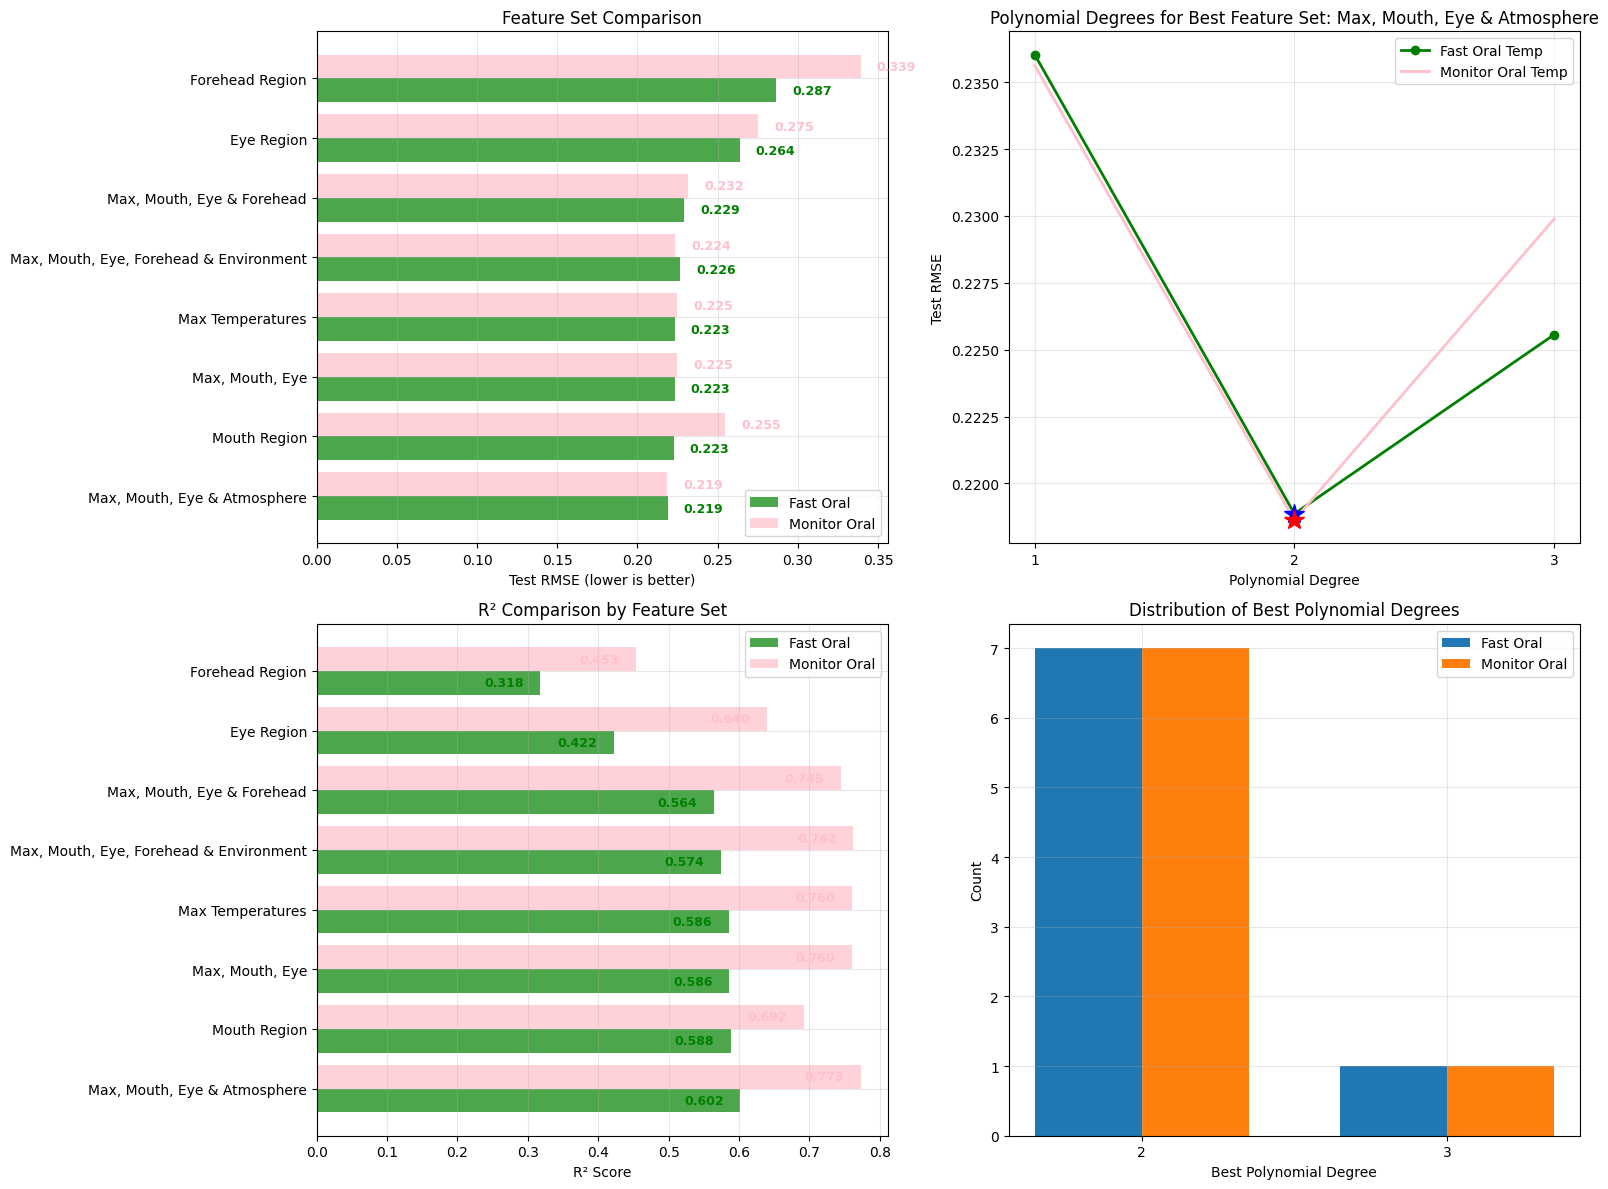

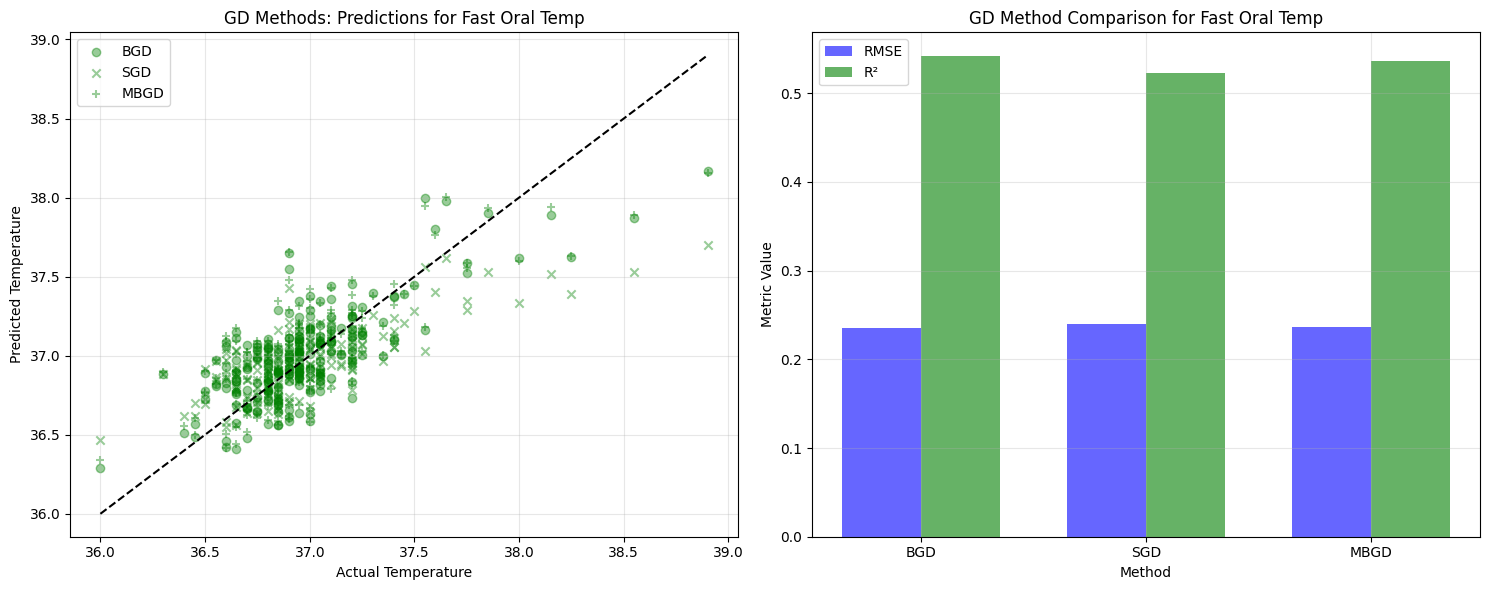

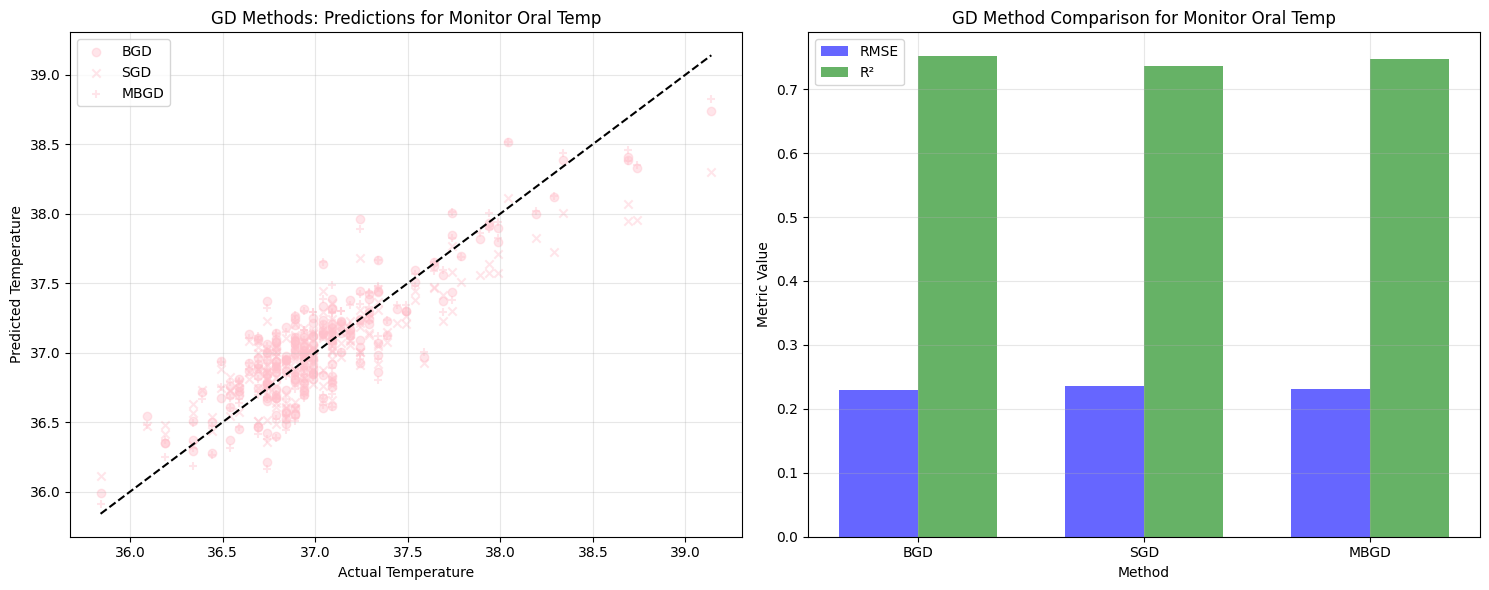

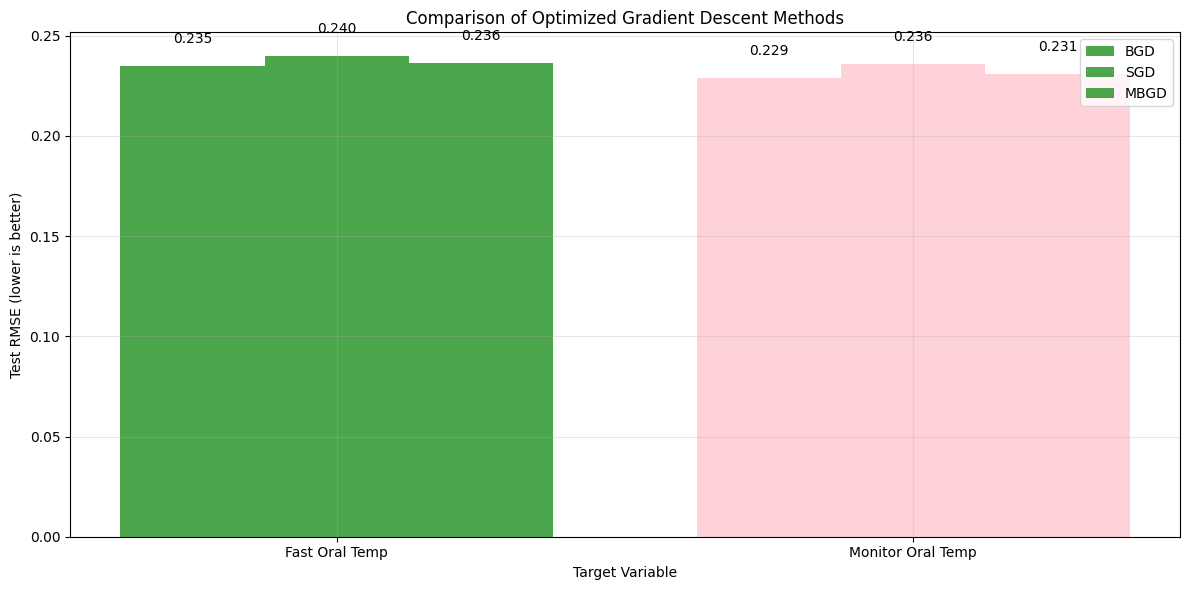

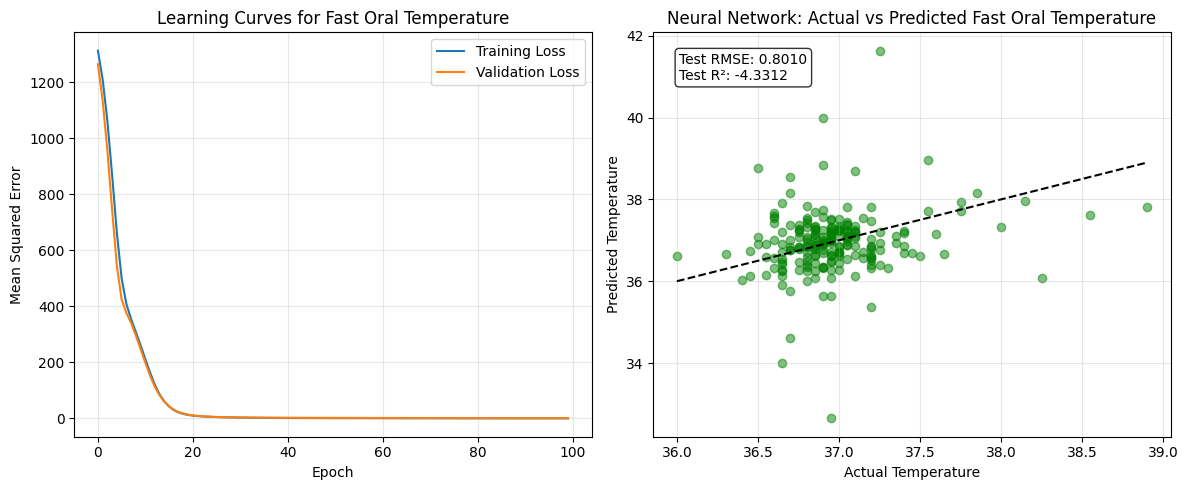

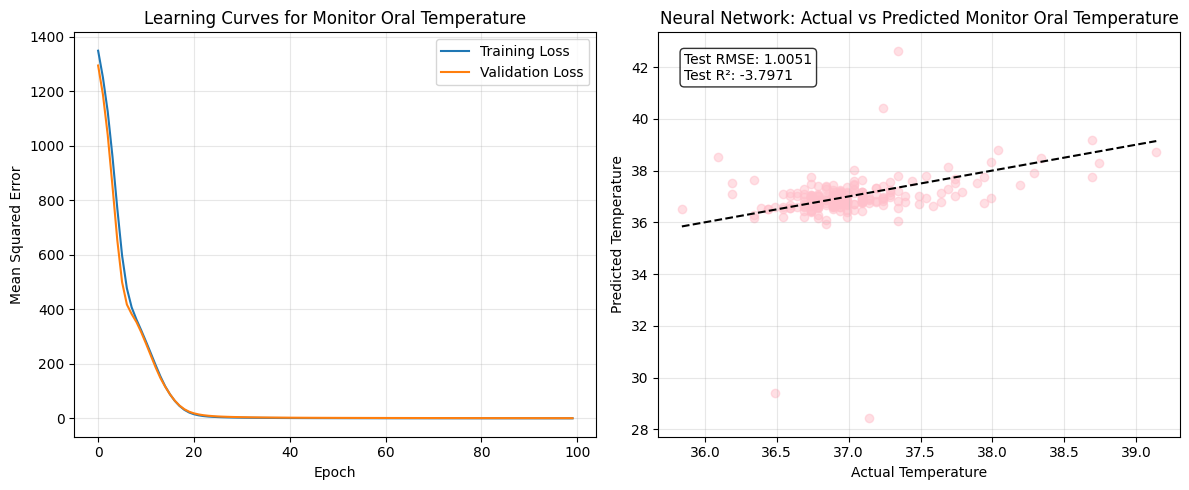

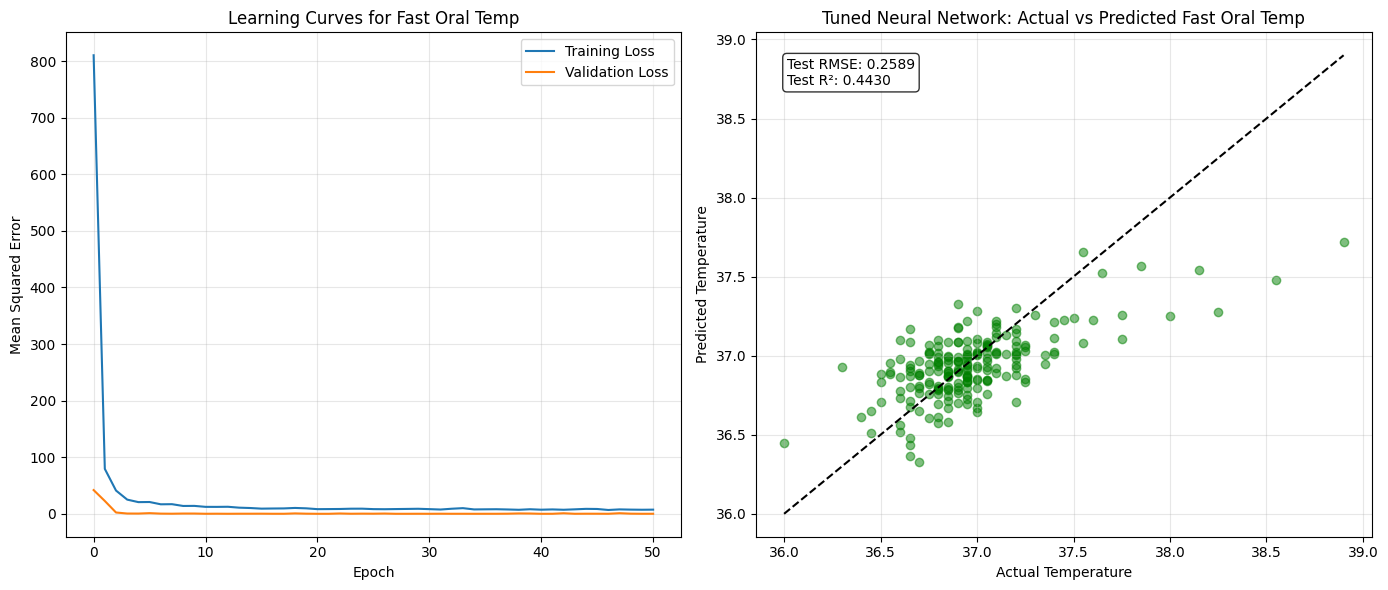

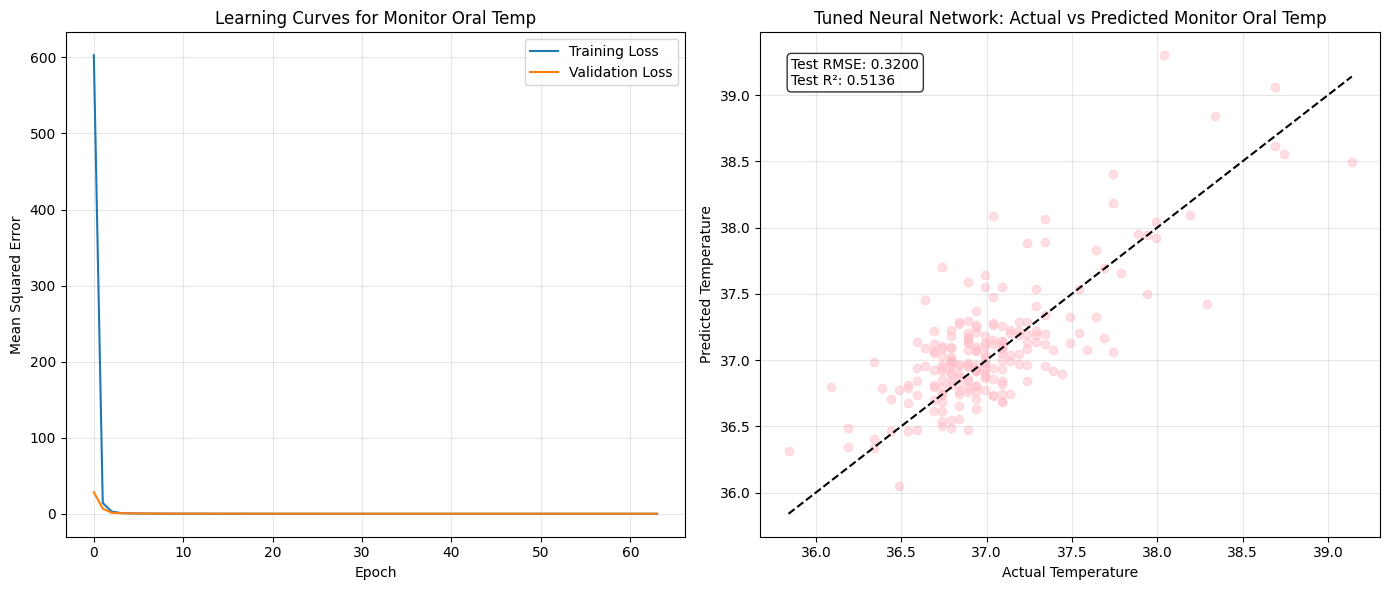

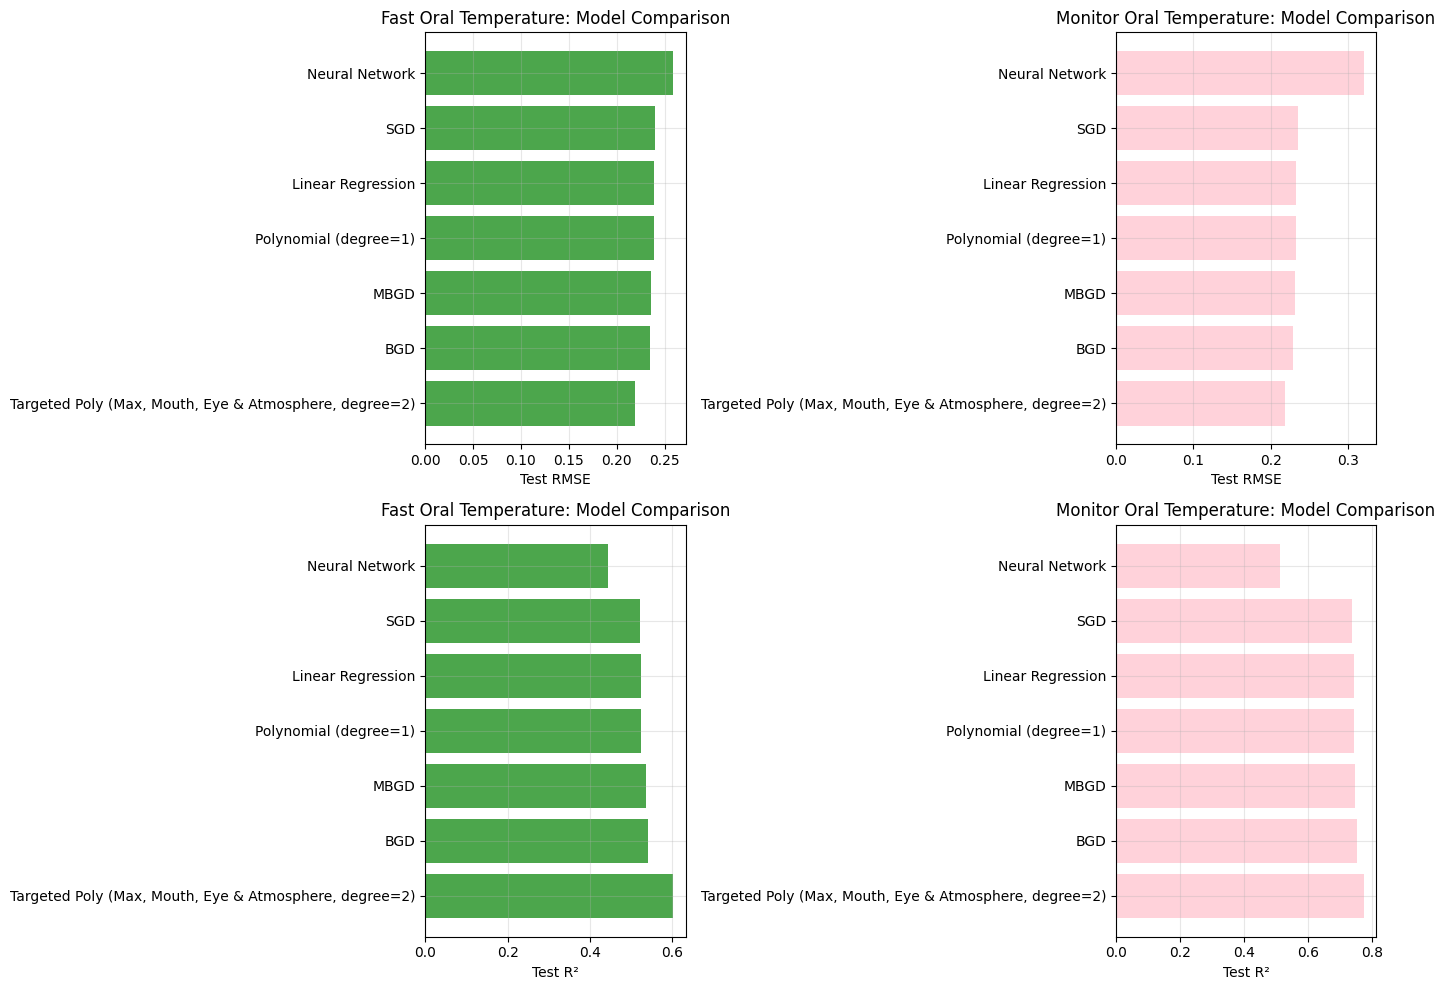

In [24]:

# Get data and visualise a little bit
data = load_and_explore_data()

# Preprocess into training and testing data
X_train, X_test, y_train, y_test, preprocessor, data = preprocessing(data)

# Do basic linear regression
linear_F, linear_M = perform_regression(y_train, y_test, preprocessor, X_train, X_test)

# Do basic polynomial regression with 3 degrees
poly_results_F, poly_results_M = perform_polynomial_regression(
    y_train, y_test, preprocessor, X_train, X_test, degrees=[1, 2, 3]
)

# Do targeted polynomial regression for multiple feature sets with 3 degrees for each (stores most effective one)
targeted_results = try_different_feature_sets(
    X_train, X_test, y_train, y_test, preprocessor,
)

# Do gradient descent with batch, stochastic and mini-batch gradient descent
gd_results, gd_comparison = optimize_gradient_descent(
    X_train, X_test, y_train, y_test, preprocessor
    )

# Run neural network approach with HP tuning
nn_results = run_nn_workflow(
    X_train, X_test, y_train, y_test, preprocessor
)

# Compare all approaches and visualise bar chart of results
compare_ml_approaches(
    nn_results, poly_results_F, poly_results_M, gd_results, linear_F, linear_M, targeted_results
)

print("Analysis Complete")


# Regression Results

From this comparison, we can see that targeted polynomial regression with a feature set of the Maximum Temperature, Mouth Temperature, Canthus Temperature and Atmospheric Temperature gets the best results in both RMSE and r2. This makes sense, as we are reducing the noise from the dataset, meaning we have better domain relevance and can avoid overfitting while capturing essenital information. This approach adds enough complexity through polynomial features witthout going overboard like a neural network may.

# Classification

Now we use this model to perform a classification task, where we class someone with fever as having an oral temperature of 37.5 C or above.

Defining fever as oral temperature ≥ 37.5°C
Fast oral fever prevalence in test set: 6.37%
Monitor oral fever prevalence in test set: 11.76%
Using best feature set from regression: ['T_OR_Max1', 'canthi4Max1', 'canthiMax1', 'T_Max1', 'T_atm']

Training polynomial (degree=1) classifier

Fast Oral Fever Classification:
Accuracy: 0.9314
Precision: 0.4815 (True positive rate among positive predictions)
Recall: 1.0000 (Percentage of actual fever cases detected)
F1-score: 0.6500
AUC: 0.9867

Monitor Oral Fever Classification:
Accuracy: 0.9412
Precision: 0.6765 (True positive rate among positive predictions)
Recall: 0.9583 (Percentage of actual fever cases detected)
F1-score: 0.7931
AUC: 0.9806



Training polynomial (degree=2) classifier

Fast Oral Fever Classification:
Accuracy: 0.9314
Precision: 0.4815 (True positive rate among positive predictions)
Recall: 1.0000 (Percentage of actual fever cases detected)
F1-score: 0.6500
AUC: 0.9883

Monitor Oral Fever Classification:
Accuracy: 0.9461
Precision: 0.6970 (True positive rate among positive predictions)
Recall: 0.9583 (Percentage of actual fever cases detected)
F1-score: 0.8070
AUC: 0.9748

Training polynomial (degree=3) classifier

Fast Oral Fever Classification:
Accuracy: 0.9314
Precision: 0.4815 (True positive rate among positive predictions)
Recall: 1.0000 (Percentage of actual fever cases detected)
F1-score: 0.6500
AUC: 0.9887

Monitor Oral Fever Classification:
Accuracy: 0.9412
Precision: 0.6765 (True positive rate among positive predictions)
Recall: 0.9583 (Percentage of actual fever cases detected)
F1-score: 0.7931
AUC: 0.9725


Target  Degree       AUC  Accuracy        F1  Precision    Recall
0     Fast Oral       1  0.986710  0.931373  0.650000   0.481481  1.000000
1     Fast Oral       2  0.988321  0.931373  0.650000   0.481481  1.000000
2     Fast Oral       3  0.988723  0.931373  0.650000   0.481481  1.000000
3  Monitor Oral       1  0.980556  0.941176  0.793103   0.676471  0.958333
4  Monitor Oral       2  0.974769  0.946078  0.807018   0.696970  0.958333
5  Monitor Oral       3  0.972454  0.941176  0.793103   0.676471  0.958333


Best Models:
Fast Oral: Polynomial degree 1 (F1=0.6500)
Monitor Oral: Polynomial degree 2 (F1=0.8070)


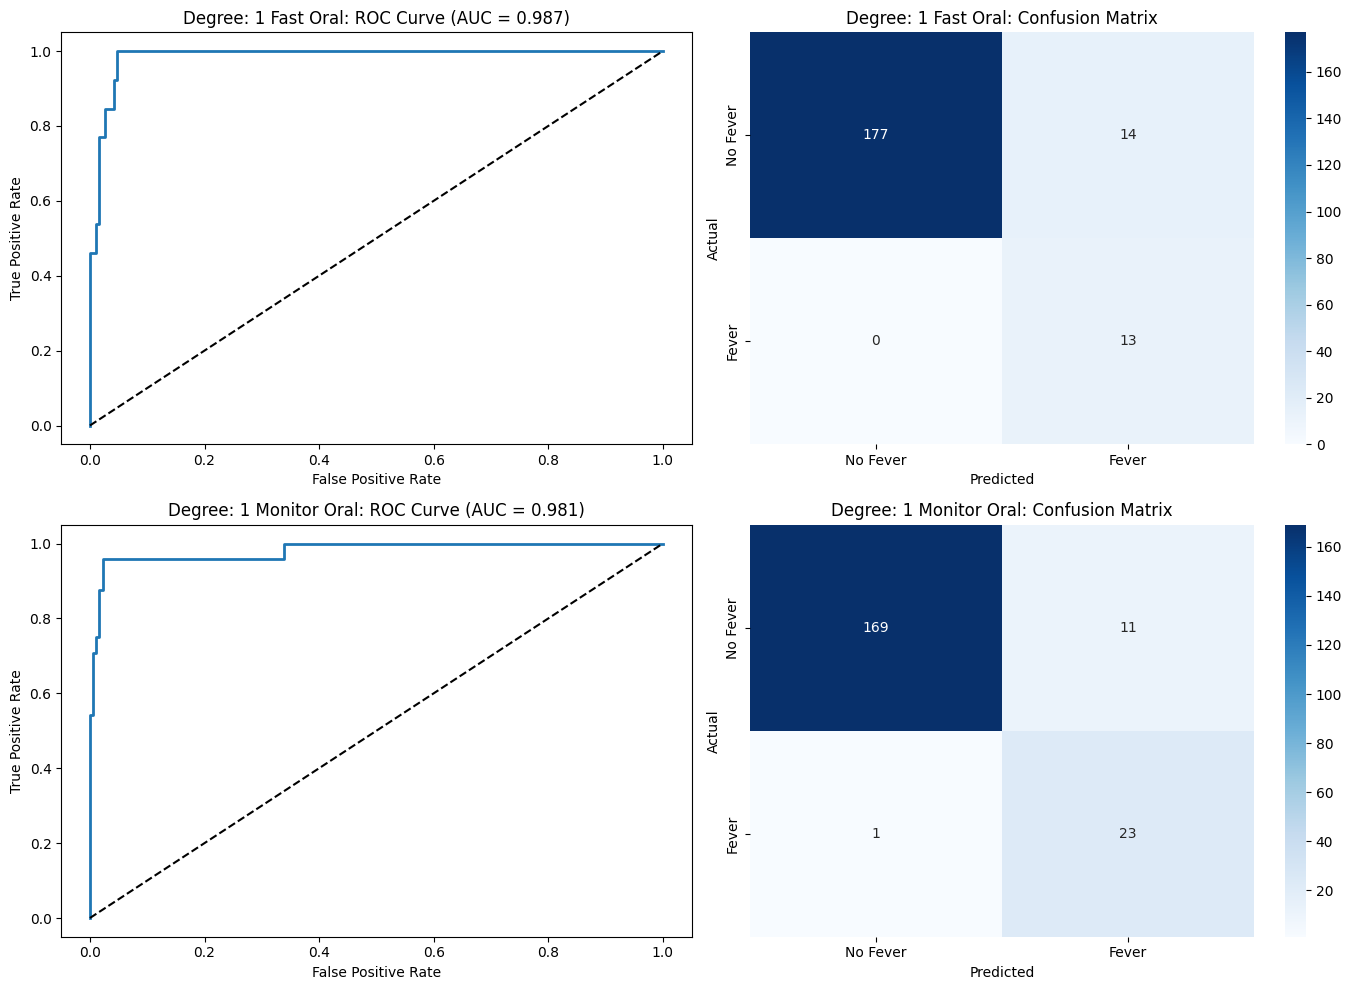

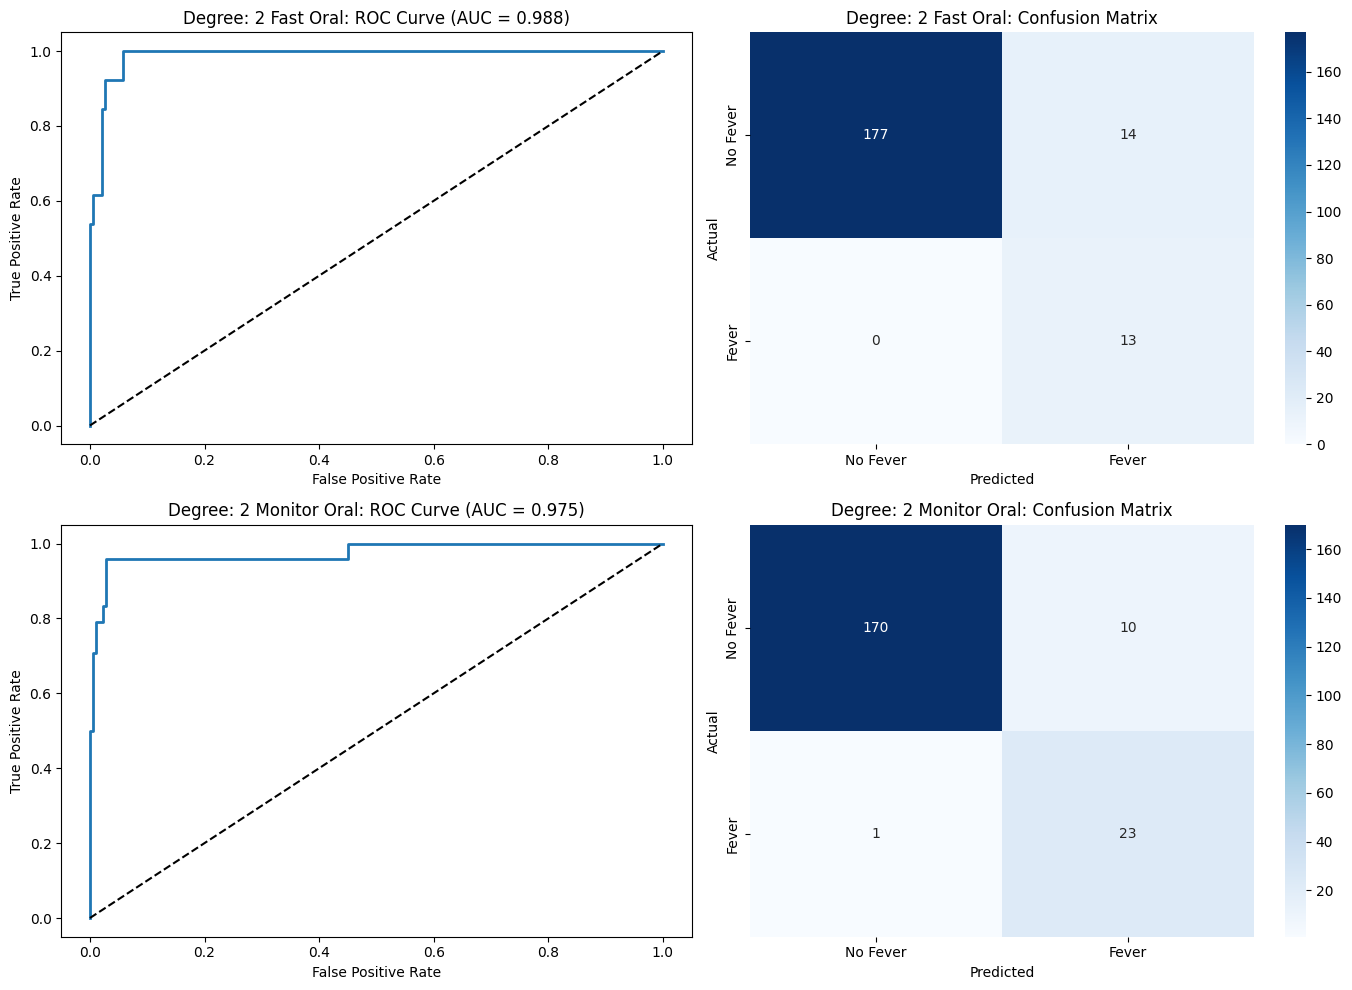

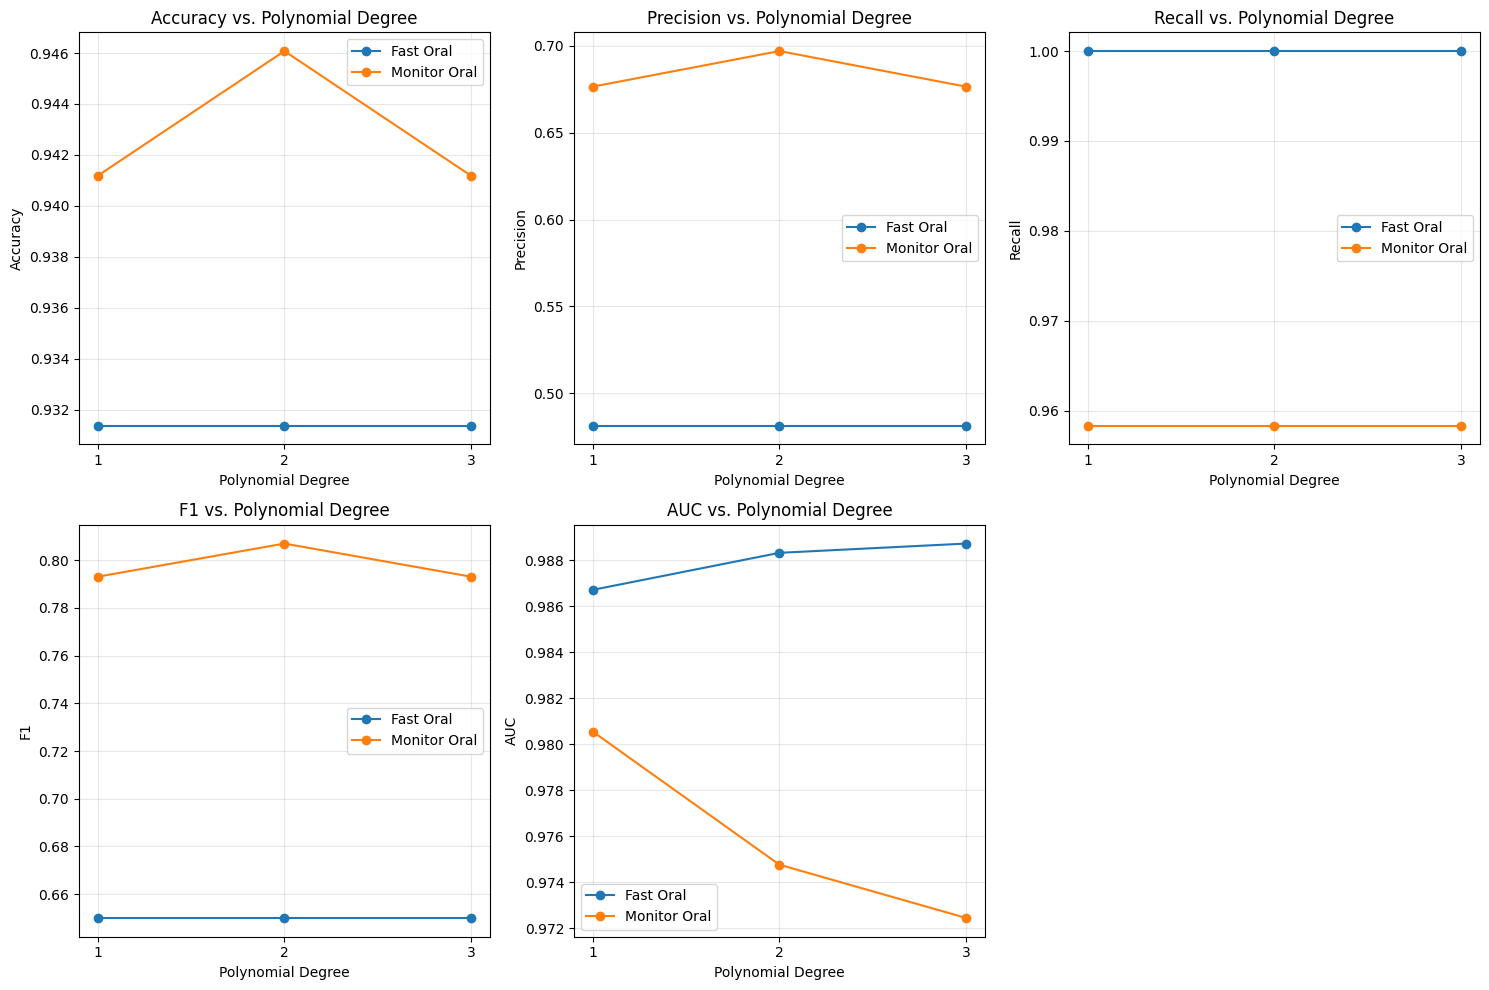

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.linear_model import LogisticRegression

def perform_fever_classification(data, X_train, X_test, y_train, y_test, preprocessor):
    
    # Define fever threshold
    fever_threshold = 37.5
    print(f"Defining fever as oral temperature ≥ {fever_threshold}°C")
    
    # Create binary fever targets
    y_train_fever_F = (y_train['aveOralF'] >= fever_threshold).astype(int)
    y_test_fever_F = (y_test['aveOralF'] >= fever_threshold).astype(int)
    
    y_train_fever_M = (y_train['aveOralM'] >= fever_threshold).astype(int)
    y_test_fever_M = (y_test['aveOralM'] >= fever_threshold).astype(int)
    
    # Print fever prevalence
    print(f"Fast oral fever prevalence in test set: {y_test_fever_F.mean():.2%}")
    print(f"Monitor oral fever prevalence in test set: {y_test_fever_M.mean():.2%}")
    
    # Use the feature set that worked best in regression
    best_features = ['T_OR_Max1', 'canthi4Max1', 'canthiMax1', 'T_Max1', 'T_atm']
    print(f"Using best feature set from regression: {best_features}")
    
    # Extract features
    X_train_subset = X_train[best_features].copy()
    X_test_subset = X_test[best_features].copy()
    
    # Results storage
    results = []
    
    # Try different polynomial degrees
    for degree in [1, 2, 3]:
        print(f"\nTraining polynomial (degree={degree}) classifier")
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train_subset)
        X_test_poly = poly.transform(X_test_subset)
        
        # Train classifiers for both temperature targets
        models = {}
        for target_name, y_train_fever, y_test_fever in [
            ('Fast Oral', y_train_fever_F, y_test_fever_F),
            ('Monitor Oral', y_train_fever_M, y_test_fever_M)
        ]:
            print(f"\n{target_name} Fever Classification:")
            
            # Use logistic regression 
            classifier = LogisticRegression(max_iter=1000, class_weight='balanced')
            classifier.fit(X_train_poly, y_train_fever)
            
            # Get predictions and probabilities
            y_pred = classifier.predict(X_test_poly)
            y_proba = classifier.predict_proba(X_test_poly)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(y_test_fever, y_pred)
            precision = precision_score(y_test_fever, y_pred)
            recall = recall_score(y_test_fever, y_pred)
            f1 = f1_score(y_test_fever, y_pred)
            auc = roc_auc_score(y_test_fever, y_proba)
            
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f} (True positive rate among positive predictions)")
            print(f"Recall: {recall:.4f} (Percentage of actual fever cases detected)")
            print(f"F1-score: {f1:.4f}")
            print(f"AUC: {auc:.4f}")
            
            # Store results
            results.append({
                'Target': target_name,
                'Degree': degree,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'AUC': auc,
                'y_test': y_test_fever,
                'y_pred': y_pred,
                'y_proba': y_proba,
                'model': classifier
            })
            
            # Save model
            models[target_name] = classifier
            
        # For degree 1 and 2, plot detailed results
        if degree == 2 or degree == 1:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            for i, target_name in enumerate(['Fast Oral', 'Monitor Oral']):
                result = next(r for r in results if r['Target'] == target_name and r['Degree'] == degree)
                
                # Plot ROC curve
                fpr, tpr, _ = roc_curve(result['y_test'], result['y_proba'])
                axes[i, 0].plot(fpr, tpr, lw=2)
                axes[i, 0].plot([0, 1], [0, 1], 'k--')
                axes[i, 0].set_xlabel('False Positive Rate')
                axes[i, 0].set_ylabel('True Positive Rate')
                axes[i, 0].set_title(f'Degree: {degree} {target_name}: ROC Curve (AUC = {result["AUC"]:.3f})')
                
                # Plot confusion matrix
                cm = confusion_matrix(result['y_test'], result['y_pred'])
                sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=axes[i, 1])
                axes[i, 1].set_xlabel('Predicted')
                axes[i, 1].set_ylabel('Actual')
                axes[i, 1].set_title(f'Degree: {degree} {target_name}: Confusion Matrix')
                axes[i, 1].set_xticklabels(['No Fever', 'Fever'])
                axes[i, 1].set_yticklabels(['No Fever', 'Fever'])
            
            plt.tight_layout()
            plt.show()
    
    # Convert results to DataFrame and display summary
    results_df = pd.DataFrame([(r['Target'], r['Degree'], r['Accuracy'], r['Precision'], 
                               r['Recall'], r['F1'], r['AUC']) 
                              for r in results], 
                            columns=['Target', 'Degree', 'Accuracy', 'Precision', 
                                     'Recall', 'F1', 'AUC'])
    
    # Reshape for better visualization
    results_pivot = results_df.pivot_table(
        index=['Target', 'Degree'], 
        values=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    ).reset_index()
    
    display(results_pivot)
    
    # Plot metrics comparison by degree
    plt.figure(figsize=(15, 10))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        
        for target in ['Fast Oral', 'Monitor Oral']:
            target_data = results_df[results_df['Target'] == target]
            plt.plot(target_data['Degree'], target_data[metric], 
                     marker='o', label=target)
        
        plt.xlabel('Polynomial Degree')
        plt.ylabel(metric)
        plt.title(f'{metric} vs. Polynomial Degree')
        plt.xticks([1, 2, 3])
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return results and best models
    best_results = {
        'Fast Oral': max([r for r in results if r['Target'] == 'Fast Oral'], key=lambda x: x['F1']),
        'Monitor Oral': max([r for r in results if r['Target'] == 'Monitor Oral'], key=lambda x: x['F1'])
    }
    
    print("\nBest Models:")
    for target, result in best_results.items():
        print(f"{target}: Polynomial degree {result['Degree']} (F1={result['F1']:.4f})")
    
    return results, best_results

# Run fever classification
fever_results, best_fever_models = perform_fever_classification(
    data, X_train, X_test, y_train, y_test, preprocessor
)

# Classification Results

In fever screening, both error types are important. False negatives risk public health as we miss detecting contagious individuals, and false positives waste resources and inconvenience healthy individuals.

Using F1 as our metric, as it combines both precision and recall (and wont be artifically high just because most people do not have fever), we get satisfactory scores. As you can see from the confusion matrix, monitor mode is more effective for detecting fever, and although we do have one case of fever not being detected, this is a small portion of the total data. Interestingly, fast mode has the same F1 score for degree 1 and 2. I think this may be due to fast mode being less accurate and therefore having less spread. 